# DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [10]:
ENV_NAME = 'LunarLander-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [11]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(8,)
Action space Discrete(4)


## Build DQN Architecture

In [12]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        Qsa = self.fc3_layer(state)
        
        return Qsa        

## Set Replay Buffer

In [13]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define DQN Agent

In [86]:
class DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        print('--- Q_values')
        print(self.dqn_net(states))
        print('--- actions')
        print(actions)
        print('--- Q_expected')
        print(Q_expected)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update model parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [85]:
states = []
for i in range(BATCH_SIZE):
    states.append(env.reset())

In [72]:
states = torch.from_numpy(env.reset()).float()
actions = torch.from_numpy(np.array([2]))

In [78]:
agent.dqn_net(states)

tensor([-1.3162, -1.6516, -1.0472, -2.3290], grad_fn=<AddBackward0>)

In [83]:
agent.dqn_net(states).gather(0, actions)

tensor([-1.0472], grad_fn=<GatherBackward>)

In [81]:
agent.dqn_net(states).gather(-1, actions)

tensor([-1.0472], grad_fn=<GatherBackward>)

In [87]:
agent = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [88]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [89]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/DQN_{ENV_NAME}.pth')
            
    print('Training complet[[2]ed.')
    return scores

In [ ]:
[ 2.0809e-01, -2.2196e-02,  2.3520e-02,  3.5518e-02],
[ 1.9480e-01, -2.3779e-02,  1.4317e-03,  5.5589e-02],
[ 2.0734e-01, -2.5885e-02,  2.2260e-02,  2.3514e-02],

[1],
[0],
[2],

[-2.2196e-02],
[ 1.9480e-01],
[ 2.2260e-02],

In [90]:
scores = train_agent(num_episodes=2000, max_time=1000)

Episode: 1, Average Score: -218.52--- Q_values
tensor([[ 2.0809e-01, -2.2196e-02,  2.3520e-02,  3.5518e-02],
        [ 1.9480e-01, -2.3779e-02,  1.4317e-03,  5.5589e-02],
        [ 2.0734e-01, -2.5885e-02,  2.2260e-02,  2.3514e-02],
        [ 1.8986e-01, -2.9066e-02, -1.1885e-02,  4.6614e-02],
        [ 1.9091e-01, -2.7226e-02, -9.7960e-03,  4.9701e-02],
        [ 2.1513e-01, -4.4000e-02,  2.4394e-02, -2.0481e-02],
        [ 1.9871e-01, -2.0762e-02,  8.5061e-03,  5.3778e-02],
        [ 1.9016e-01, -2.7652e-02, -1.0023e-02,  4.8582e-02],
        [ 2.0717e-01, -2.2153e-02,  2.1603e-02,  3.9848e-02],
        [ 2.0707e-01, -2.7047e-02,  2.2092e-02,  2.0973e-02],
        [ 1.8975e-01, -2.7863e-02, -1.0227e-02,  4.8923e-02],
        [ 2.0812e-01, -3.0875e-02,  2.2639e-02,  6.6247e-03],
        [ 2.0649e-01, -2.7763e-02,  2.2420e-02,  1.7355e-02],
        [ 1.9730e-01, -1.9792e-02,  8.2314e-03,  5.3087e-02],
        [ 2.0895e-01, -3.1782e-02,  2.2409e-02,  2.9912e-03],
        [ 1.9063e-01, -

--- Q_values
tensor([[ 0.1828, -0.0677,  0.0177, -0.0208],
        [ 0.1843, -0.0686,  0.0203, -0.0234],
        [ 0.1955, -0.0980,  0.0389, -0.0842],
        [ 0.1834, -0.0952, -0.0240, -0.0193],
        [ 0.1888, -0.0764,  0.0344, -0.0502],
        [ 0.1475, -0.0788, -0.0126,  0.0204],
        [ 0.1757, -0.0946, -0.0196, -0.0116],
        [ 0.1781, -0.0707,  0.0006, -0.0127],
        [ 0.1730, -0.0931, -0.0183, -0.0093],
        [ 0.1771, -0.0949, -0.0205, -0.0130],
        [ 0.1950, -0.0901,  0.0361, -0.0730],
        [ 0.1915, -0.0881,  0.0365, -0.0655],
        [ 0.1931, -0.0893,  0.0364, -0.0693],
        [ 0.1946, -0.0966,  0.0380, -0.0811],
        [ 0.1946, -0.0888,  0.0353, -0.0702],
        [ 0.1553, -0.0822, -0.0160,  0.0117],
        [ 0.1778, -0.0736, -0.0060, -0.0149],
        [ 0.1903, -0.0895,  0.0362, -0.0654],
        [ 0.1476, -0.0787, -0.0143,  0.0204],
        [ 0.2048, -0.1234,  0.0186, -0.1053],
        [ 0.1855, -0.0958, -0.0254, -0.0211],
        [ 0.1901, -0.

--- Q_expected
tensor([[-1.4770e-01],
        [-1.0573e-01],
        [-1.3126e-01],
        [ 1.4818e-01],
        [-1.2818e-01],
        [-1.5717e-01],
        [-1.1909e-01],
        [-1.3187e-01],
        [-7.0080e-02],
        [ 1.0609e-04],
        [-1.0004e-01],
        [ 4.3569e-02],
        [ 5.1066e-02],
        [-1.2943e-01],
        [ 1.6426e-01],
        [-1.9555e-02],
        [-1.0398e-02],
        [ 1.6378e-01],
        [-7.6936e-02],
        [-3.8416e-03],
        [-2.4581e-03],
        [ 4.5653e-02],
        [-1.4314e-01],
        [-1.2098e-01],
        [-1.4231e-01],
        [ 1.1902e-01],
        [-6.6270e-02],
        [-1.6323e-02],
        [-1.4364e-01],
        [ 1.6341e-01],
        [ 4.3335e-02],
        [-8.0315e-02],
        [-2.0373e-02],
        [-1.1614e-01],
        [-1.2103e-01],
        [ 1.8113e-01],
        [-1.4091e-01],
        [-7.1623e-02],
        [-3.2347e-02],
        [-1.2770e-01],
        [-6.3443e-02],
        [-2.3373e-02],
        [-2.1604e-0

--- actions
tensor([[2],
        [3],
        [3],
        [1],
        [1],
        [0],
        [0],
        [2],
        [1],
        [1],
        [2],
        [1],
        [2],
        [2],
        [0],
        [2],
        [0],
        [1],
        [1],
        [0],
        [3],
        [2],
        [2],
        [3],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2],
        [1],
        [3],
        [0],
        [1],
        [2],
        [0],
        [2],
        [3],
        [1],
        [0],
        [0],
        [1],
        [2],
        [0],
        [3],
        [3],
        [2],
        [0],
        [3],
        [3],
        [3],
        [0],
        [3],
        [0],
        [2],
        [3],
        [0],
        [3],
        [0],
        [1],
        [1],
        [1],
        [3],
        [3]])
--- Q_expected
tensor([[-0.0013],
        [-0.1440],
        [-0.1162],
        [-0.2133],
        [-0.1950],
        [ 0.1488],
        [ 0.1119],
       

--- Q_values
tensor([[ 0.0756, -0.2309, -0.0581, -0.1616],
        [ 0.0571, -0.2350, -0.0515, -0.1652],
        [ 0.1259, -0.2287, -0.0283, -0.1918],
        [ 0.1280, -0.2929,  0.0053, -0.2472],
        [ 0.1251, -0.1990, -0.0211, -0.1456],
        [ 0.1295, -0.2487, -0.0570, -0.1815],
        [ 0.1243, -0.2334, -0.0256, -0.1970],
        [ 0.0771, -0.2273, -0.0583, -0.1567],
        [ 0.0502, -0.2317, -0.1211, -0.2037],
        [ 0.0539, -0.2444, -0.0373, -0.1700],
        [ 0.1306, -0.3063,  0.0096, -0.2520],
        [ 0.1210, -0.2506, -0.0119, -0.2232],
        [ 0.0671, -0.2285, -0.0580, -0.1619],
        [ 0.0902, -0.2319, -0.0615, -0.1549],
        [ 0.1271, -0.2181, -0.0368, -0.1771],
        [ 0.0534, -0.2355, -0.0434, -0.1651],
        [ 0.1368, -0.2517, -0.0579, -0.1830],
        [ 0.0968, -0.2377, -0.0617, -0.1591],
        [ 0.0527, -0.2446, -0.0431, -0.1686],
        [ 0.1384, -0.3433,  0.0195, -0.2752],
        [ 0.0561, -0.2431, -0.0417, -0.1687],
        [ 0.1371, -0.

--- Q_values
tensor([[ 0.0984, -0.2984, -0.0446, -0.2875],
        [-0.0277, -0.2391, -0.2009, -0.2925],
        [ 0.0355, -0.2798, -0.1075, -0.2542],
        [ 0.0341, -0.2782, -0.1047, -0.2528],
        [ 0.1018, -0.2343, -0.0566, -0.2035],
        [ 0.1001, -0.2808, -0.0539, -0.2670],
        [ 0.0993, -0.3014, -0.0429, -0.2898],
        [ 0.1327, -0.4722, -0.0345, -0.3125],
        [ 0.1143, -0.4046, -0.0138, -0.3384],
        [ 0.0944, -0.2761, -0.0950, -0.2272],
        [ 0.1011, -0.2311, -0.0531, -0.1983],
        [ 0.0545, -0.2630, -0.1069, -0.2219],
        [ 0.0352, -0.2716, -0.1053, -0.2444],
        [ 0.0530, -0.2634, -0.1074, -0.2228],
        [ 0.1037, -0.2595, -0.0670, -0.2366],
        [ 0.0287, -0.2771, -0.1037, -0.2472],
        [ 0.1154, -0.4064, -0.0123, -0.3418],
        [ 0.0786, -0.2682, -0.0984, -0.2187],
        [ 0.1116, -0.2876, -0.0935, -0.2408],
        [ 0.0810, -0.2704, -0.0982, -0.2224],
        [ 0.1137, -0.3814, -0.0186, -0.3236],
        [ 0.1103, -0.

--- Q_values
tensor([[ 0.0622, -0.3010, -0.1327, -0.2749],
        [ 0.0023, -0.3083, -0.1494, -0.3165],
        [ 0.0855, -0.3984, -0.0579, -0.3709],
        [ 0.0415, -0.2905, -0.1382, -0.2685],
        [ 0.0681, -0.3037, -0.1305, -0.2757],
        [ 0.0808, -0.3931, -0.0600, -0.3717],
        [ 0.0663, -0.3008, -0.0964, -0.2795],
        [ 0.0749, -0.2689, -0.0905, -0.2566],
        [ 0.0908, -0.4597, -0.0469, -0.3998],
        [ 0.0264, -0.2869, -0.1446, -0.2762],
        [-0.1051, -0.2400, -0.2643, -0.3662],
        [ 0.0742, -0.3403, -0.0926, -0.3228],
        [ 0.0734, -0.3233, -0.0931, -0.3031],
        [ 0.0584, -0.2981, -0.1337, -0.2720],
        [ 0.0052, -0.2999, -0.1481, -0.3056],
        [-0.0138, -0.2965, -0.1444, -0.3059],
        [ 0.0726, -0.3168, -0.0942, -0.2988],
        [ 0.0671, -0.3820, -0.0873, -0.3577],
        [ 0.0708, -0.2893, -0.0947, -0.2724],
        [-0.0899, -0.2357, -0.2538, -0.3659],
        [ 0.0101, -0.2922, -0.1473, -0.2930],
        [ 0.0858, -0.

--- Q_values
tensor([[ 0.0651, -0.5018, -0.1005, -0.4603],
        [ 0.0483, -0.3689, -0.1363, -0.3988],
        [ 0.0484, -0.5548, -0.1244, -0.5010],
        [-0.0036, -0.3322, -0.1983, -0.3554],
        [ 0.0468, -0.5117, -0.1269, -0.4760],
        [-0.0073, -0.3310, -0.1992, -0.3568],
        [-0.0008, -0.3353, -0.1976, -0.3571],
        [ 0.0355, -0.3535, -0.1474, -0.3571],
        [ 0.0482, -0.3034, -0.1306, -0.3146],
        [-0.0339, -0.3523, -0.2048, -0.4025],
        [ 0.0508, -0.4289, -0.1176, -0.4363],
        [-0.0284, -0.3557, -0.2078, -0.4051],
        [ 0.0435, -0.4000, -0.1484, -0.4022],
        [ 0.0552, -0.3562, -0.1724, -0.3587],
        [-0.0247, -0.3599, -0.2088, -0.4085],
        [ 0.0509, -0.5699, -0.1265, -0.5114],
        [ 0.0241, -0.3387, -0.1846, -0.3458],
        [-0.0247, -0.3580, -0.2094, -0.4057],
        [ 0.0300, -0.3424, -0.1827, -0.3486],
        [ 0.0106, -0.3309, -0.1898, -0.3424],
        [ 0.0503, -0.5685, -0.1253, -0.5099],
        [ 0.0329, -0.

Episode: 3, Average Score: -374.04--- Q_values
tensor([[ 3.4754e-03, -7.7285e-01, -2.0464e-01, -7.0790e-01],
        [-4.6377e-03, -4.7489e-01, -2.2058e-01, -5.1973e-01],
        [ 1.3579e-02, -4.8947e-01, -1.8746e-01, -5.3829e-01],
        [-3.4507e-04, -6.3186e-01, -2.0333e-01, -6.1828e-01],
        [-5.0348e-02, -3.9369e-01, -2.7812e-01, -4.7909e-01],
        [-4.6563e-03, -4.3030e-01, -2.1885e-01, -4.7947e-01],
        [-7.7010e-02, -4.1448e-01, -2.9245e-01, -5.1997e-01],
        [-8.4889e-02, -4.1486e-01, -2.9135e-01, -5.2354e-01],
        [-9.3317e-03, -5.1373e-01, -2.1717e-01, -5.4361e-01],
        [-1.8289e-03, -4.6554e-01, -2.2002e-01, -5.1196e-01],
        [ 2.8583e-02, -5.6710e-01, -1.7108e-01, -5.6282e-01],
        [ 1.6993e-02, -3.7860e-01, -2.1071e-01, -4.4751e-01],
        [ 1.5374e-02, -5.1163e-01, -1.8141e-01, -5.5227e-01],
        [ 3.6812e-03, -4.3831e-01, -2.1751e-01, -4.8812e-01],
        [ 1.9860e-03, -5.5027e-01, -2.0805e-01, -5.6967e-01],
        [ 8.6275e-03, -

--- Q_values
tensor([[-0.0475, -0.4241, -0.2781, -0.5233],
        [-0.0533, -0.5014, -0.3054, -0.6025],
        [-0.0678, -0.7382, -0.3257, -0.7790],
        [-0.0179, -0.4451, -0.3054, -0.5413],
        [-0.1225, -0.4743, -0.3950, -0.6389],
        [-0.0283, -0.3846, -0.2500, -0.4782],
        [-0.0640, -0.4705, -0.3004, -0.5686],
        [-0.0345, -0.3975, -0.2636, -0.4983],
        [-0.0416, -0.5585, -0.2798, -0.6543],
        [-0.0785, -0.8228, -0.3329, -0.8357],
        [-0.0295, -0.4427, -0.3123, -0.5437],
        [-0.0465, -0.4653, -0.2936, -0.5725],
        [-0.0311, -0.4432, -0.3135, -0.5448],
        [-0.0397, -0.4092, -0.2700, -0.5100],
        [-0.0571, -0.4926, -0.3042, -0.5943],
        [-0.0585, -0.4519, -0.2918, -0.5501],
        [-0.0350, -0.4677, -0.2936, -0.5770],
        [-0.0460, -0.4740, -0.2965, -0.5787],
        [-0.1201, -0.4660, -0.3900, -0.6253],
        [-0.3891, -0.3625, -0.5947, -0.8481],
        [-0.0291, -0.3859, -0.2488, -0.4773],
        [-0.0413, -0.

        [1]])
--- Q_expected
tensor([[-0.5897],
        [-0.5711],
        [-0.5706],
        [-0.3604],
        [-0.0956],
        [-0.1827],
        [-0.6497],
        [-0.8654],
        [-0.5046],
        [-0.1175],
        [-0.7237],
        [-0.0962],
        [-0.6674],
        [-0.4837],
        [-0.7741],
        [-0.0946],
        [-0.7208],
        [-0.4946],
        [-0.6723],
        [-0.3866],
        [-0.3710],
        [-0.0924],
        [-0.3580],
        [-0.0896],
        [-0.4795],
        [-0.8270],
        [-0.0745],
        [-0.0925],
        [-0.0986],
        [-0.5365],
        [-0.6738],
        [-0.0952],
        [-0.3601],
        [-0.6738],
        [-0.1475],
        [-0.4806],
        [-0.7144],
        [-0.1670],
        [-0.6481],
        [-0.3837],
        [-0.7714],
        [-0.4233],
        [-0.5249],
        [-0.4499],
        [-0.6295],
        [-0.4217],
        [-0.7526],
        [-0.4751],
        [-0.0754],
        [-0.3413],
        [-0.5395],
  

--- Q_expected
tensor([[-0.2217],
        [-0.7680],
        [-0.4839],
        [-0.7566],
        [-0.4182],
        [-0.7235],
        [-1.0007],
        [-0.5236],
        [-0.1647],
        [-0.5748],
        [-0.6677],
        [-0.6412],
        [-0.8498],
        [-0.8148],
        [-0.1608],
        [-0.9228],
        [-0.8289],
        [-0.2526],
        [-0.8698],
        [-0.6240],
        [-0.4711],
        [-0.6520],
        [-0.1573],
        [-0.6361],
        [-0.1496],
        [-0.2389],
        [-0.1644],
        [-0.6025],
        [-0.1762],
        [-0.4730],
        [-0.4720],
        [-0.1834],
        [-0.9278],
        [-0.8480],
        [-0.9132],
        [-0.6127],
        [-0.4241],
        [-0.7543],
        [-0.4647],
        [-0.1880],
        [-0.7750],
        [-0.6804],
        [-0.8547],
        [-0.9162],
        [-0.5095],
        [-0.4832],
        [-0.8876],
        [-0.2879],
        [-0.5316],
        [-0.5806],
        [-0.4910],
        [-0.5178

        [-0.8059, -0.5707, -1.0708, -1.4047]], grad_fn=<AddmmBackward>)
--- actions
tensor([[3],
        [0],
        [2],
        [2],
        [2],
        [0],
        [1],
        [0],
        [0],
        [3],
        [0],
        [3],
        [3],
        [3],
        [3],
        [1],
        [1],
        [1],
        [1],
        [3],
        [1],
        [1],
        [3],
        [3],
        [2],
        [0],
        [2],
        [2],
        [3],
        [2],
        [0],
        [1],
        [3],
        [2],
        [0],
        [3],
        [2],
        [2],
        [1],
        [0],
        [0],
        [3],
        [3],
        [2],
        [2],
        [3],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [2],
        [2],
        [3]])
--- Q_expected
tensor([[-1.3844],
        [-0.2003],
        [-0.7458],
        [-0

--- actions
tensor([[1],
        [0],
        [1],
        [2],
        [3],
        [0],
        [1],
        [0],
        [0],
        [2],
        [2],
        [0],
        [0],
        [3],
        [3],
        [2],
        [3],
        [3],
        [0],
        [1],
        [1],
        [1],
        [3],
        [1],
        [3],
        [3],
        [1],
        [1],
        [0],
        [0],
        [3],
        [2],
        [3],
        [1],
        [1],
        [1],
        [0],
        [0],
        [3],
        [1],
        [0],
        [3],
        [1],
        [3],
        [1],
        [0],
        [0],
        [2],
        [0],
        [2],
        [0],
        [1],
        [2],
        [0],
        [3],
        [3],
        [3],
        [3],
        [1],
        [3],
        [0],
        [3],
        [2],
        [3]])
--- Q_expected
tensor([[-0.6786],
        [-0.3582],
        [-0.6857],
        [-0.9315],
        [-1.0390],
        [-0.3274],
        [-1.0128],
       

        [-0.4373, -0.9973, -0.8501, -1.3672]], grad_fn=<AddmmBackward>)
--- actions
tensor([[3],
        [3],
        [2],
        [1],
        [1],
        [1],
        [1],
        [3],
        [0],
        [1],
        [1],
        [1],
        [3],
        [0],
        [1],
        [2],
        [3],
        [1],
        [2],
        [1],
        [3],
        [2],
        [2],
        [0],
        [3],
        [0],
        [1],
        [0],
        [3],
        [1],
        [0],
        [3],
        [1],
        [3],
        [0],
        [2],
        [1],
        [0],
        [2],
        [0],
        [1],
        [1],
        [1],
        [3],
        [0],
        [1],
        [2],
        [0],
        [2],
        [3],
        [3],
        [1],
        [1],
        [3],
        [2],
        [3],
        [2],
        [0],
        [1],
        [1],
        [2],
        [2],
        [3],
        [0]])
--- Q_expected
tensor([[-1.5019],
        [-2.0357],
        [-1.0721],
        [-0

--- Q_values
tensor([[-0.4929, -0.9018, -0.8965, -1.3821],
        [-0.6098, -0.8838, -1.0520, -1.4509],
        [-0.5551, -0.8723, -1.0047, -1.3998],
        [-0.5660, -1.2069, -1.0179, -1.6666],
        [-0.4542, -0.8362, -0.8151, -1.2655],
        [-0.4494, -0.8402, -0.8400, -1.3056],
        [-0.5724, -1.2153, -1.0225, -1.6744],
        [-0.4840, -0.8924, -0.8911, -1.3721],
        [-0.4784, -0.8850, -0.9274, -1.3628],
        [-0.5470, -0.8819, -0.9967, -1.4044],
        [-0.4872, -0.8938, -0.8873, -1.3709],
        [-0.5452, -1.0692, -0.9727, -1.5377],
        [-0.4993, -0.8875, -0.9152, -1.3910],
        [-0.8010, -1.7150, -1.3426, -2.2172],
        [-0.5361, -1.0572, -0.9624, -1.5219],
        [-0.5925, -1.3324, -1.0502, -1.7616],
        [-0.4680, -0.8766, -0.8570, -1.3348],
        [-0.4954, -0.9032, -0.9031, -1.3874],
        [-0.5958, -1.3512, -1.0565, -1.7742],
        [-0.8095, -1.7300, -1.3536, -2.2356],
        [-0.7546, -1.6085, -1.2647, -2.0931],
        [-0.5734, -1.

--- Q_values
tensor([[-0.6359, -1.1303, -1.0705, -1.6753],
        [-0.4971, -0.8496, -0.8609, -1.3289],
        [-0.8105, -1.5580, -1.3033, -2.1155],
        [-0.6169, -0.9611, -1.0931, -1.5440],
        [-0.5741, -1.0246, -1.0025, -1.5744],
        [-0.5762, -0.9901, -0.9754, -1.5077],
        [-0.6774, -1.3043, -1.1408, -1.8393],
        [-0.6962, -1.4356, -1.1698, -1.9319],
        [-0.7690, -1.0042, -1.2399, -1.6979],
        [-0.6536, -1.2426, -1.1074, -1.7689],
        [-0.5516, -0.9399, -0.9431, -1.4551],
        [-0.6336, -0.9558, -1.1078, -1.5495],
        [-0.8271, -1.0640, -1.3221, -1.8072],
        [-0.9604, -1.1779, -1.4907, -2.0241],
        [-0.7804, -1.4702, -1.2503, -2.0220],
        [-0.6886, -1.3305, -1.1481, -1.8661],
        [-0.8174, -1.0419, -1.3064, -1.7792],
        [-0.7890, -1.5055, -1.2751, -2.0614],
        [-0.6381, -1.1509, -1.0745, -1.6861],
        [-0.6607, -1.2533, -1.1130, -1.7786],
        [-0.6815, -1.3232, -1.1450, -1.8534],
        [-0.6339, -1.

tensor([[-0.6603, -1.0336, -1.0893, -1.6393],
        [-1.7776, -1.2458, -2.3679, -2.9399],
        [-0.8971, -1.0899, -1.4145, -1.8941],
        [-0.8057, -1.4582, -1.3404, -2.0810],
        [-0.7886, -1.3572, -1.2811, -1.9957],
        [-0.6100, -0.9736, -1.0597, -1.5760],
        [-0.6521, -1.0200, -1.0856, -1.6340],
        [-0.7501, -1.0566, -1.2620, -1.7431],
        [-0.5481, -0.8947, -0.9948, -1.4581],
        [-0.7828, -1.2678, -1.2457, -1.8914],
        [-0.7965, -1.3783, -1.2865, -1.9941],
        [-0.8889, -1.0858, -1.4040, -1.8824],
        [-0.7224, -1.1086, -1.1786, -1.7592],
        [-0.6553, -1.0221, -1.0767, -1.6182],
        [-0.7289, -1.1160, -1.1900, -1.7747],
        [-0.7232, -1.0800, -1.1862, -1.7496],
        [-0.8140, -1.3563, -1.3013, -1.9944],
        [-0.7442, -1.1120, -1.2141, -1.7936],
        [-0.6633, -1.0373, -1.0906, -1.6406],
        [-0.5966, -0.9514, -1.0461, -1.5446],
        [-0.8266, -1.4906, -1.3482, -2.1169],
        [-0.6558, -1.0518, -1.1554

--- Q_values
tensor([[-1.0763, -1.9564, -1.6862, -2.5945],
        [-0.7616, -1.1341, -1.2434, -1.8068],
        [-0.7771, -1.1619, -1.3023, -1.8660],
        [-1.2277, -2.0981, -1.8734, -2.8460],
        [-0.7749, -1.1548, -1.2594, -1.8299],
        [-0.8414, -1.2229, -1.3766, -1.9644],
        [-1.0139, -1.8237, -1.6037, -2.4559],
        [-0.7543, -1.1556, -1.2674, -1.8508],
        [-0.8873, -1.3084, -1.4697, -1.9967],
        [-0.9392, -1.5450, -1.4802, -2.2121],
        [-0.7627, -1.1472, -1.2288, -1.7866],
        [-1.0546, -1.9055, -1.6565, -2.5452],
        [-0.9652, -1.1752, -1.5219, -2.0066],
        [-0.7592, -1.1522, -1.3073, -1.8286],
        [-0.7030, -1.0729, -1.1984, -1.7317],
        [-0.7878, -1.1629, -1.3399, -1.8562],
        [-0.8059, -1.2127, -1.2932, -1.8818],
        [-0.8052, -1.2030, -1.3041, -1.8854],
        [-0.7694, -1.1504, -1.3204, -1.8335],
        [-0.8660, -1.2596, -1.3880, -1.9913],
        [-0.9524, -1.1678, -1.5126, -1.9911],
        [-0.9145, -1.

--- Q_values
tensor([[-1.0818, -1.7350, -1.6806, -2.4732],
        [-0.7978, -1.1558, -1.2918, -1.8418],
        [-0.9395, -1.2538, -1.5512, -2.0659],
        [-0.9421, -1.3342, -1.4875, -2.1074],
        [-0.7997, -1.1479, -1.2798, -1.8182],
        [-1.0517, -1.6664, -1.6409, -2.4014],
        [-0.9953, -1.5248, -1.5720, -2.2814],
        [-0.9438, -1.3068, -1.5258, -2.1210],
        [-1.2415, -1.9807, -1.8838, -2.7785],
        [-0.9032, -1.3523, -1.4575, -2.1095],
        [-0.8652, -1.2633, -1.4312, -2.0331],
        [-0.7768, -1.1435, -1.3142, -1.8595],
        [-1.1914, -1.3728, -1.8500, -2.3888],
        [-0.7927, -1.1649, -1.3384, -1.8926],
        [-0.9232, -1.3263, -1.4566, -2.0717],
        [-1.0987, -1.7952, -1.7257, -2.5440],
        [-2.2317, -1.6312, -3.0374, -3.6746],
        [-1.0458, -1.6591, -1.6360, -2.3941],
        [-0.9172, -1.3290, -1.4478, -2.0650],
        [-1.0093, -1.2456, -1.6234, -2.1150],
        [-1.2374, -1.9762, -1.8759, -2.7688],
        [-1.0871, -1.

--- Q_values
tensor([[-1.0382, -1.4190, -1.6008, -2.2441],
        [-1.1390, -1.7429, -1.7421, -2.5247],
        [-0.9913, -1.3702, -1.5336, -2.1572],
        [-0.8659, -1.2235, -1.4267, -1.9980],
        [-0.9947, -1.4487, -1.5652, -2.2465],
        [-1.0225, -1.4169, -1.5741, -2.2162],
        [-1.0146, -1.3039, -1.6055, -2.1523],
        [-0.9435, -1.2994, -1.4779, -2.0845],
        [-1.0730, -1.5597, -1.6450, -2.3542],
        [-1.0024, -1.4295, -1.5473, -2.1895],
        [-1.3936, -2.1716, -2.0703, -3.0331],
        [-1.2572, -2.0680, -1.9133, -2.8310],
        [-1.0260, -1.4111, -1.5811, -2.2215],
        [-0.9347, -1.2922, -1.5476, -2.0894],
        [-1.5950, -2.5225, -2.3585, -3.4592],
        [-1.2160, -1.9783, -1.8557, -2.7407],
        [-0.7515, -1.0768, -1.2958, -1.7794],
        [-0.9093, -1.2926, -1.5202, -2.0720],
        [-0.8800, -1.2249, -1.3816, -1.9455],
        [-0.9556, -1.3099, -1.5712, -2.1170],
        [-1.1099, -1.6235, -1.6930, -2.4173],
        [-1.0563, -1.

Episode: 6, Average Score: -282.03--- Q_values
tensor([[-0.8752, -1.1980, -1.4442, -1.9783],
        [-0.9132, -1.2278, -1.4242, -1.9716],
        [-1.2948, -1.9431, -1.9503, -2.7995],
        [-1.4634, -2.1776, -2.1603, -3.0999],
        [-2.1427, -3.2863, -3.0951, -4.4746],
        [-1.0387, -1.4223, -1.5953, -2.2191],
        [-0.9479, -1.2772, -1.4986, -2.0848],
        [-1.9881, -3.0393, -2.8835, -4.1651],
        [-1.1663, -1.6287, -1.7643, -2.4825],
        [-0.9762, -1.3212, -1.5119, -2.0971],
        [-1.1867, -1.7166, -1.8124, -2.5762],
        [-1.7561, -2.6780, -2.5734, -3.7113],
        [-1.1732, -1.3803, -1.8254, -2.3499],
        [-1.5126, -2.2622, -2.2242, -3.1999],
        [-1.6787, -2.5502, -2.4525, -3.5458],
        [-1.1852, -1.5820, -1.8106, -2.4986],
        [-1.1096, -1.4665, -1.7355, -2.3796],
        [-0.9846, -1.3519, -1.5747, -2.2005],
        [-1.2632, -1.4724, -1.8844, -2.4930],
        [-1.2175, -1.4256, -1.8345, -2.4177],
        [-1.0945, -1.4595, -1.667

--- Q_values
tensor([[-1.0496, -1.3989, -1.6677, -2.3106],
        [-1.1715, -1.4952, -1.8169, -2.4665],
        [-1.1319, -1.4766, -1.7701, -2.4249],
        [-1.0384, -1.3588, -1.6194, -2.2347],
        [-1.1889, -1.5412, -1.7911, -2.4699],
        [-2.3798, -3.5070, -3.4206, -4.8902],
        [-1.3585, -1.9355, -2.0328, -2.8763],
        [-1.1455, -1.5484, -1.7545, -2.4510],
        [-1.0374, -1.3921, -1.7049, -2.2781],
        [-1.4184, -2.0350, -2.1088, -2.9947],
        [-1.4812, -2.1863, -2.1920, -3.1551],
        [-1.3534, -1.9218, -2.0320, -2.8731],
        [-1.9227, -2.8126, -2.7994, -3.9920],
        [-1.0120, -1.3173, -1.5890, -2.1919],
        [-1.7955, -2.6189, -2.6157, -3.7361],
        [-1.3472, -1.4768, -2.0375, -2.5966],
        [-1.1601, -1.5112, -1.8038, -2.4728],
        [-1.4501, -1.5535, -2.1079, -2.7412],
        [-1.2355, -1.4497, -1.9148, -2.4737],
        [-1.3303, -1.8217, -1.9911, -2.7781],
        [-1.2417, -1.5877, -1.8850, -2.5738],
        [-1.0577, -1.

--- Q_values
tensor([[-0.8975, -1.1639, -1.4899, -1.9877],
        [-1.3062, -1.4882, -1.9977, -2.5643],
        [-1.2024, -1.5667, -1.8177, -2.5134],
        [-1.0966, -1.3828, -1.6711, -2.2746],
        [-1.9199, -1.9163, -2.7595, -3.4787],
        [-1.6243, -1.6619, -2.3829, -2.9966],
        [-1.1368, -1.4201, -1.7322, -2.3635],
        [-1.2523, -1.5592, -1.8650, -2.5452],
        [-2.0884, -2.9379, -3.0052, -4.2305],
        [-1.2561, -1.5788, -1.8830, -2.5646],
        [-1.2894, -1.6047, -1.9133, -2.6099],
        [-1.2223, -1.4608, -1.9102, -2.4736],
        [-1.7650, -2.5996, -2.5650, -3.6638],
        [-1.6475, -2.2625, -2.3987, -3.3585],
        [-1.3500, -1.7873, -2.0089, -2.7930],
        [-1.5299, -2.1339, -2.2517, -3.1685],
        [-1.6772, -1.7107, -2.4526, -3.0852],
        [-1.5183, -2.1270, -2.2546, -3.1625],
        [-1.7719, -1.8205, -2.5887, -3.2646],
        [-1.1211, -1.4258, -1.8028, -2.3743],
        [-1.5017, -2.0167, -2.2088, -3.0671],
        [-1.5643, -2.

--- Q_values
tensor([[-1.5592, -2.1215, -2.2644, -3.1381],
        [-1.6583, -1.6683, -2.4122, -2.9954],
        [-1.3618, -1.7457, -2.0178, -2.7583],
        [-1.0898, -1.3272, -1.6598, -2.2234],
        [-1.6229, -2.2553, -2.3544, -3.2801],
        [-1.7846, -2.5195, -2.5694, -3.6021],
        [-1.3439, -1.5048, -2.0474, -2.5882],
        [-1.7888, -1.8082, -2.6305, -3.1817],
        [-1.1485, -1.3879, -1.7461, -2.3434],
        [-1.8332, -2.6121, -2.6413, -3.7022],
        [-1.6607, -2.2965, -2.3979, -3.3546],
        [-1.3123, -1.6017, -1.9305, -2.5971],
        [-1.1348, -1.3766, -1.7329, -2.3260],
        [-1.4510, -1.9149, -2.1227, -2.9133],
        [-1.4567, -1.5502, -2.1306, -2.7135],
        [-1.3433, -1.6050, -2.0183, -2.6742],
        [-1.5172, -1.5984, -2.1877, -2.8027],
        [-1.4099, -1.7897, -2.0743, -2.8052],
        [-2.2524, -3.0695, -3.2076, -4.4352],
        [-1.6146, -1.6289, -2.3595, -2.9252],
        [-1.5222, -1.6106, -2.1932, -2.8174],
        [-1.2229, -1.

Episode: 7, Average Score: -254.50--- Q_values
tensor([[-1.4678, -1.7895, -2.1199, -2.8054],
        [-3.4762, -2.4816, -4.6269, -5.3154],
        [-2.8063, -3.7092, -3.8989, -5.2834],
        [-2.0271, -1.9406, -2.8654, -3.4747],
        [-1.6031, -1.6434, -2.2680, -2.8509],
        [-1.0340, -1.2176, -1.6451, -2.0945],
        [-1.3665, -1.5901, -1.9807, -2.6053],
        [-3.6071, -2.4618, -4.6683, -5.4202],
        [-1.2017, -1.4178, -1.7775, -2.3320],
        [-2.2906, -3.0028, -3.2082, -4.3478],
        [-1.2968, -1.5039, -1.8977, -2.4960],
        [-1.7768, -1.7198, -2.5273, -3.0719],
        [-1.3967, -1.6491, -2.0195, -2.6595],
        [-1.3639, -1.6055, -1.9699, -2.5964],
        [-1.1940, -1.4000, -1.7745, -2.3269],
        [-1.3879, -1.6334, -2.0010, -2.6374],
        [-1.4274, -1.6462, -2.0694, -2.7007],
        [-1.5771, -1.5943, -2.2868, -2.7967],
        [-1.2499, -1.4798, -1.9395, -2.4564],
        [-1.4525, -1.5544, -2.1488, -2.6606],
        [-1.6788, -2.2292, -2.391

tensor([[-2.1273, -1.9953, -2.9872, -3.5144],
        [-1.6388, -1.6528, -2.3334, -2.8262],
        [-2.5015, -3.2660, -3.4959, -4.6235],
        [-1.9188, -1.8317, -2.7155, -3.2058],
        [-1.4562, -1.6745, -2.0929, -2.6832],
        [-1.1487, -1.3424, -1.7342, -2.2224],
        [-1.3860, -1.6539, -2.0268, -2.6265],
        [-1.4936, -1.6273, -2.1778, -2.6884],
        [-1.3937, -1.5964, -2.0660, -2.6002],
        [-1.6044, -1.9981, -2.3001, -3.0054],
        [-1.7882, -2.3726, -2.5397, -3.3767],
        [-1.7398, -2.2197, -2.4667, -3.2525],
        [-1.3505, -1.5526, -2.0201, -2.5355],
        [-1.3376, -1.5472, -2.0036, -2.5243],
        [-1.7576, -2.2677, -2.5035, -3.3043],
        [-1.5520, -1.8944, -2.2346, -2.8929],
        [-1.8973, -2.5411, -2.6819, -3.5774],
        [-1.5841, -2.0189, -2.2692, -2.9811],
        [-1.4618, -1.6424, -2.1435, -2.6803],
        [-2.2119, -3.1479, -3.1704, -4.1510],
        [-1.7374, -2.2993, -2.4727, -3.2837],
        [-2.0627, -1.9740, -2.9426

tensor([[-1.2024, -1.3442, -1.7885, -2.2264],
        [-1.6219, -2.0116, -2.2963, -2.9218],
        [-1.2126, -1.3746, -1.7973, -2.2411],
        [-3.8241, -2.7570, -4.9400, -5.5048],
        [-1.2749, -1.4500, -1.8657, -2.3180],
        [-1.3683, -1.5672, -2.0211, -2.4858],
        [-2.0591, -1.9175, -2.7913, -3.2667],
        [-1.9818, -1.8414, -2.7474, -3.1471],
        [-1.4065, -1.6594, -2.0274, -2.5517],
        [-1.8252, -1.7499, -2.5564, -2.9485],
        [-2.4379, -2.2033, -3.3237, -3.7978],
        [-1.5419, -1.7582, -2.1934, -2.7279],
        [-1.9084, -1.8736, -2.6194, -3.1102],
        [-1.9294, -2.4165, -2.7010, -3.4506],
        [-1.1883, -1.3401, -1.7440, -2.1541],
        [-1.7622, -1.7311, -2.4568, -2.8829],
        [-1.3805, -1.5805, -2.0349, -2.5048],
        [-1.4788, -1.5990, -2.1869, -2.5761],
        [-1.1595, -1.3352, -1.7275, -2.1485],
        [-2.9326, -3.7981, -4.0456, -5.2049],
        [-1.4445, -1.6368, -2.0626, -2.5717],
        [-1.6610, -1.8531, -2.3484

tensor([[-1.4093, -1.5191, -1.9917, -2.4073],
        [-1.1893, -1.2767, -1.7115, -2.0449],
        [-1.7292, -2.0850, -2.3944, -2.9684],
        [-1.5924, -1.8121, -2.2206, -2.7160],
        [-1.2274, -1.3171, -1.8355, -2.1337],
        [-1.5007, -1.5954, -2.1889, -2.5195],
        [-1.8314, -2.2514, -2.5239, -3.1497],
        [-1.5783, -1.7126, -2.1901, -2.6528],
        [-2.0747, -2.6318, -2.8417, -3.5724],
        [-1.6745, -1.8093, -2.3207, -2.7873],
        [-1.7503, -2.0629, -2.4219, -2.9849],
        [-1.4079, -1.5203, -1.9917, -2.4070],
        [-1.5159, -1.6197, -2.1686, -2.5475],
        [-1.6166, -1.7714, -2.2346, -2.7109],
        [-1.6008, -1.7699, -2.2189, -2.6936],
        [-1.6239, -1.8608, -2.2605, -2.7675],
        [-1.7142, -1.7571, -2.3810, -2.7852],
        [-1.8144, -1.9564, -2.5007, -3.0008],
        [-2.5942, -2.2567, -3.4601, -3.8316],
        [-1.7141, -2.0630, -2.3754, -2.9419],
        [-1.7055, -1.7390, -2.3694, -2.7607],
        [-1.6400, -1.7930, -2.2662

--- Q_values
tensor([[-2.5626, -3.4080, -3.4795, -4.3191],
        [-2.7856, -2.3455, -3.6189, -3.9776],
        [-2.0919, -2.5779, -2.7963, -3.5092],
        [-1.2934, -1.3949, -1.8187, -2.1909],
        [-1.5373, -1.6263, -2.0976, -2.5335],
        [-2.1700, -1.9597, -2.8253, -3.2208],
        [-1.7610, -2.0126, -2.3818, -2.9264],
        [-1.7390, -1.9752, -2.3546, -2.8970],
        [-1.7128, -1.9397, -2.3232, -2.8527],
        [-2.6431, -2.2335, -3.4432, -3.7855],
        [-2.0850, -2.5078, -2.7903, -3.4839],
        [-1.3326, -1.4147, -1.9116, -2.2399],
        [-1.2575, -1.3483, -1.7783, -2.1381],
        [-1.7695, -2.0208, -2.4095, -2.9536],
        [-1.4313, -1.4702, -1.9801, -2.3739],
        [-1.5594, -1.7432, -2.1341, -2.6099],
        [-2.7823, -2.3253, -3.6129, -3.9604],
        [-2.5811, -3.1374, -3.4319, -4.2896],
        [-1.2223, -1.2818, -1.7153, -2.0438],
        [-1.5671, -1.7116, -2.1481, -2.6141],
        [-1.8742, -2.2058, -2.5193, -3.1264],
        [-2.5674, -2.

--- Q_values
tensor([[-1.3288, -1.3950, -1.8526, -2.2288],
        [-2.4951, -2.1603, -3.1732, -3.5806],
        [-2.0886, -2.4940, -2.7700, -3.4468],
        [-2.0415, -2.4164, -2.7034, -3.3627],
        [-2.4207, -3.0364, -3.1906, -4.0190],
        [-1.2897, -1.3811, -1.7993, -2.1625],
        [-1.9767, -2.3217, -2.6211, -3.2413],
        [-1.3640, -1.4542, -1.8781, -2.2513],
        [-2.4381, -2.1233, -3.1149, -3.5063],
        [-2.1254, -1.8975, -2.7663, -3.0995],
        [-1.5437, -1.6970, -2.0964, -2.5521],
        [-1.2206, -1.2874, -1.7832, -2.0518],
        [-1.2861, -1.3463, -1.7829, -2.1253],
        [-1.2988, -1.3611, -1.8160, -2.1801],
        [-1.9192, -2.2386, -2.5483, -3.1515],
        [-1.3757, -1.4468, -1.9488, -2.2716],
        [-2.0701, -1.8567, -2.7259, -3.0321],
        [-1.3042, -1.3761, -1.8049, -2.1618],
        [-1.8362, -1.9115, -2.4425, -2.9137],
        [-2.7888, -2.3495, -3.5831, -3.9386],
        [-1.6957, -1.7930, -2.2638, -2.7324],
        [-1.5316, -1.

--- actions
tensor([[0],
        [1],
        [0],
        [3],
        [1],
        [2],
        [0],
        [3],
        [2],
        [0],
        [1],
        [2],
        [3],
        [1],
        [1],
        [1],
        [3],
        [1],
        [2],
        [3],
        [0],
        [0],
        [2],
        [1],
        [2],
        [1],
        [1],
        [2],
        [3],
        [0],
        [3],
        [0],
        [3],
        [1],
        [2],
        [2],
        [3],
        [3],
        [3],
        [2],
        [2],
        [3],
        [0],
        [1],
        [3],
        [1],
        [2],
        [0],
        [3],
        [1],
        [1],
        [3],
        [0],
        [1],
        [3],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [3]])
--- Q_expected
tensor([[-2.9691],
        [-1.7212],
        [-1.4486],
        [-3.1167],
        [-1.7559],
        [-2.9915],
        [-1.8440],
       

tensor([[-1.4998, -1.5715, -2.0058, -2.4288],
        [-1.9387, -2.3038, -2.5507, -3.1777],
        [-3.1405, -3.8060, -4.0808, -5.0800],
        [-2.1817, -2.6008, -2.8486, -3.5589],
        [-3.4181, -2.8501, -4.2110, -4.7007],
        [-1.3963, -1.4445, -1.8953, -2.2801],
        [-1.6838, -1.7238, -2.2053, -2.6588],
        [-1.3449, -1.4280, -1.8762, -2.2005],
        [-2.3112, -2.7413, -3.0249, -3.7565],
        [-2.8677, -2.4527, -3.5225, -4.2235],
        [-1.5122, -1.5842, -2.0191, -2.4455],
        [-2.9487, -2.5657, -3.7148, -4.0939],
        [-4.0879, -4.9986, -5.2795, -6.5695],
        [-2.9124, -3.5192, -3.7879, -4.7176],
        [-1.6091, -1.7632, -2.1439, -2.6259],
        [-1.4784, -1.5213, -1.9804, -2.3861],
        [-1.7209, -1.7817, -2.2901, -2.6923],
        [-1.4601, -1.5035, -1.9604, -2.3604],
        [-2.2853, -2.0911, -2.8713, -3.2992],
        [-2.2536, -2.6965, -2.9417, -3.6744],
        [-1.8075, -1.9384, -2.3614, -2.8697],
        [-1.6910, -1.7502, -2.2594

--- Q_values
tensor([[-1.9477, -2.2061, -2.5331, -3.1485],
        [-1.9104, -2.2077, -2.4931, -3.1104],
        [-2.3662, -2.0856, -2.9131, -3.3489],
        [-1.5935, -1.6738, -2.1250, -2.5412],
        [-3.7685, -3.0785, -4.5321, -5.1313],
        [-1.3631, -1.4184, -1.8355, -2.2147],
        [-3.7873, -2.7327, -4.5422, -4.9606],
        [-1.6354, -1.7068, -2.1381, -2.6073],
        [-1.8586, -1.9536, -2.3941, -2.9279],
        [-1.5270, -1.6167, -2.0484, -2.4603],
        [-1.6851, -1.8583, -2.2322, -2.7373],
        [-3.5873, -2.9344, -4.3205, -4.8871],
        [-1.5257, -1.6523, -2.0372, -2.4847],
        [-1.3709, -1.4095, -1.8404, -2.2444],
        [-1.3361, -1.4176, -1.7987, -2.1987],
        [-2.2666, -2.7355, -2.9220, -3.7105],
        [-1.5205, -1.5759, -2.0115, -2.4539],
        [-1.8832, -1.9765, -2.4248, -2.9656],
        [-2.2377, -1.9872, -2.7368, -3.2477],
        [-1.8349, -1.9425, -2.3617, -2.8926],
        [-2.2198, -2.0135, -2.7577, -3.1899],
        [-1.5225, -1.

--- Q_expected
tensor([[-2.6719],
        [-2.1957],
        [-3.4028],
        [-2.7023],
        [-2.5159],
        [-3.9740],
        [-2.5250],
        [-1.7990],
        [-2.0024],
        [-1.7663],
        [-2.1671],
        [-3.3980],
        [-3.1455],
        [-2.1039],
        [-2.1741],
        [-5.8087],
        [-1.8959],
        [-1.5971],
        [-2.7951],
        [-2.7613],
        [-3.7116],
        [-1.7262],
        [-2.0723],
        [-1.7788],
        [-6.8378],
        [-4.3054],
        [-1.7066],
        [-1.4495],
        [-2.6502],
        [-4.2640],
        [-2.0554],
        [-1.2979],
        [-1.6110],
        [-1.9273],
        [-1.6619],
        [-2.8080],
        [-2.3844],
        [-3.6743],
        [-2.0138],
        [-2.5240],
        [-2.1628],
        [-4.8310],
        [-3.1609],
        [-2.3956],
        [-1.6982],
        [-2.7795],
        [-1.8249],
        [-3.2702],
        [-3.0072],
        [-2.2060],
        [-2.7433],
        [-3.2193

--- actions
tensor([[0],
        [0],
        [3],
        [3],
        [3],
        [3],
        [2],
        [1],
        [2],
        [0],
        [1],
        [2],
        [2],
        [0],
        [3],
        [1],
        [0],
        [2],
        [2],
        [3],
        [2],
        [0],
        [3],
        [1],
        [2],
        [2],
        [3],
        [0],
        [3],
        [3],
        [0],
        [0],
        [1],
        [3],
        [3],
        [3],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [3],
        [2],
        [1],
        [3],
        [3],
        [2],
        [2],
        [1],
        [1],
        [3],
        [0],
        [2],
        [0],
        [3],
        [2],
        [2],
        [1],
        [3],
        [2],
        [0]])
--- Q_expected
tensor([[-1.4573],
        [-2.2813],
        [-2.6057],
        [-7.5626],
        [-3.0919],
        [-2.5810],
        [-1.8267],
       

tensor([[ -2.3030,  -2.0824,  -2.7254,  -3.2716],
        [ -3.1642,  -2.5849,  -3.6789,  -4.1639],
        [ -1.8783,  -2.0226,  -2.4063,  -2.9566],
        [ -3.1077,  -2.5568,  -3.6243,  -4.1064],
        [ -1.9212,  -1.8584,  -2.3972,  -2.8329],
        [ -2.2875,  -2.0763,  -2.7469,  -3.1985],
        [ -1.8960,  -2.0525,  -2.4484,  -2.9959],
        [ -1.6048,  -1.5487,  -2.0239,  -2.4413],
        [ -1.9307,  -2.0999,  -2.4704,  -3.0450],
        [ -3.8013,  -4.4376,  -4.8312,  -5.9690],
        [ -2.4713,  -2.9140,  -3.1213,  -3.9344],
        [ -7.2859,  -5.0804,  -8.1069,  -8.9595],
        [ -1.4249,  -1.4500,  -1.8569,  -2.2490],
        [ -2.1450,  -2.0218,  -2.6126,  -3.0884],
        [ -2.0066,  -2.0416,  -2.5108,  -3.0639],
        [ -2.8733,  -3.3114,  -3.6637,  -4.5369],
        [ -2.1616,  -2.0485,  -2.6323,  -3.1210],
        [ -3.6643,  -4.2767,  -4.6586,  -5.7603],
        [ -1.7418,  -1.7478,  -2.2196,  -2.6413],
        [ -2.8533,  -2.4501,  -3.3213,  -3.8593],


        [1]])
--- Q_expected
tensor([[-3.0086],
        [-3.8892],
        [-5.3707],
        [-1.8041],
        [-1.8993],
        [-1.5235],
        [-2.3078],
        [-2.6780],
        [-2.7291],
        [-5.6975],
        [-2.6585],
        [-2.1439],
        [-2.9229],
        [-2.1595],
        [-2.1473],
        [-1.4308],
        [-1.5039],
        [-5.8584],
        [-1.9774],
        [-2.0301],
        [-1.7741],
        [-3.6518],
        [-4.1338],
        [-2.2084],
        [-2.0694],
        [-2.6706],
        [-2.3774],
        [-1.9072],
        [-3.1592],
        [-2.6176],
        [-3.1674],
        [-3.0342],
        [-4.2832],
        [-3.6278],
        [-2.5380],
        [-3.5896],
        [-1.8172],
        [-2.7887],
        [-1.7075],
        [-3.9060],
        [-2.0338],
        [-5.7649],
        [-2.0347],
        [-2.9761],
        [-5.1675],
        [-2.3495],
        [-3.9026],
        [-3.7977],
        [-3.7246],
        [-7.2772],
        [-2.4604],
  

--- Q_values
tensor([[ -3.3369,  -3.8523,  -4.2304,  -5.2174],
        [ -2.1558,  -2.4132,  -2.7267,  -3.3832],
        [ -4.6331,  -3.6942,  -5.2637,  -5.9384],
        [ -1.9099,  -1.8499,  -2.3855,  -2.8110],
        [ -2.9350,  -3.3245,  -3.7302,  -4.5860],
        [ -3.6848,  -4.2015,  -4.6658,  -5.7266],
        [ -3.4905,  -3.9661,  -4.4248,  -5.4287],
        [ -1.5979,  -1.6471,  -2.0655,  -2.4892],
        [ -1.2773,  -1.2466,  -1.6750,  -2.0098],
        [ -1.8618,  -1.9860,  -2.3921,  -2.9132],
        [ -3.0788,  -3.6626,  -3.8624,  -4.8464],
        [ -2.8000,  -3.1520,  -3.4751,  -4.3105],
        [ -2.6087,  -3.0338,  -3.2920,  -4.1060],
        [ -2.6300,  -3.0674,  -3.2947,  -4.1350],
        [ -2.8674,  -2.4584,  -3.3226,  -3.8254],
        [ -2.8261,  -2.4184,  -3.3212,  -3.7803],
        [ -2.0934,  -2.1041,  -2.5959,  -3.1579],
        [ -3.7341,  -3.0704,  -4.2212,  -4.8713],
        [ -2.3604,  -2.7032,  -2.9787,  -3.7130],
        [ -1.6247,  -1.6854,  -2.0992

--- Q_values
tensor([[ -1.9714,  -2.1037,  -2.5456,  -3.0505],
        [ -1.5032,  -1.4755,  -1.9567,  -2.3135],
        [ -3.2807,  -2.7208,  -3.7567,  -4.2600],
        [ -2.1034,  -2.0874,  -2.6230,  -3.1339],
        [ -3.7325,  -2.9565,  -4.1778,  -4.7931],
        [ -4.7272,  -5.4591,  -6.0310,  -7.2603],
        [ -7.6275,  -5.3250,  -8.3515,  -9.2654],
        [ -2.7215,  -2.3494,  -3.2192,  -3.6364],
        [ -1.9507,  -1.8616,  -2.4400,  -2.8268],
        [ -3.0519,  -2.6156,  -3.5620,  -4.0355],
        [ -2.4261,  -2.1776,  -2.8486,  -3.3727],
        [ -5.4756,  -4.3002,  -6.1895,  -6.9030],
        [ -2.3478,  -2.6453,  -2.9834,  -3.6455],
        [ -2.7461,  -3.0683,  -3.5248,  -4.2474],
        [ -1.9913,  -1.8814,  -2.4313,  -2.8968],
        [ -2.4953,  -2.7812,  -3.1606,  -3.8604],
        [ -3.2464,  -2.6746,  -3.7558,  -4.2061],
        [ -1.5346,  -1.5061,  -1.9906,  -2.3613],
        [ -1.7399,  -1.8074,  -2.2584,  -2.6905],
        [ -1.6211,  -1.5787,  -2.0753

--- Q_values
tensor([[-1.9336, -2.0458, -2.5305, -3.0081],
        [-3.0312, -3.3898, -3.9371, -4.7062],
        [-1.5972, -1.4777, -2.0951, -2.3578],
        [-1.6291, -1.5092, -2.1271, -2.4002],
        [-4.2226, -3.3831, -4.8376, -5.3852],
        [-2.1656, -2.1459, -2.7233, -3.2310],
        [-2.5600, -2.8935, -3.2695, -3.9833],
        [-4.8007, -3.8480, -5.4957, -6.1209],
        [-1.8466, -1.8566, -2.3482, -2.8103],
        [-1.9180, -1.8235, -2.3794, -2.8265],
        [-2.2078, -2.3675, -2.8114, -3.3823],
        [-1.4225, -1.3979, -1.8653, -2.2075],
        [-3.7074, -4.1615, -4.7973, -5.7255],
        [-2.2010, -2.4338, -2.8355, -3.4277],
        [-1.6365, -1.5804, -2.1127, -2.4989],
        [-1.6508, -1.5447, -2.0945, -2.4550],
        [-2.9599, -3.3045, -3.8470, -4.5969],
        [-3.7013, -3.0545, -4.2435, -4.7855],
        [-3.2010, -3.5940, -4.1519, -4.9669],
        [-2.0259, -2.1686, -2.6491, -3.1517],
        [-2.8578, -3.2867, -3.6690, -4.4569],
        [-3.6795, -4.

--- actions
tensor([[2],
        [3],
        [2],
        [3],
        [2],
        [2],
        [2],
        [1],
        [1],
        [3],
        [0],
        [1],
        [1],
        [2],
        [3],
        [0],
        [0],
        [2],
        [1],
        [1],
        [0],
        [1],
        [3],
        [0],
        [2],
        [1],
        [1],
        [0],
        [2],
        [0],
        [0],
        [1],
        [2],
        [1],
        [3],
        [3],
        [0],
        [2],
        [3],
        [3],
        [1],
        [2],
        [1],
        [2],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [3],
        [3],
        [3],
        [0],
        [3],
        [1],
        [1],
        [2],
        [3],
        [0],
        [2],
        [1],
        [3],
        [2]])
--- Q_expected
tensor([[ -6.0892],
        [ -5.1307],
        [ -2.2159],
        [ -3.0519],
        [ -2.0257],
        [ -3.6054],
        [ -6.4512],


--- Q_values
tensor([[ -1.9731,  -2.1638,  -2.6711,  -3.0672],
        [ -2.9399,  -3.4920,  -3.9567,  -4.6079],
        [ -2.0797,  -2.3633,  -2.8184,  -3.2550],
        [ -2.1249,  -2.0715,  -2.7130,  -3.0173],
        [ -2.4017,  -2.7433,  -3.2995,  -3.7710],
        [ -1.7884,  -1.7431,  -2.3855,  -2.6027],
        [ -2.1179,  -2.4082,  -2.8626,  -3.3117],
        [ -2.2047,  -2.5355,  -2.9765,  -3.4537],
        [ -2.0853,  -2.3163,  -2.8609,  -3.2660],
        [ -1.9384,  -2.1171,  -2.6299,  -3.0109],
        [ -2.5307,  -2.9117,  -3.3991,  -3.9522],
        [ -2.5421,  -2.5026,  -3.1876,  -3.6422],
        [ -3.9331,  -4.5784,  -5.3348,  -6.1144],
        [ -2.8899,  -3.3117,  -3.8123,  -4.4385],
        [ -4.8733,  -5.8059,  -6.6272,  -7.5928],
        [ -2.2537,  -2.5687,  -3.0228,  -3.5043],
        [ -2.5933,  -2.3160,  -3.2217,  -3.4777],
        [ -3.6238,  -4.2687,  -4.9376,  -5.6709],
        [-11.4529,  -8.3528, -12.9246, -13.9586],
        [ -1.4128,  -1.4146,  -1.9528

--- Q_values
tensor([[ -2.6357,  -3.0630,  -3.5623,  -4.0308],
        [ -3.0819,  -3.5296,  -4.2372,  -4.7193],
        [ -2.9976,  -3.3649,  -3.9668,  -4.4770],
        [ -2.2854,  -2.0825,  -2.9291,  -3.0809],
        [ -1.5341,  -1.5651,  -2.1291,  -2.3195],
        [ -1.3693,  -1.3600,  -1.8874,  -2.0693],
        [ -5.0723,  -5.9288,  -6.9321,  -7.7078],
        [ -2.9456,  -3.3166,  -3.9151,  -4.4217],
        [ -2.7419,  -3.0908,  -3.6781,  -4.1558],
        [ -4.5460,  -3.6449,  -5.3097,  -5.5552],
        [ -4.8411,  -3.9786,  -5.6973,  -5.9018],
        [ -5.5782,  -4.4263,  -6.4701,  -6.7801],
        [ -1.8367,  -1.9612,  -2.5489,  -2.8011],
        [ -2.3865,  -2.6546,  -3.2224,  -3.6240],
        [-10.4011,  -7.6112, -11.7263, -12.4437],
        [ -1.9285,  -1.8358,  -2.5324,  -2.6922],
        [ -3.0498,  -3.5545,  -4.1240,  -4.6585],
        [ -1.3818,  -1.3379,  -1.8876,  -2.0669],
        [ -2.2370,  -2.0496,  -2.8843,  -3.0337],
        [ -2.1560,  -2.0538,  -2.7509

--- Q_values
tensor([[ -4.8832,  -3.8862,  -5.6163,  -5.7181],
        [ -2.1162,  -1.9395,  -2.6797,  -2.7661],
        [ -2.0033,  -2.1728,  -2.7171,  -2.9412],
        [ -1.7968,  -1.8747,  -2.4808,  -2.6372],
        [ -1.3977,  -1.3543,  -1.9274,  -2.0204],
        [ -2.1675,  -2.3813,  -2.9269,  -3.1860],
        [ -1.9882,  -2.1117,  -2.7351,  -2.9261],
        [ -1.9539,  -2.0436,  -2.6421,  -2.8436],
        [ -2.0946,  -1.9216,  -2.6885,  -2.7489],
        [ -1.5367,  -1.4559,  -2.0689,  -2.1252],
        [ -1.6478,  -1.6750,  -2.2305,  -2.3929],
        [ -2.6687,  -2.9819,  -3.6658,  -3.9586],
        [ -2.7704,  -2.3738,  -3.3370,  -3.4148],
        [ -1.8399,  -1.7931,  -2.4412,  -2.5982],
        [ -1.3906,  -1.3496,  -1.9180,  -2.0116],
        [ -1.4179,  -1.3892,  -1.9528,  -2.0547],
        [ -1.8325,  -1.7029,  -2.3440,  -2.4909],
        [ -2.0983,  -2.0504,  -2.7347,  -2.9247],
        [ -4.6941,  -3.7543,  -5.3354,  -5.5108],
        [ -1.7944,  -1.7554,  -2.3946

Episode: 11, Average Score: -280.37--- Q_values
tensor([[ -1.5542,  -1.4431,  -2.0745,  -2.1478],
        [ -1.4918,  -1.4611,  -2.0543,  -2.1057],
        [ -3.2847,  -3.2116,  -4.2712,  -4.2882],
        [ -2.8200,  -3.2106,  -3.7652,  -4.0680],
        [ -2.3275,  -2.5310,  -3.2082,  -3.3711],
        [ -3.5931,  -3.9976,  -4.8956,  -5.1788],
        [ -1.3642,  -1.3005,  -1.8880,  -1.9179],
        [-10.3258,  -7.4115, -11.3107, -11.4454],
        [ -2.0445,  -2.1753,  -2.8085,  -2.9458],
        [ -1.4977,  -1.4267,  -2.0396,  -2.0970],
        [ -2.1160,  -2.0521,  -2.7569,  -2.8797],
        [ -4.4376,  -3.4804,  -4.9562,  -5.0610],
        [ -2.1247,  -1.9203,  -2.6984,  -2.6883],
        [ -3.4045,  -3.8399,  -4.6541,  -4.9354],
        [ -2.6099,  -2.9352,  -3.4906,  -3.7577],
        [ -5.0107,  -3.9956,  -5.7009,  -5.6896],
        [ -1.7284,  -1.7835,  -2.3400,  -2.4579],
        [ -1.9627,  -2.0396,  -2.6493,  -2.7913],
        [ -2.9452,  -3.2811,  -4.0363,  -4.2722],
  

tensor([[ -1.3624,  -1.2839,  -1.8525,  -1.8795],
        [ -3.6434,  -4.2181,  -4.9154,  -5.2279],
        [ -2.9969,  -2.5189,  -3.5836,  -3.5028],
        [ -3.2549,  -3.5977,  -4.4882,  -4.6696],
        [ -3.7227,  -3.1479,  -4.3056,  -4.2872],
        [ -3.9830,  -3.2140,  -4.5664,  -4.4835],
        [ -2.1442,  -2.0756,  -2.8061,  -2.8876],
        [ -2.4492,  -2.1837,  -2.9872,  -2.9707],
        [ -1.9650,  -1.8174,  -2.4842,  -2.5448],
        [ -5.0198,  -4.0140,  -5.7302,  -5.6011],
        [-13.1284,  -9.5699, -14.5299, -14.3821],
        [ -1.4967,  -1.4214,  -2.0533,  -2.0762],
        [ -1.5417,  -1.4200,  -2.0714,  -2.1065],
        [ -3.0756,  -2.5711,  -3.6251,  -3.5563],
        [ -3.0732,  -2.5951,  -3.5960,  -3.5517],
        [ -2.2191,  -2.3793,  -2.9744,  -3.1227],
        [ -1.5066,  -1.3713,  -1.9843,  -1.9913],
        [ -1.8477,  -1.9133,  -2.5688,  -2.6329],
        [ -2.8258,  -2.4421,  -3.3133,  -3.3987],
        [ -1.6315,  -1.5276,  -2.1816,  -2.2288],


        [2]])
--- Q_expected
tensor([[-3.3548],
        [-3.2532],
        [-5.9007],
        [-5.3593],
        [-1.7376],
        [-1.1206],
        [-3.4441],
        [-2.0756],
        [-4.5680],
        [-1.1738],
        [-2.1407],
        [-6.0811],
        [-1.5524],
        [-2.1627],
        [-5.6539],
        [-2.2957],
        [-2.1476],
        [-3.1514],
        [-2.2889],
        [-4.0532],
        [-3.5099],
        [-2.6925],
        [-2.0565],
        [-5.2244],
        [-1.2578],
        [-1.8891],
        [-2.6572],
        [-2.1265],
        [-1.8721],
        [-2.2569],
        [-3.6478],
        [-2.1673],
        [-3.0413],
        [-1.3688],
        [-2.2368],
        [-3.7303],
        [-4.2992],
        [-3.0724],
        [-1.9727],
        [-4.9518],
        [-2.3571],
        [-1.5996],
        [-2.8974],
        [-1.9584],
        [-4.3513],
        [-3.0723],
        [-5.4788],
        [-2.4574],
        [-1.5925],
        [-5.7447],
        [-3.2192],
  

--- Q_values
tensor([[ -6.5715,  -5.2032,  -7.5189,  -7.0892],
        [ -3.8833,  -4.3327,  -5.5120,  -5.5201],
        [ -3.8521,  -3.1310,  -4.4960,  -4.2134],
        [ -1.4989,  -1.3516,  -2.0582,  -1.8961],
        [ -2.7404,  -3.0699,  -3.8385,  -3.8934],
        [ -4.0645,  -3.3762,  -4.7255,  -4.4812],
        [ -3.0057,  -3.3213,  -4.3006,  -4.2928],
        [ -3.8758,  -4.3279,  -5.5070,  -5.5128],
        [ -1.8981,  -1.7406,  -2.4451,  -2.3801],
        [ -1.3384,  -1.2576,  -1.9220,  -1.8317],
        [ -2.3105,  -2.0481,  -2.8520,  -2.7853],
        [ -3.4716,  -2.9026,  -4.0509,  -3.8428],
        [ -2.0481,  -1.9690,  -2.7631,  -2.7173],
        [ -2.0224,  -1.8870,  -2.6101,  -2.4800],
        [ -3.0880,  -2.5772,  -3.6841,  -3.4431],
        [ -1.4797,  -1.3990,  -2.0254,  -1.9152],
        [ -2.9845,  -3.2719,  -4.2685,  -4.2531],
        [ -2.6505,  -2.4946,  -3.3706,  -3.3530],
        [ -1.8972,  -1.9807,  -2.7241,  -2.6841],
        [ -2.8130,  -3.1885,  -3.9043

--- Q_values
tensor([[ -1.3794,  -1.2599,  -1.9655,  -1.8599],
        [ -2.2044,  -2.3965,  -3.1222,  -3.1030],
        [ -1.3641,  -1.2272,  -1.8756,  -1.7515],
        [ -1.4885,  -1.4092,  -2.0565,  -1.9116],
        [ -2.2571,  -2.0137,  -2.8540,  -2.6446],
        [ -1.8470,  -1.9068,  -2.6986,  -2.6055],
        [ -2.9876,  -2.5097,  -3.6146,  -3.3153],
        [ -1.7578,  -1.7972,  -2.5567,  -2.4706],
        [ -4.6038,  -4.0508,  -5.5977,  -5.1549],
        [-10.3961,  -7.5847, -11.7060, -11.0133],
        [ -1.3467,  -1.2861,  -1.9671,  -1.8500],
        [ -1.6561,  -1.6601,  -2.3167,  -2.2564],
        [ -3.3367,  -2.8038,  -3.9956,  -3.6783],
        [ -1.4524,  -1.3120,  -1.9726,  -1.8606],
        [ -6.5908,  -5.2262,  -7.6138,  -7.0592],
        [ -2.3022,  -2.0239,  -2.9615,  -2.6981],
        [ -2.5310,  -2.7467,  -3.6971,  -3.6112],
        [ -1.8578,  -1.7113,  -2.4706,  -2.2685],
        [ -1.1847,  -1.1134,  -1.7147,  -1.6147],
        [ -2.4543,  -2.1533,  -3.0510

        [ -4.4626,  -4.8808,  -6.4098,  -6.2950]], grad_fn=<AddmmBackward>)
--- actions
tensor([[2],
        [3],
        [0],
        [2],
        [2],
        [0],
        [3],
        [2],
        [3],
        [0],
        [0],
        [0],
        [1],
        [3],
        [3],
        [2],
        [0],
        [3],
        [0],
        [1],
        [2],
        [3],
        [3],
        [1],
        [1],
        [1],
        [3],
        [3],
        [0],
        [0],
        [3],
        [0],
        [2],
        [2],
        [3],
        [2],
        [0],
        [1],
        [0],
        [3],
        [3],
        [0],
        [3],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [3],
        [1],
        [3],
        [3],
        [2],
        [3],
        [1],
        [3],
        [3],
        [3],
        [3],
        [2],
        [0],
        [2]])
--- Q_expected
tensor([[ -2.5172],
        [ -6.9991],
        [ -4.8444],
    

--- Q_values
tensor([[ -1.4880,  -1.4473,  -2.1167,  -2.0473],
        [ -2.9423,  -3.1926,  -4.3674,  -4.2625],
        [ -2.9377,  -2.4834,  -3.6165,  -3.2990],
        [ -3.3657,  -3.8579,  -4.8488,  -4.8752],
        [ -3.5529,  -2.9049,  -4.2046,  -3.9619],
        [ -1.6432,  -1.5574,  -2.3439,  -2.2420],
        [ -2.9447,  -2.9734,  -3.7904,  -3.7762],
        [ -1.6805,  -1.7012,  -2.4641,  -2.3869],
        [ -1.7150,  -1.6005,  -2.3506,  -2.1523],
        [ -2.1234,  -1.8961,  -2.7298,  -2.6023],
        [ -1.3133,  -1.1866,  -1.8460,  -1.7235],
        [ -1.1620,  -1.0846,  -1.7143,  -1.6108],
        [ -2.1453,  -2.2210,  -2.9203,  -2.8862],
        [ -3.4834,  -3.7962,  -5.1392,  -5.0258],
        [ -2.1028,  -2.0175,  -2.8927,  -2.8040],
        [ -2.1439,  -2.0505,  -2.9251,  -2.8444],
        [ -2.9276,  -2.4860,  -3.6240,  -3.3002],
        [ -1.0916,  -0.9788,  -1.6377,  -1.5161],
        [ -2.3300,  -2.0443,  -3.0304,  -2.7423],
        [ -1.5012,  -1.3933,  -2.1507

--- Q_expected
tensor([[ -2.0248],
        [ -3.2919],
        [ -9.4786],
        [ -6.6671],
        [ -1.5648],
        [ -2.0411],
        [ -5.1193],
        [ -2.6009],
        [ -3.9146],
        [ -1.8385],
        [ -2.2432],
        [ -3.0588],
        [ -5.0289],
        [ -1.6113],
        [ -1.9200],
        [ -1.3622],
        [ -2.5014],
        [ -2.3235],
        [ -2.9813],
        [ -5.5038],
        [ -1.9978],
        [ -3.1476],
        [ -2.1334],
        [ -3.4527],
        [ -3.2623],
        [ -3.1716],
        [ -1.6357],
        [ -5.4805],
        [ -4.3046],
        [ -3.1589],
        [ -2.7778],
        [ -3.3099],
        [ -2.0958],
        [ -2.3992],
        [ -3.4889],
        [ -2.7997],
        [ -2.5076],
        [ -3.1912],
        [ -1.9675],
        [ -3.2402],
        [ -2.7087],
        [ -3.7716],
        [ -1.8007],
        [ -7.2095],
        [ -3.0978],
        [ -1.5259],
        [ -4.5889],
        [-11.0381],
        [ -3.3395],
     

--- Q_values
tensor([[ -3.2486,  -2.7368,  -4.0235,  -3.6536],
        [ -1.0713,  -0.9998,  -1.6333,  -1.5165],
        [ -1.1348,  -1.0597,  -1.7827,  -1.6378],
        [ -2.0025,  -2.1209,  -3.0027,  -2.9476],
        [ -5.6983,  -6.4371,  -8.6404,  -8.4572],
        [ -2.4498,  -2.3162,  -3.3090,  -3.2298],
        [ -2.8803,  -3.1364,  -4.4267,  -4.2978],
        [ -1.7798,  -1.9182,  -2.7143,  -2.6485],
        [ -4.2771,  -3.4897,  -5.1616,  -4.6961],
        [ -3.2757,  -2.7089,  -3.9455,  -3.7174],
        [ -1.9889,  -1.9132,  -2.8380,  -2.7343],
        [ -4.6877,  -3.8074,  -5.5894,  -5.1551],
        [ -1.8318,  -1.9288,  -2.8452,  -2.7411],
        [ -1.9763,  -2.1502,  -2.9736,  -2.9325],
        [ -4.4971,  -3.6720,  -5.3646,  -4.9615],
        [ -1.9271,  -2.0745,  -2.8588,  -2.8303],
        [ -1.1159,  -1.0334,  -1.6838,  -1.5683],
        [ -1.1221,  -1.0564,  -1.7467,  -1.6233],
        [ -1.7986,  -1.8031,  -2.5008,  -2.4463],
        [ -1.4841,  -1.5030,  -2.3044

--- Q_values
tensor([[ -1.7181,  -1.7218,  -2.4285,  -2.3199],
        [ -2.8896,  -3.1926,  -4.5389,  -4.3474],
        [ -2.2310,  -1.9991,  -2.9910,  -2.6614],
        [ -4.0696,  -4.5256,  -6.2959,  -6.0627],
        [ -1.6229,  -1.6340,  -2.3232,  -2.2195],
        [ -6.7352,  -5.4702,  -8.1484,  -7.3430],
        [ -1.0878,  -1.0283,  -1.7356,  -1.5829],
        [ -1.7888,  -1.6656,  -2.5309,  -2.2525],
        [ -1.8095,  -1.7544,  -2.6669,  -2.5295],
        [ -2.0896,  -1.8962,  -2.8255,  -2.5246],
        [ -2.1268,  -2.3207,  -3.3840,  -3.2276],
        [ -1.7334,  -1.8614,  -2.7218,  -2.6089],
        [ -3.5768,  -2.9870,  -4.3548,  -4.0467],
        [ -1.6841,  -1.6246,  -2.4920,  -2.3575],
        [ -3.5916,  -4.2230,  -5.4729,  -5.4094],
        [ -4.7573,  -3.9176,  -5.7979,  -5.2166],
        [ -1.5012,  -1.5635,  -2.4040,  -2.2604],
        [ -3.2224,  -2.7115,  -3.9394,  -3.6712],
        [ -1.0046,  -0.9268,  -1.6073,  -1.4583],
        [ -1.1331,  -1.0518,  -1.7085

--- Q_values
tensor([[ -4.2368,  -3.6430,  -5.2129,  -4.7781],
        [ -2.8447,  -3.2368,  -4.4452,  -4.3132],
        [ -1.8519,  -1.8022,  -2.7483,  -2.6055],
        [ -2.3173,  -2.6223,  -3.5867,  -3.5020],
        [ -2.9041,  -3.2206,  -4.6085,  -4.3956],
        [ -1.3978,  -1.3932,  -2.0997,  -2.0029],
        [ -2.9398,  -2.5565,  -3.7539,  -3.3599],
        [ -0.9965,  -0.9206,  -1.5800,  -1.4310],
        [ -1.1582,  -1.1262,  -1.8589,  -1.7058],
        [ -4.3491,  -4.8529,  -6.7473,  -6.4877],
        [ -5.4968,  -4.6065,  -6.7281,  -6.0358],
        [ -4.7714,  -3.8398,  -5.7032,  -5.2668],
        [ -4.1129,  -3.4261,  -5.0651,  -4.5461],
        [ -3.3752,  -3.9490,  -5.1636,  -5.0933],
        [ -3.0374,  -3.5276,  -4.6403,  -4.5794],
        [ -3.7349,  -4.1548,  -5.8538,  -5.6013],
        [ -4.6269,  -5.2571,  -7.2455,  -6.9577],
        [ -1.7920,  -1.6550,  -2.4550,  -2.2920],
        [ -1.9353,  -2.0962,  -3.0963,  -2.9452],
        [ -1.7704,  -1.6740,  -2.4690

tensor([[ -1.0744,  -1.0083,  -1.7205,  -1.5718],
        [ -3.0099,  -3.4271,  -4.6100,  -4.5333],
        [ -4.4569,  -3.8399,  -5.4554,  -5.0692],
        [ -1.2545,  -1.2363,  -2.0117,  -1.8647],
        [ -1.3013,  -1.2022,  -1.9367,  -1.7152],
        [ -1.1940,  -1.1669,  -1.8917,  -1.7624],
        [ -3.1630,  -3.4645,  -4.6638,  -4.6081],
        [ -4.0400,  -4.9137,  -6.2589,  -6.1976],
        [ -1.9357,  -1.7533,  -2.5898,  -2.4311],
        [ -1.2950,  -1.2828,  -1.9202,  -1.7876],
        [ -3.3807,  -2.9276,  -4.2054,  -3.8376],
        [ -1.8098,  -1.6772,  -2.5447,  -2.2718],
        [ -2.5189,  -2.2352,  -3.2933,  -2.9519],
        [ -4.4198,  -3.6490,  -5.3860,  -4.8634],
        [ -3.4749,  -2.9537,  -4.2449,  -3.8937],
        [ -3.0803,  -3.4926,  -4.7906,  -4.6670],
        [ -1.6643,  -1.7857,  -2.6000,  -2.5027],
        [ -1.7626,  -1.8439,  -2.7245,  -2.6269],
        [ -2.3968,  -2.4947,  -3.2820,  -3.2381],
        [ -4.6453,  -3.8308,  -5.5839,  -5.1243],


tensor([[-1.3903, -1.2959, -2.0882, -1.9789],
        [-4.0440, -4.4904, -6.3018, -6.1027],
        [-2.7419, -3.1460, -4.1563, -4.1614],
        [-2.6734, -2.9551, -4.2422, -4.0971],
        [-1.9422, -1.8805, -2.8293, -2.7336],
        [-2.7518, -3.0558, -4.3487, -4.2148],
        [-1.5626, -1.6178, -2.4730, -2.3718],
        [-3.5458, -3.0250, -4.3449, -4.0136],
        [-0.9344, -0.8670, -1.4956, -1.3736],
        [-1.0052, -0.9359, -1.5526, -1.4320],
        [-1.6289, -1.5265, -2.3115, -2.1003],
        [-1.5934, -1.6306, -2.4530, -2.3736],
        [-1.4652, -1.3488, -2.0561, -1.9454],
        [-2.6613, -2.3119, -3.3215, -3.1765],
        [-2.3475, -2.6641, -3.5748, -3.5673],
        [-3.4705, -3.0192, -4.2822, -3.9867],
        [-1.4525, -1.4362, -2.0878, -1.9989],
        [-1.9535, -1.8029, -2.6982, -2.4416],
        [-2.9910, -2.5565, -3.7601, -3.4315],
        [-1.2496, -1.2197, -1.8453, -1.7225],
        [-1.9349, -2.0458, -2.9457, -2.8925],
        [-1.4057, -1.4299, -2.2337

tensor([[ -5.6998,  -4.7179,  -6.8742,  -6.3851],
        [ -1.1080,  -1.0833,  -1.7517,  -1.6615],
        [ -2.9627,  -3.3556,  -4.6753,  -4.5766],
        [ -1.9467,  -1.8080,  -2.6363,  -2.4330],
        [ -2.9337,  -2.5294,  -3.6834,  -3.4095],
        [ -2.5390,  -2.9449,  -3.8668,  -3.8969],
        [-12.5120,  -9.4442, -14.5573, -13.7209],
        [ -1.8900,  -1.8450,  -2.7567,  -2.6910],
        [ -2.7175,  -3.0513,  -4.3156,  -4.2050],
        [ -1.5149,  -1.6107,  -2.3904,  -2.3304],
        [ -1.0820,  -1.0104,  -1.6243,  -1.5296],
        [ -1.4681,  -1.4277,  -2.0897,  -1.9662],
        [ -3.4485,  -2.9048,  -4.1442,  -4.0032],
        [ -1.5012,  -1.5831,  -2.4076,  -2.3181],
        [ -3.8871,  -3.2313,  -4.6425,  -4.4582],
        [ -6.3869,  -5.2284,  -7.6487,  -7.1119],
        [ -5.1304,  -4.2345,  -6.0987,  -5.7603],
        [ -1.6409,  -1.7839,  -2.5473,  -2.5077],
        [ -3.1752,  -2.7065,  -3.9396,  -3.6520],
        [ -4.1715,  -3.5097,  -5.0188,  -4.7032],


tensor([[ -1.6290,  -1.5448,  -2.2534,  -2.1031],
        [ -3.3270,  -3.8219,  -5.1343,  -5.0628],
        [ -2.2079,  -2.4515,  -3.5150,  -3.4115],
        [ -1.7820,  -1.7183,  -2.5819,  -2.5066],
        [ -3.3446,  -2.8733,  -4.0920,  -3.8248],
        [ -1.4020,  -1.4219,  -2.0815,  -2.0428],
        [ -3.9675,  -3.4181,  -4.7793,  -4.5277],
        [ -1.1046,  -1.0753,  -1.7559,  -1.6506],
        [-10.1185,  -7.8139, -11.9209, -11.1983],
        [ -3.4930,  -4.0176,  -5.3747,  -5.3052],
        [ -1.3119,  -1.3182,  -2.0675,  -1.9701],
        [ -2.3719,  -2.6660,  -3.6909,  -3.6297],
        [ -1.2837,  -1.2390,  -1.8659,  -1.7339],
        [ -1.2511,  -1.2508,  -1.9746,  -1.8776],
        [ -1.2265,  -1.1200,  -1.7558,  -1.6519],
        [ -1.2511,  -1.2513,  -1.9768,  -1.8784],
        [ -2.9515,  -3.0440,  -3.8771,  -3.9311],
        [ -1.9386,  -1.7997,  -2.6102,  -2.4099],
        [ -2.8957,  -2.9551,  -3.7810,  -3.8275],
        [ -6.2601,  -5.1423,  -7.4722,  -6.9625],


--- Q_values
tensor([[ -3.6261,  -3.1490,  -4.3783,  -4.1261],
        [ -0.9480,  -0.8896,  -1.5004,  -1.3926],
        [ -1.3895,  -1.3052,  -2.0702,  -1.9629],
        [ -3.1401,  -2.6549,  -3.7616,  -3.6134],
        [ -1.9752,  -2.1908,  -3.0172,  -2.9647],
        [ -2.9806,  -2.5437,  -3.5903,  -3.4591],
        [ -5.2229,  -4.3097,  -6.2235,  -5.7705],
        [ -8.2895,  -6.6086,  -9.6264,  -9.3974],
        [ -5.7989,  -6.7175,  -9.0400,  -8.7262],
        [ -1.7730,  -1.6287,  -2.3591,  -2.2576],
        [ -2.7688,  -3.1710,  -4.2329,  -4.1672],
        [ -4.4375,  -3.7116,  -5.2562,  -4.9470],
        [ -4.7223,  -5.4470,  -7.3891,  -7.1320],
        [ -5.7202,  -6.6212,  -8.9211,  -8.6096],
        [ -3.2165,  -3.5550,  -4.7111,  -4.6822],
        [ -1.4483,  -1.4711,  -2.0650,  -2.0208],
        [ -1.1613,  -1.1151,  -1.7210,  -1.5685],
        [ -2.4836,  -2.7780,  -3.9606,  -3.8027],
        [-14.9749, -11.5027, -17.4822, -16.2822],
        [ -6.7553,  -5.4704,  -7.9577

--- Q_values
tensor([[ -1.6899,  -1.5859,  -2.2532,  -2.0912],
        [ -1.1399,  -1.0725,  -1.7505,  -1.6307],
        [ -1.7300,  -1.7314,  -2.3343,  -2.3066],
        [ -2.2787,  -2.0083,  -2.9230,  -2.6468],
        [ -0.9064,  -0.8041,  -1.3864,  -1.2624],
        [ -4.8224,  -5.3107,  -7.2655,  -6.9606],
        [ -2.2029,  -2.3530,  -3.2762,  -3.1889],
        [ -2.5976,  -2.8475,  -4.0081,  -3.8497],
        [ -2.5997,  -2.4396,  -3.4243,  -3.3415],
        [ -1.3435,  -1.3531,  -2.0683,  -1.9675],
        [ -1.9534,  -1.8028,  -2.5242,  -2.3542],
        [ -1.6880,  -1.7832,  -2.5352,  -2.4565],
        [ -1.9416,  -1.7354,  -2.4844,  -2.3659],
        [ -1.3391,  -1.3189,  -1.9898,  -1.9043],
        [ -1.7531,  -1.8153,  -2.6940,  -2.5736],
        [ -2.6397,  -2.3055,  -3.2807,  -3.0001],
        [ -4.5902,  -3.7890,  -5.3400,  -4.9932],
        [ -1.7280,  -1.8201,  -2.5320,  -2.4770],
        [ -2.0344,  -1.8449,  -2.6913,  -2.4326],
        [ -3.6644,  -3.1421,  -4.3431

tensor([[ -3.5007,  -3.7992,  -5.2894,  -5.0626],
        [ -3.0282,  -3.2648,  -4.3903,  -4.2984],
        [ -1.3675,  -1.3569,  -2.0694,  -1.9751],
        [ -3.9249,  -4.2602,  -5.9082,  -5.6495],
        [ -1.6261,  -1.4821,  -2.1468,  -2.0449],
        [ -1.9596,  -1.7389,  -2.4823,  -2.3653],
        [ -2.6332,  -2.8618,  -3.9277,  -3.8129],
        [ -3.7536,  -4.1600,  -5.6874,  -5.4668],
        [ -1.5262,  -1.4265,  -2.0579,  -1.9043],
        [ -1.6557,  -1.6791,  -2.5244,  -2.4093],
        [ -1.0926,  -0.9837,  -1.6702,  -1.5371],
        [ -1.6616,  -1.6740,  -2.5153,  -2.4028],
        [ -1.2514,  -1.1142,  -1.7198,  -1.6044],
        [ -1.4437,  -1.4081,  -1.9783,  -1.9216],
        [ -0.9819,  -0.8813,  -1.4430,  -1.3333],
        [ -1.2118,  -1.1083,  -1.8164,  -1.6949],
        [ -0.9358,  -0.8083,  -1.4245,  -1.3052],
        [ -1.0356,  -0.9076,  -1.5779,  -1.4445],
        [ -1.5405,  -1.5641,  -2.3245,  -2.2337],
        [ -1.3555,  -1.3077,  -2.0465,  -1.9329],


--- Q_expected
tensor([[ -3.6214],
        [ -3.2780],
        [ -6.3068],
        [ -4.1265],
        [ -3.5778],
        [ -3.9925],
        [ -2.0312],
        [ -1.9914],
        [ -1.5667],
        [ -1.8824],
        [ -3.3647],
        [ -6.5794],
        [ -1.6563],
        [ -2.8739],
        [ -2.4506],
        [ -1.3645],
        [ -1.7862],
        [ -1.0041],
        [ -2.2313],
        [ -3.4941],
        [ -7.1312],
        [ -3.2680],
        [ -0.9345],
        [ -3.7664],
        [ -5.0259],
        [ -6.0239],
        [ -1.5129],
        [ -1.9521],
        [-11.9260],
        [ -3.9402],
        [ -3.4748],
        [-20.3426],
        [ -2.8802],
        [ -3.1887],
        [ -1.6728],
        [ -4.5617],
        [ -1.2883],
        [ -3.8848],
        [ -1.0730],
        [ -6.3404],
        [ -2.1918],
        [ -1.6718],
        [ -4.8930],
        [ -1.8411],
        [ -1.9118],
        [ -1.9036],
        [ -4.4059],
        [ -2.8930],
        [ -1.6810],
     

--- Q_values
tensor([[ -4.5408,  -3.7785,  -5.2320,  -4.8048],
        [ -3.2416,  -3.4183,  -4.8653,  -4.5585],
        [-13.4692, -10.2601, -15.3054, -14.0401],
        [ -1.1395,  -1.0527,  -1.7007,  -1.5745],
        [ -6.7657,  -5.4764,  -7.7929,  -7.0800],
        [ -1.2056,  -1.0084,  -1.7154,  -1.5636],
        [ -1.3978,  -1.3660,  -2.0448,  -1.9366],
        [ -2.2533,  -1.9617,  -2.8548,  -2.5342],
        [ -3.5075,  -3.8878,  -5.0802,  -4.9092],
        [ -4.9625,  -4.1803,  -5.7352,  -5.3318],
        [ -3.8687,  -3.2762,  -4.4839,  -4.1374],
        [ -5.1479,  -5.4916,  -7.5906,  -7.1224],
        [ -1.2751,  -1.1916,  -1.7332,  -1.6104],
        [ -8.2723,  -6.5506,  -9.4320,  -8.6077],
        [ -1.1604,  -0.9820,  -1.6879,  -1.5372],
        [ -1.0201,  -0.8861,  -1.4547,  -1.3287],
        [ -1.8933,  -1.6814,  -2.4545,  -2.1794],
        [ -2.3530,  -2.4608,  -3.5816,  -3.3603],
        [ -4.7820,  -5.1916,  -7.1327,  -6.7097],
        [ -1.1038,  -0.9457,  -1.6368

--- Q_values
tensor([[ -4.4713,  -3.6658,  -5.1159,  -4.6663],
        [ -2.2261,  -2.2719,  -3.3816,  -3.1393],
        [ -1.5769,  -1.4049,  -2.1025,  -1.8526],
        [ -2.5480,  -2.1454,  -3.0819,  -2.7557],
        [ -1.1356,  -1.0162,  -1.5718,  -1.4045],
        [ -1.9688,  -1.7186,  -2.4338,  -2.2089],
        [ -1.4851,  -1.3302,  -1.9483,  -1.7522],
        [ -5.6784,  -4.5849,  -6.5029,  -5.8960],
        [ -1.6962,  -1.6412,  -2.4703,  -2.3260],
        [ -2.0914,  -2.1234,  -3.1749,  -2.9498],
        [ -1.7452,  -1.7105,  -2.6456,  -2.4510],
        [ -1.5153,  -1.3276,  -1.9678,  -1.8352],
        [ -1.1712,  -0.9919,  -1.5762,  -1.4295],
        [ -0.9627,  -0.8230,  -1.3837,  -1.2525],
        [ -4.9957,  -3.9472,  -5.6152,  -5.1943],
        [ -2.5964,  -2.1823,  -3.1378,  -2.8044],
        [ -1.7528,  -1.7300,  -2.3224,  -2.2727],
        [ -1.9148,  -1.9723,  -2.7938,  -2.6574],
        [ -1.8801,  -1.8332,  -2.6946,  -2.5546],
        [ -6.3234,  -5.0516,  -7.2252

--- actions
tensor([[1],
        [2],
        [0],
        [1],
        [0],
        [0],
        [3],
        [1],
        [3],
        [2],
        [0],
        [2],
        [2],
        [2],
        [0],
        [2],
        [1],
        [0],
        [1],
        [0],
        [0],
        [3],
        [1],
        [2],
        [1],
        [2],
        [1],
        [3],
        [2],
        [2],
        [0],
        [2],
        [1],
        [3],
        [3],
        [0],
        [3],
        [3],
        [0],
        [3],
        [2],
        [1],
        [3],
        [1],
        [3],
        [3],
        [0],
        [2],
        [3],
        [0],
        [2],
        [2],
        [1],
        [3],
        [3],
        [1],
        [0],
        [0],
        [2],
        [1],
        [3],
        [1],
        [2],
        [1]])
--- Q_expected
tensor([[ -4.1647],
        [ -2.2243],
        [ -4.6944],
        [ -2.2514],
        [ -5.1080],
        [ -4.1957],
        [ -7.9393],


        [ -2.3560,  -2.3453,  -3.5258,  -3.2871]], grad_fn=<AddmmBackward>)
--- actions
tensor([[2],
        [3],
        [2],
        [1],
        [2],
        [3],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [3],
        [1],
        [2],
        [2],
        [0],
        [0],
        [1],
        [3],
        [0],
        [1],
        [1],
        [1],
        [3],
        [1],
        [0],
        [3],
        [2],
        [3],
        [1],
        [1],
        [0],
        [3],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [1],
        [3],
        [0],
        [3],
        [0],
        [1],
        [2],
        [0],
        [2],
        [1],
        [0],
        [2],
        [2],
        [0],
        [0],
        [2],
        [0],
        [1],
        [3],
        [2]])
--- Q_expected
tensor([[ -5.8674],
        [ -4.5653],
        [ -3.8092],
    

        [ -3.6691,  -2.8919,  -4.2107,  -3.7823]], grad_fn=<AddmmBackward>)
--- actions
tensor([[2],
        [0],
        [0],
        [0],
        [2],
        [0],
        [2],
        [1],
        [2],
        [1],
        [1],
        [1],
        [0],
        [3],
        [2],
        [3],
        [1],
        [1],
        [3],
        [1],
        [1],
        [0],
        [3],
        [1],
        [3],
        [3],
        [0],
        [2],
        [3],
        [3],
        [0],
        [3],
        [0],
        [0],
        [0],
        [2],
        [0],
        [0],
        [3],
        [2],
        [1],
        [1],
        [3],
        [2],
        [1],
        [2],
        [3],
        [1],
        [1],
        [0],
        [1],
        [3],
        [1],
        [0],
        [0],
        [1],
        [0],
        [3],
        [3],
        [1],
        [3],
        [3],
        [0],
        [2]])
--- Q_expected
tensor([[ -5.5800],
        [ -1.8004],
        [ -0.8135],
    

--- Q_values
tensor([[ -3.1118,  -3.0152,  -3.8076,  -3.6959],
        [ -1.2951,  -1.1630,  -1.7172,  -1.5230],
        [ -3.7102,  -3.9465,  -5.4110,  -5.0816],
        [ -0.7775,  -0.6335,  -1.1719,  -1.0444],
        [ -2.0113,  -1.9791,  -3.0330,  -2.8144],
        [ -1.3124,  -1.2367,  -2.0022,  -1.8521],
        [ -3.4201,  -3.5059,  -4.7266,  -4.5073],
        [ -2.6957,  -2.2096,  -3.1810,  -2.8049],
        [ -2.7925,  -2.9329,  -4.1041,  -3.8670],
        [ -1.0462,  -0.9300,  -1.4328,  -1.2830],
        [ -5.3794,  -4.2614,  -5.9766,  -5.3974],
        [ -2.2159,  -1.8405,  -2.6149,  -2.4153],
        [ -0.9961,  -0.8380,  -1.4858,  -1.3459],
        [ -1.6450,  -1.6270,  -2.4362,  -2.2971],
        [ -2.1988,  -2.3370,  -3.1567,  -3.0379],
        [ -5.5288,  -4.5037,  -6.2248,  -5.6495],
        [ -3.6858,  -3.9189,  -5.5225,  -5.1338],
        [ -3.7560,  -3.9060,  -5.5875,  -5.1680],
        [ -0.7743,  -0.6535,  -1.1435,  -1.0256],
        [ -1.1921,  -0.9851,  -1.6369

--- Q_expected
tensor([[ -3.7583],
        [ -1.5273],
        [ -2.0648],
        [ -0.9111],
        [ -1.6142],
        [ -2.3896],
        [ -3.4945],
        [ -1.3480],
        [ -2.5541],
        [ -6.7096],
        [ -2.4022],
        [ -2.2063],
        [ -2.4192],
        [ -0.7677],
        [ -3.2680],
        [ -1.8687],
        [ -7.3181],
        [ -2.0013],
        [ -2.6466],
        [ -1.4885],
        [ -1.7661],
        [-16.2401],
        [ -2.3416],
        [ -1.2840],
        [ -1.0946],
        [ -0.7582],
        [ -3.1134],
        [ -3.3653],
        [ -1.6979],
        [ -5.2684],
        [ -3.9748],
        [ -1.4022],
        [ -3.7194],
        [ -3.9466],
        [ -2.7995],
        [ -4.4003],
        [ -1.9394],
        [ -3.0740],
        [ -1.3735],
        [ -2.6000],
        [ -4.8836],
        [ -3.2628],
        [ -6.0617],
        [ -4.1870],
        [ -3.4570],
        [ -3.7915],
        [ -1.2613],
        [ -2.4797],
        [ -3.2030],
     

Episode: 16, Average Score: -268.32--- Q_values
tensor([[ -2.2235,  -1.8429,  -2.6521,  -2.3176],
        [-17.9079, -12.9928, -19.3062, -17.3409],
        [ -1.0501,  -0.8360,  -1.4493,  -1.3362],
        [ -3.9822,  -3.0909,  -4.2884,  -3.9204],
        [ -1.0858,  -0.9522,  -1.5467,  -1.4469],
        [ -3.9527,  -4.1743,  -5.7197,  -5.3604],
        [ -1.3349,  -1.2221,  -1.6665,  -1.6039],
        [ -0.9610,  -0.7564,  -1.3500,  -1.2360],
        [ -1.3759,  -1.1572,  -1.6895,  -1.5781],
        [-22.2696, -16.1947, -24.0755, -21.5493],
        [ -3.6179,  -3.6593,  -4.8092,  -4.6131],
        [ -2.0017,  -1.7679,  -2.5644,  -2.4227],
        [ -1.0312,  -0.8279,  -1.3262,  -1.1882],
        [ -1.6791,  -1.4613,  -2.0056,  -1.8301],
        [ -1.6630,  -1.4421,  -2.1938,  -2.0626],
        [ -5.0266,  -4.0142,  -5.4572,  -4.9155],
        [ -5.9051,  -4.7298,  -6.4421,  -5.8390],
        [ -5.7588,  -4.4903,  -6.2374,  -5.5733],
        [ -3.5023,  -3.4410,  -4.9230,  -4.5950],
  

--- actions
tensor([[1],
        [0],
        [1],
        [1],
        [3],
        [2],
        [1],
        [2],
        [0],
        [0],
        [3],
        [3],
        [3],
        [1],
        [1],
        [2],
        [3],
        [1],
        [1],
        [0],
        [0],
        [2],
        [0],
        [0],
        [1],
        [1],
        [2],
        [2],
        [3],
        [0],
        [0],
        [3],
        [2],
        [2],
        [2],
        [1],
        [0],
        [3],
        [3],
        [0],
        [2],
        [3],
        [2],
        [3],
        [0],
        [1],
        [1],
        [3],
        [3],
        [1],
        [0],
        [1],
        [3],
        [3],
        [3],
        [1],
        [2],
        [0],
        [2],
        [1],
        [3],
        [2],
        [0],
        [0]])
--- Q_expected
tensor([[ -0.7892],
        [ -6.2528],
        [ -1.8548],
        [ -2.7617],
        [ -6.0125],
        [ -2.4568],
        [ -3.8873],


--- Q_values
tensor([[ -5.3811,  -5.3698,  -6.7608,  -6.6242],
        [ -2.6105,  -2.0525,  -2.7899,  -2.6651],
        [ -3.5761,  -2.7486,  -3.8050,  -3.4558],
        [ -3.7652,  -3.5484,  -5.0228,  -4.8298],
        [ -1.4909,  -1.3134,  -1.7307,  -1.7404],
        [ -1.4722,  -1.2348,  -1.7415,  -1.5979],
        [ -1.1038,  -0.8577,  -1.3160,  -1.2554],
        [ -2.5586,  -2.1614,  -2.8041,  -2.6295],
        [ -1.5474,  -1.2876,  -1.8213,  -1.6636],
        [ -3.2724,  -3.2056,  -4.5014,  -4.3399],
        [ -1.1649,  -0.9546,  -1.3845,  -1.3149],
        [ -2.9315,  -2.2911,  -3.1896,  -2.8827],
        [ -1.5174,  -1.2283,  -1.7408,  -1.6890],
        [-19.1296, -13.6049, -19.9763, -18.2091],
        [ -3.2115,  -3.0152,  -4.3297,  -4.1694],
        [ -3.9720,  -4.1101,  -5.2363,  -5.1716],
        [ -3.5105,  -2.7308,  -3.7067,  -3.3951],
        [ -6.9532,  -5.2751,  -7.3141,  -6.6181],
        [ -4.1663,  -4.2142,  -5.7279,  -5.5263],
        [ -1.3521,  -1.2207,  -1.8207

--- Q_values
tensor([[ -3.3105,  -3.1962,  -4.3082,  -4.2709],
        [ -9.7783,  -7.2305, -10.2335,  -9.3063],
        [ -1.1982,  -0.9303,  -1.4636,  -1.3230],
        [ -1.0277,  -0.7535,  -1.3381,  -1.3062],
        [ -5.0975,  -3.8832,  -5.3012,  -4.8835],
        [ -1.1231,  -0.9063,  -1.3388,  -1.2840],
        [ -6.3061,  -4.7449,  -6.6234,  -6.0280],
        [ -3.9854,  -2.9829,  -4.1195,  -3.8267],
        [ -4.2875,  -3.2014,  -4.4155,  -4.1063],
        [ -8.2606,  -6.1633,  -8.6510,  -7.8692],
        [ -3.1550,  -2.4334,  -3.4005,  -3.0979],
        [ -4.4779,  -4.3551,  -6.1241,  -5.8841],
        [ -1.9651,  -1.6710,  -2.2208,  -2.1096],
        [ -2.4675,  -1.9496,  -2.7342,  -2.4836],
        [ -4.1404,  -3.3215,  -4.3722,  -4.0951],
        [ -2.5491,  -2.0171,  -2.8465,  -2.5762],
        [ -1.7186,  -1.5549,  -2.3651,  -2.3390],
        [ -7.7633,  -7.8483, -10.6499, -10.1882],
        [ -0.9766,  -0.7637,  -1.3120,  -1.2889],
        [ -0.9395,  -0.7373,  -1.1711

--- Q_values
tensor([[ -3.6206,  -2.9987,  -4.0774,  -4.0427],
        [ -1.0831,  -0.8846,  -1.3234,  -1.3770],
        [ -3.6178,  -3.6255,  -4.7019,  -4.7375],
        [ -4.6009,  -3.4864,  -4.7558,  -4.4140],
        [ -4.4120,  -3.3096,  -4.6338,  -4.2482],
        [ -1.6830,  -1.3552,  -2.0665,  -2.0695],
        [ -1.1382,  -0.8971,  -1.5174,  -1.5087],
        [ -1.2833,  -0.9521,  -1.5687,  -1.5580],
        [ -1.6885,  -1.3269,  -1.8660,  -1.8368],
        [ -4.2571,  -3.2046,  -4.3903,  -4.0878],
        [ -1.2106,  -1.0290,  -1.6038,  -1.6362],
        [ -5.5745,  -4.2064,  -5.7795,  -5.3224],
        [ -4.5176,  -3.4176,  -4.6701,  -4.3330],
        [ -3.6147,  -3.5360,  -4.8252,  -4.7629],
        [ -2.6611,  -2.0806,  -2.8685,  -2.6495],
        [ -3.1583,  -3.0928,  -4.1562,  -4.1453],
        [ -1.3911,  -1.0943,  -1.5769,  -1.5727],
        [ -3.7142,  -2.8152,  -3.8414,  -3.5907],
        [ -1.7075,  -1.3751,  -2.0863,  -2.0885],
        [ -3.0189,  -2.3384,  -3.2014

tensor([[ -2.7805,  -2.2444,  -2.9659,  -2.8300],
        [ -2.1041,  -1.7329,  -2.5193,  -2.5501],
        [ -3.8134,  -2.9035,  -4.0040,  -3.7375],
        [ -1.9993,  -1.8074,  -2.7380,  -2.7486],
        [ -2.5424,  -1.9903,  -2.7393,  -2.5683],
        [ -4.3133,  -3.3175,  -4.4485,  -4.2173],
        [ -0.7888,  -0.5812,  -0.9874,  -0.9934],
        [ -1.7918,  -1.6076,  -2.0386,  -2.1880],
        [ -2.5174,  -1.9639,  -2.7502,  -2.5506],
        [ -2.1490,  -1.7041,  -2.3652,  -2.2182],
        [ -0.7369,  -0.4935,  -0.9784,  -0.9590],
        [ -4.5844,  -3.4274,  -4.8044,  -4.4579],
        [ -0.9977,  -0.8071,  -1.3258,  -1.3682],
        [ -3.2316,  -3.1421,  -4.2524,  -4.2728],
        [ -3.6988,  -3.2757,  -4.0880,  -4.1538],
        [ -2.8878,  -2.3212,  -3.0761,  -2.9268],
        [ -0.9806,  -0.7610,  -1.1678,  -1.1493],
        [ -4.2591,  -4.1521,  -5.8450,  -5.7192],
        [ -1.1198,  -0.8394,  -1.2846,  -1.2768],
        [ -4.7219,  -4.6048,  -6.2290,  -6.1620],


--- Q_values
tensor([[ -1.7372,  -1.3606,  -1.9063,  -1.8963],
        [ -6.5796,  -4.7986,  -6.7687,  -6.4979],
        [ -2.7857,  -2.2366,  -2.9901,  -2.9129],
        [ -2.8987,  -2.8363,  -3.8078,  -3.9367],
        [ -7.3882,  -5.5415,  -7.7813,  -7.3346],
        [ -4.2532,  -3.2643,  -4.4591,  -4.2720],
        [ -1.0480,  -0.7268,  -1.3347,  -1.3638],
        [ -2.5066,  -2.3828,  -3.3207,  -3.4150],
        [ -1.9153,  -1.5297,  -2.1473,  -2.0706],
        [ -1.8892,  -1.5199,  -2.3462,  -2.4020],
        [ -5.8745,  -4.4686,  -6.0998,  -5.8561],
        [ -2.3585,  -1.8113,  -2.5111,  -2.5415],
        [ -0.6493,  -0.4454,  -0.8839,  -0.8871],
        [ -4.0502,  -3.6565,  -5.4204,  -5.3472],
        [ -2.8077,  -2.1553,  -3.0599,  -2.8930],
        [ -0.8623,  -0.6727,  -1.0715,  -1.0594],
        [ -0.9234,  -0.7261,  -1.1331,  -1.1179],
        [ -3.9511,  -3.7993,  -5.3205,  -5.3205],
        [ -3.1623,  -2.4300,  -3.3537,  -3.2214],
        [ -3.4590,  -2.6245,  -3.7154

        [ -6.4625,  -4.7860,  -6.6708,  -6.4328]], grad_fn=<AddmmBackward>)
--- actions
tensor([[3],
        [1],
        [1],
        [1],
        [3],
        [3],
        [2],
        [3],
        [1],
        [0],
        [0],
        [3],
        [2],
        [2],
        [2],
        [3],
        [0],
        [1],
        [0],
        [1],
        [1],
        [3],
        [0],
        [1],
        [2],
        [1],
        [1],
        [2],
        [2],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [2],
        [3],
        [0],
        [1],
        [2],
        [1],
        [0],
        [0],
        [3],
        [1],
        [1],
        [0],
        [3],
        [1],
        [0],
        [2],
        [2],
        [3],
        [0],
        [2],
        [1],
        [1],
        [0],
        [2]])
--- Q_expected
tensor([[ -6.2629],
        [ -3.0089],
        [ -2.0507],
    

tensor([[0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [3],
        [2],
        [3],
        [2],
        [1],
        [2],
        [0],
        [0],
        [3],
        [3],
        [1],
        [1],
        [2],
        [2],
        [0],
        [2],
        [2],
        [0],
        [0],
        [3],
        [0],
        [3],
        [1],
        [3],
        [3],
        [0],
        [2],
        [3],
        [1],
        [1],
        [2],
        [1],
        [2],
        [3],
        [3],
        [1],
        [1],
        [3],
        [2],
        [2],
        [3],
        [1],
        [3],
        [2],
        [3],
        [2],
        [0],
        [2],
        [2],
        [3],
        [1],
        [0],
        [2],
        [0],
        [2],
        [3]])
--- Q_expected
tensor([[ -4.5861],
        [ -5.7684],
        [ -3.1434],
        [ -1.9369],
        [ -1.1564],
        [ -0.7900],
        [ -1.8109],
        [ -1

        [1]])
--- Q_expected
tensor([[ -1.7808],
        [ -1.0351],
        [ -1.7145],
        [ -6.1691],
        [ -1.5703],
        [ -4.6219],
        [ -2.7792],
        [ -1.6736],
        [ -0.9974],
        [ -4.9759],
        [ -1.1531],
        [ -8.6127],
        [ -4.2559],
        [ -0.5904],
        [ -6.3904],
        [ -0.7289],
        [ -2.1663],
        [ -1.2986],
        [ -2.2582],
        [ -3.6935],
        [ -1.9177],
        [ -1.9381],
        [ -0.6146],
        [ -1.4451],
        [ -2.4000],
        [ -2.9040],
        [ -6.4621],
        [ -2.3455],
        [ -1.0870],
        [ -1.8944],
        [ -4.9699],
        [ -1.5091],
        [ -1.0893],
        [ -3.0752],
        [ -9.1897],
        [ -1.6834],
        [ -2.2451],
        [ -4.8782],
        [ -2.3409],
        [ -1.0788],
        [ -7.7737],
        [ -7.7905],
        [ -4.4324],
        [ -5.3792],
        [ -1.6414],
        [ -3.6452],
        [ -3.7449],
        [ -1.0418],
        [ -

--- Q_values
tensor([[ -0.5602,  -0.3607,  -0.6993,  -0.7595],
        [ -4.0298,  -3.5842,  -4.7776,  -4.9731],
        [ -4.8390,  -3.3981,  -4.6889,  -4.5030],
        [ -4.5935,  -3.3173,  -4.3913,  -4.2809],
        [ -2.1144,  -1.6289,  -2.3825,  -2.5103],
        [ -0.7125,  -0.4998,  -0.8792,  -0.9700],
        [ -0.9516,  -0.6657,  -0.9904,  -1.0758],
        [ -1.4217,  -1.0830,  -1.5167,  -1.4825],
        [ -0.6187,  -0.4217,  -0.7133,  -0.7887],
        [ -1.2570,  -1.0435,  -1.5249,  -1.6821],
        [ -1.2117,  -0.9363,  -1.2567,  -1.2943],
        [ -0.7213,  -0.4762,  -0.9132,  -0.9813],
        [ -1.2720,  -1.0125,  -1.6669,  -1.7537],
        [ -1.5110,  -1.3112,  -1.7567,  -1.9721],
        [ -0.8061,  -0.6280,  -0.8668,  -0.9719],
        [ -1.6133,  -1.3438,  -2.0988,  -2.2118],
        [ -1.6176,  -1.3060,  -1.6172,  -1.7213],
        [ -0.7893,  -0.5462,  -0.9955,  -1.0780],
        [ -0.7948,  -0.5963,  -0.8687,  -0.9311],
        [ -1.0431,  -0.7193,  -1.1720

        [ -1.7777,  -1.5411,  -1.8236,  -2.1276]], grad_fn=<AddmmBackward>)
--- actions
tensor([[1],
        [2],
        [3],
        [2],
        [3],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [2],
        [0],
        [0],
        [2],
        [2],
        [3],
        [2],
        [2],
        [3],
        [2],
        [1],
        [1],
        [2],
        [1],
        [1],
        [3],
        [0],
        [0],
        [3],
        [1],
        [2],
        [1],
        [0],
        [2],
        [2],
        [0],
        [1],
        [0],
        [3],
        [1],
        [1],
        [3],
        [0],
        [2],
        [2],
        [0],
        [3],
        [3],
        [1],
        [3],
        [3],
        [0],
        [1],
        [2],
        [3],
        [1],
        [1],
        [0],
        [1],
        [2],
        [1],
        [1],
        [0]])
--- Q_expected
tensor([[ -1.1502],
        [ -2.4244],
        [ -3.1423],
    

--- Q_values
tensor([[ -0.7442,  -0.4807,  -0.8829,  -0.9815],
        [ -1.0006,  -0.7980,  -0.9307,  -1.1518],
        [ -4.5392,  -3.1866,  -4.1378,  -4.0894],
        [ -1.5206,  -1.0747,  -1.5442,  -1.4821],
        [ -1.6514,  -1.3483,  -2.0405,  -2.2073],
        [ -7.6664,  -5.2807,  -7.1339,  -6.8670],
        [ -0.6718,  -0.4689,  -0.7843,  -0.9127],
        [ -1.3984,  -1.0227,  -1.2849,  -1.3803],
        [ -1.0977,  -0.8756,  -1.3176,  -1.4873],
        [ -1.3318,  -1.0408,  -1.2299,  -1.3608],
        [ -1.6414,  -1.2271,  -1.6237,  -1.6019],
        [ -1.1571,  -0.9381,  -1.3258,  -1.5244],
        [ -5.3778,  -3.7029,  -5.0053,  -4.8377],
        [ -1.8107,  -1.6178,  -2.0635,  -2.3314],
        [ -1.4681,  -1.1083,  -1.3382,  -1.4521],
        [ -0.6872,  -0.5324,  -0.6684,  -0.8129],
        [ -1.5650,  -1.1336,  -1.4591,  -1.6103],
        [ -0.5670,  -0.3351,  -0.6718,  -0.7518],
        [ -1.5226,  -1.1411,  -1.4487,  -1.4831],
        [ -4.5151,  -3.7698,  -5.3921

--- actions
tensor([[3],
        [0],
        [1],
        [3],
        [0],
        [3],
        [2],
        [0],
        [2],
        [2],
        [0],
        [2],
        [0],
        [1],
        [1],
        [2],
        [3],
        [0],
        [0],
        [0],
        [2],
        [3],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [3],
        [2],
        [3],
        [2],
        [1],
        [0],
        [2],
        [2],
        [2],
        [1],
        [3],
        [2],
        [0],
        [3],
        [0],
        [1],
        [1],
        [0],
        [3],
        [1],
        [1],
        [0],
        [3],
        [0],
        [1],
        [2],
        [0],
        [0],
        [2],
        [3],
        [3],
        [0],
        [1],
        [3],
        [0]])
--- Q_expected
tensor([[-4.5343],
        [-3.9094],
        [-2.4279],
        [-2.4435],
        [-1.4761],
        [-5.1395],
        [-3.8946],
       

--- Q_values
tensor([[ -0.4954,  -0.3065,  -0.5229,  -0.5915],
        [ -0.6347,  -0.4349,  -0.6260,  -0.6987],
        [ -3.0640,  -2.6610,  -3.9296,  -3.9308],
        [ -3.6806,  -3.1844,  -4.7389,  -4.6667],
        [ -0.6903,  -0.4994,  -0.7121,  -0.8549],
        [ -5.8975,  -3.9632,  -5.4420,  -5.1709],
        [ -1.4332,  -1.1000,  -1.3193,  -1.3956],
        [ -3.6675,  -2.5612,  -3.3336,  -3.2488],
        [ -2.8088,  -1.9305,  -2.5349,  -2.4882],
        [ -1.0630,  -0.8072,  -0.9907,  -1.0767],
        [ -3.6067,  -2.9477,  -4.4874,  -4.4465],
        [ -5.4039,  -3.6427,  -4.9506,  -4.7402],
        [ -0.4932,  -0.3090,  -0.5142,  -0.5907],
        [ -0.6088,  -0.3527,  -0.7688,  -0.8156],
        [ -0.4772,  -0.3226,  -0.4982,  -0.5627],
        [ -9.8053,  -6.5175,  -9.2586,  -8.6113],
        [ -8.5852,  -7.6438, -10.9140, -10.5425],
        [ -0.8927,  -0.6558,  -0.8264,  -0.9214],
        [ -3.0051,  -2.5008,  -2.9989,  -3.1852],
        [ -7.1823,  -6.0748,  -8.1347

--- Q_values
tensor([[ -4.2259,  -3.7302,  -5.1461,  -5.0930],
        [ -0.8985,  -0.6884,  -1.1261,  -1.2075],
        [-10.2903,  -6.8001,  -9.7475,  -8.9352],
        [ -3.6040,  -2.4424,  -3.2541,  -3.1340],
        [ -1.3013,  -0.8824,  -1.4864,  -1.5461],
        [ -2.9859,  -2.0731,  -2.7056,  -2.6141],
        [ -0.5544,  -0.3178,  -0.6790,  -0.7194],
        [ -1.4378,  -0.9948,  -1.6166,  -1.6772],
        [ -4.2616,  -2.9229,  -3.9074,  -3.7095],
        [ -0.9090,  -0.6294,  -1.1443,  -1.1902],
        [ -3.6460,  -2.9947,  -3.6690,  -3.7620],
        [ -0.4128,  -0.2353,  -0.5130,  -0.5539],
        [ -0.9358,  -0.6964,  -0.9569,  -0.9215],
        [-22.6799, -14.4840, -21.9004, -19.9237],
        [ -3.8184,  -2.5195,  -3.4483,  -3.3109],
        [ -0.6694,  -0.4222,  -0.6627,  -0.7167],
        [ -4.7277,  -4.0602,  -6.0192,  -5.7953],
        [ -1.2735,  -1.0005,  -1.1648,  -1.2621],
        [ -0.4911,  -0.3415,  -0.5156,  -0.5310],
        [ -3.9923,  -3.4142,  -5.1163

--- Q_values
tensor([[ -0.7944,  -0.5516,  -0.8238,  -0.7675],
        [ -3.2232,  -2.7002,  -3.1671,  -3.2864],
        [ -0.6121,  -0.4528,  -0.6038,  -0.6501],
        [ -0.6196,  -0.4189,  -0.6123,  -0.6718],
        [ -3.5175,  -2.4842,  -3.1510,  -3.0005],
        [ -1.3336,  -1.1095,  -1.6155,  -1.7163],
        [ -1.9029,  -1.5719,  -2.4336,  -2.4379],
        [ -3.6570,  -2.6180,  -3.2582,  -3.1279],
        [ -2.6852,  -2.0028,  -2.7469,  -2.8116],
        [ -3.5106,  -2.5242,  -3.1489,  -2.9967],
        [ -1.0865,  -0.8853,  -0.9787,  -1.0767],
        [ -2.5242,  -1.7952,  -2.2633,  -2.2719],
        [ -3.1085,  -2.2180,  -2.7858,  -2.6619],
        [ -1.3558,  -1.0065,  -1.3343,  -1.2419],
        [ -3.1905,  -2.2824,  -2.8399,  -2.7323],
        [ -3.3857,  -2.8177,  -4.2486,  -4.1202],
        [ -1.7894,  -1.4415,  -1.5989,  -1.6591],
        [ -0.5410,  -0.3693,  -0.5441,  -0.6094],
        [ -3.2926,  -2.8292,  -3.9080,  -3.9111],
        [ -1.8446,  -1.4829,  -2.1215

--- Q_values
tensor([[ -3.4591,  -2.9026,  -4.2816,  -4.1781],
        [ -1.4734,  -1.1606,  -1.3026,  -1.3392],
        [ -2.4820,  -1.8341,  -2.1786,  -2.1235],
        [ -0.7479,  -0.4911,  -0.8590,  -0.9140],
        [ -1.7487,  -1.4747,  -2.1943,  -2.2469],
        [ -3.4086,  -2.9703,  -4.0398,  -4.0424],
        [ -1.6060,  -1.3074,  -1.4292,  -1.4702],
        [ -3.1521,  -2.2684,  -2.8799,  -2.6839],
        [ -0.8646,  -0.6762,  -0.9490,  -1.0659],
        [ -1.4760,  -1.3028,  -1.4079,  -1.6471],
        [ -0.5036,  -0.4244,  -0.4724,  -0.5487],
        [ -1.9318,  -1.6622,  -2.4606,  -2.4778],
        [ -2.5994,  -1.8642,  -2.2540,  -2.2146],
        [ -0.7933,  -0.6163,  -0.8756,  -0.9873],
        [ -2.0358,  -1.7861,  -2.3644,  -2.4808],
        [ -0.5028,  -0.3676,  -0.6141,  -0.6745],
        [ -3.5603,  -2.5454,  -3.1061,  -3.0089],
        [ -0.4562,  -0.3208,  -0.4796,  -0.5307],
        [ -4.3831,  -3.1668,  -3.8794,  -3.7036],
        [ -3.9202,  -3.4956,  -4.7593

--- actions
tensor([[3],
        [1],
        [2],
        [0],
        [0],
        [1],
        [0],
        [2],
        [1],
        [1],
        [3],
        [0],
        [2],
        [1],
        [0],
        [3],
        [1],
        [0],
        [3],
        [2],
        [2],
        [0],
        [2],
        [3],
        [3],
        [1],
        [1],
        [1],
        [0],
        [2],
        [3],
        [3],
        [1],
        [3],
        [3],
        [2],
        [3],
        [2],
        [0],
        [1],
        [1],
        [1],
        [3],
        [0],
        [2],
        [1],
        [1],
        [3],
        [0],
        [0],
        [2],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [2],
        [0],
        [1],
        [2],
        [2],
        [0],
        [3]])
--- Q_expected
tensor([[ -8.3285],
        [ -2.6567],
        [ -1.7032],
        [ -5.1209],
        [-26.7205],
        [ -3.9506],
        [ -4.4917],


--- Q_values
tensor([[ -2.1130,  -1.6380,  -1.8918,  -1.7869],
        [ -5.2342,  -3.7174,  -4.7471,  -4.3154],
        [ -2.8148,  -2.4193,  -3.5703,  -3.4830],
        [ -3.1598,  -2.3671,  -3.0448,  -3.0855],
        [ -2.7959,  -2.1522,  -2.4364,  -2.3263],
        [ -7.3893,  -5.2084,  -6.6802,  -6.0752],
        [ -0.7387,  -0.6883,  -0.6301,  -0.8180],
        [ -1.2693,  -1.0479,  -1.6171,  -1.6535],
        [ -0.4786,  -0.4210,  -0.4509,  -0.4808],
        [ -1.2402,  -1.0010,  -1.1823,  -1.0970],
        [ -6.0527,  -4.2886,  -5.4977,  -4.9859],
        [ -1.0197,  -0.9515,  -0.9296,  -1.1642],
        [ -4.0524,  -2.9207,  -3.5655,  -3.3262],
        [ -6.2168,  -4.3898,  -5.5324,  -5.1089],
        [ -3.3893,  -3.0065,  -4.3230,  -4.1826],
        [ -1.2863,  -1.0320,  -1.1646,  -1.1231],
        [ -3.1052,  -2.8157,  -3.6957,  -3.7161],
        [ -0.8290,  -0.7090,  -0.7142,  -0.7871],
        [ -0.9560,  -0.8208,  -1.1547,  -1.2591],
        [ -5.4291,  -3.7680,  -4.7937

tensor([[ -4.5734,  -3.8237,  -5.4901,  -5.2189],
        [ -2.0172,  -1.7366,  -2.3504,  -2.4071],
        [ -5.7522,  -4.2177,  -5.1476,  -4.6505],
        [ -1.2331,  -0.9725,  -1.2409,  -1.0566],
        [ -1.0987,  -0.9440,  -1.3845,  -1.4360],
        [ -3.4743,  -3.1510,  -4.1579,  -4.0763],
        [ -0.7008,  -0.5535,  -0.6900,  -0.6223],
        [ -3.8301,  -2.7257,  -3.3277,  -3.1277],
        [ -1.4420,  -1.2479,  -1.1991,  -1.2236],
        [-39.0590, -25.6471, -36.7674, -32.2040],
        [ -1.1917,  -1.0605,  -0.9722,  -1.0403],
        [ -3.1485,  -2.7219,  -2.9932,  -3.0482],
        [ -6.0636,  -4.3289,  -5.4274,  -4.8324],
        [ -4.9121,  -3.6036,  -4.3091,  -3.9161],
        [ -8.6858,  -6.0647,  -7.8864,  -6.9614],
        [ -0.8541,  -0.6667,  -1.0535,  -1.0933],
        [ -4.2433,  -3.6674,  -4.7573,  -4.6746],
        [ -4.2334,  -3.8082,  -5.1526,  -4.9690],
        [ -6.4521,  -4.4537,  -5.7348,  -5.1945],
        [ -3.5603,  -2.5937,  -3.1806,  -2.8375],


        [2]])
--- Q_expected
tensor([[-1.7517],
        [-2.1305],
        [-4.0091],
        [-8.3569],
        [-2.0454],
        [-0.7082],
        [-1.9951],
        [-1.2521],
        [-2.0579],
        [-2.8050],
        [-4.2551],
        [-2.0524],
        [-0.9291],
        [-5.7240],
        [-0.6371],
        [-1.2967],
        [-1.7769],
        [-1.0581],
        [-0.4479],
        [-2.6590],
        [-0.7415],
        [-0.2821],
        [-0.4217],
        [-0.4409],
        [-1.1355],
        [-1.0787],
        [-0.9176],
        [-1.4104],
        [-0.2662],
        [-1.3654],
        [-1.6984],
        [-4.0159],
        [-0.4759],
        [-0.3592],
        [-0.8000],
        [-0.4051],
        [-1.1088],
        [-1.8316],
        [-1.1291],
        [-3.4461],
        [-4.1157],
        [-0.6625],
        [-0.8528],
        [-1.4831],
        [-2.9756],
        [-2.4098],
        [-3.3281],
        [-0.9170],
        [-2.0272],
        [-0.9956],
        [-6.6433],
  

tensor([[ -0.3122,  -0.2103,  -0.3347,  -0.3311],
        [ -0.3988,  -0.3849,  -0.2765,  -0.3611],
        [ -1.3358,  -1.0752,  -1.1250,  -0.9818],
        [ -1.7313,  -1.4540,  -1.3751,  -1.3082],
        [ -1.6727,  -1.3142,  -1.3967,  -1.2150],
        [ -0.5451,  -0.3980,  -0.6347,  -0.6585],
        [ -0.7816,  -0.5952,  -0.9133,  -0.9403],
        [ -0.8647,  -0.7113,  -0.7407,  -0.6274],
        [ -1.6868,  -1.4191,  -1.3388,  -1.2737],
        [ -0.7756,  -0.6508,  -0.6419,  -0.5546],
        [ -0.4902,  -0.4222,  -0.3752,  -0.3999],
        [ -1.0372,  -0.7120,  -1.0375,  -1.0545],
        [ -7.5918,  -5.1778,  -6.7273,  -5.6770],
        [ -3.4515,  -2.4095,  -2.8778,  -2.5256],
        [ -4.8704,  -3.3185,  -4.1806,  -3.6102],
        [ -0.2933,  -0.2051,  -0.3063,  -0.3267],
        [ -5.3630,  -4.6713,  -6.6675,  -6.1494],
        [ -2.6063,  -2.2432,  -3.3120,  -3.1234],
        [ -0.4379,  -0.3039,  -0.4994,  -0.5224],
        [ -0.3833,  -0.3349,  -0.3014,  -0.3247],


--- Q_values
tensor([[ -0.6333,  -0.4426,  -0.7188,  -0.7332],
        [ -5.9592,  -4.0955,  -5.1301,  -4.3178],
        [ -0.6609,  -0.5876,  -0.4709,  -0.4847],
        [ -2.1399,  -1.6328,  -1.7228,  -1.4970],
        [ -0.4023,  -0.2711,  -0.4564,  -0.4653],
        [ -1.3423,  -1.0808,  -1.6757,  -1.6373],
        [ -5.3620,  -4.7929,  -6.3504,  -5.9441],
        [ -2.2626,  -1.7139,  -1.9758,  -1.6356],
        [ -1.4956,  -1.2761,  -1.1487,  -1.0905],
        [ -1.7856,  -1.3860,  -1.4948,  -1.2507],
        [ -2.3656,  -2.0844,  -2.7104,  -2.6778],
        [ -0.3252,  -0.2930,  -0.2634,  -0.2691],
        [ -0.8720,  -0.9978,  -1.0170,  -1.0966],
        [ -0.7330,  -0.5631,  -0.8559,  -0.8814],
        [ -0.2570,  -0.2047,  -0.2279,  -0.2527],
        [ -1.6600,  -1.2736,  -1.4774,  -1.2071],
        [ -7.4425,  -6.2247,  -8.9245,  -8.1383],
        [ -3.1234,  -2.8281,  -3.5877,  -3.4975],
        [ -3.1082,  -2.6774,  -3.8636,  -3.6375],
        [ -0.9871,  -0.8355,  -0.8283

--- Q_values
tensor([[ -3.2843,  -2.3931,  -2.6566,  -2.2891],
        [ -1.4292,  -1.2363,  -1.6427,  -1.7125],
        [ -5.2535,  -4.5332,  -6.0796,  -5.7576],
        [ -3.1941,  -2.7144,  -3.6123,  -3.5304],
        [ -0.4944,  -0.3588,  -0.5552,  -0.5902],
        [ -4.9383,  -3.9837,  -5.6912,  -5.3389],
        [ -0.5326,  -0.5442,  -0.3481,  -0.4898],
        [-10.2104,  -6.9531,  -8.9669,  -7.4446],
        [ -0.5296,  -0.4396,  -0.4376,  -0.3769],
        [ -2.7706,  -2.0740,  -2.2104,  -1.9209],
        [-10.9123,  -7.3168,  -9.5650,  -8.0049],
        [ -6.6431,  -5.7130,  -8.0636,  -7.4582],
        [ -4.6917,  -3.3926,  -3.9169,  -3.3861],
        [ -2.3966,  -1.7973,  -1.8943,  -1.6644],
        [ -0.4482,  -0.3476,  -0.3306,  -0.3849],
        [ -2.5712,  -2.2336,  -2.9960,  -2.9613],
        [-35.9938, -22.8738, -32.6461, -27.5018],
        [ -0.3613,  -0.3490,  -0.2593,  -0.2606],
        [ -1.4828,  -1.3278,  -1.6587,  -1.7445],
        [ -6.0527,  -4.1416,  -5.1215

--- actions
tensor([[1],
        [3],
        [2],
        [3],
        [1],
        [0],
        [2],
        [1],
        [2],
        [1],
        [0],
        [1],
        [3],
        [3],
        [0],
        [2],
        [1],
        [0],
        [2],
        [3],
        [2],
        [3],
        [1],
        [3],
        [3],
        [1],
        [2],
        [0],
        [0],
        [3],
        [3],
        [0],
        [0],
        [0],
        [3],
        [3],
        [3],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [2],
        [3],
        [0],
        [3],
        [2],
        [1],
        [2],
        [0],
        [0],
        [0],
        [0],
        [3],
        [0],
        [1],
        [1],
        [3],
        [0],
        [2],
        [3],
        [1],
        [0]])
--- Q_expected
tensor([[ -1.7832],
        [ -1.8007],
        [ -1.3272],
        [ -3.5562],
        [ -0.9979],
        [ -4.6171],
        [ -3.9940],


tensor([[ -5.5883,  -3.8885,  -4.6603,  -3.7373],
        [ -2.9255,  -2.7038,  -3.2888,  -3.1891],
        [ -3.5840,  -2.6020,  -2.8137,  -2.3128],
        [ -5.0579,  -3.6343,  -4.0956,  -3.3433],
        [ -0.8726,  -0.7784,  -0.9766,  -1.0139],
        [ -9.1736,  -6.2224,  -7.7179,  -6.2553],
        [ -1.1844,  -0.9577,  -1.0604,  -0.7918],
        [ -3.0656,  -2.3376,  -2.4447,  -1.9819],
        [ -4.0368,  -2.9460,  -3.2170,  -2.6171],
        [ -3.0819,  -2.2726,  -2.7387,  -2.5913],
        [ -1.7952,  -1.3921,  -1.3260,  -1.1291],
        [ -5.5748,  -3.8929,  -4.5776,  -3.7112],
        [ -4.7333,  -4.1579,  -5.7193,  -5.2627],
        [ -1.7379,  -1.4506,  -1.8279,  -1.8616],
        [ -0.5800,  -0.4011,  -0.6299,  -0.5991],
        [ -0.8522,  -0.7899,  -0.5325,  -0.5355],
        [ -0.7038,  -0.6635,  -0.4958,  -0.4260],
        [ -0.9291,  -0.9147,  -0.5890,  -0.6350],
        [ -1.6603,  -1.3081,  -1.3930,  -1.0861],
        [ -2.6523,  -2.2873,  -3.2406,  -3.0362],


--- Q_values
tensor([[ -2.0360,  -1.8462,  -2.2315,  -2.1942],
        [ -4.6481,  -3.8576,  -4.7670,  -4.4209],
        [ -1.1152,  -0.8336,  -1.0882,  -1.0753],
        [ -1.4784,  -1.2408,  -1.7545,  -1.6795],
        [ -0.5378,  -0.4516,  -0.6075,  -0.5914],
        [ -1.8237,  -1.4101,  -1.7200,  -1.6669],
        [ -0.6427,  -0.6577,  -0.5594,  -0.6400],
        [ -0.7219,  -0.6184,  -0.8521,  -0.8313],
        [ -4.3564,  -3.1370,  -3.4471,  -2.7499],
        [ -6.4374,  -5.5237,  -7.3348,  -6.6634],
        [ -1.1738,  -0.8866,  -1.1627,  -1.1518],
        [ -3.5199,  -3.2313,  -3.9559,  -3.7490],
        [ -3.1472,  -2.3542,  -2.3983,  -1.9275],
        [ -0.3695,  -0.4292,  -0.2359,  -0.2100],
        [ -0.9274,  -0.8346,  -0.7779,  -0.5556],
        [ -4.7923,  -4.1937,  -5.5324,  -5.0949],
        [ -5.3835,  -3.7807,  -4.3343,  -3.4646],
        [ -0.7354,  -0.6666,  -0.4958,  -0.5237],
        [-10.3448,  -8.8758, -12.4047, -10.9771],
        [ -0.6412,  -0.6752,  -0.3473

tensor([[2],
        [2],
        [0],
        [1],
        [3],
        [0],
        [3],
        [3],
        [3],
        [1],
        [3],
        [0],
        [3],
        [1],
        [2],
        [0],
        [0],
        [0],
        [2],
        [0],
        [1],
        [2],
        [0],
        [1],
        [2],
        [1],
        [2],
        [2],
        [1],
        [0],
        [0],
        [0],
        [2],
        [2],
        [2],
        [0],
        [2],
        [3],
        [3],
        [0],
        [1],
        [3],
        [3],
        [3],
        [2],
        [0],
        [2],
        [1],
        [0],
        [0],
        [0],
        [1],
        [2],
        [3],
        [1],
        [3],
        [0],
        [1],
        [2],
        [2],
        [1],
        [2],
        [0],
        [2]])
--- Q_expected
tensor([[ -4.2082],
        [ -6.2752],
        [ -3.3957],
        [ -0.8021],
        [ -1.4826],
        [ -2.9342],
        [ -2.4697],
        [ -0

--- Q_expected
tensor([[ -0.2482],
        [ -1.2642],
        [ -2.2657],
        [ -3.7812],
        [ -0.6998],
        [ -6.5000],
        [ -1.9549],
        [ -0.8401],
        [ -4.3490],
        [ -0.4154],
        [ -0.3735],
        [ -1.3141],
        [ -0.7287],
        [ -6.4346],
        [ -3.9090],
        [ -4.6084],
        [ -0.6416],
        [ -0.8555],
        [ -1.9877],
        [ -0.2626],
        [ -3.0696],
        [ -1.7668],
        [ -0.6651],
        [ -0.5732],
        [ -0.4119],
        [ -1.8127],
        [ -3.5837],
        [ -4.7826],
        [ -0.9777],
        [ -1.0968],
        [ -0.8923],
        [ -7.0539],
        [ -0.4660],
        [ -1.1153],
        [ -0.5587],
        [ -3.0657],
        [ -0.1692],
        [ -0.4912],
        [ -4.4840],
        [ -0.1357],
        [-16.9031],
        [ -2.0217],
        [ -5.2400],
        [ -3.1258],
        [ -0.3300],
        [ -0.2847],
        [ -0.2470],
        [ -0.3561],
        [ -4.0937],
     

--- Q_values
tensor([[ -3.6394,  -2.7279,  -2.6918,  -2.1551],
        [ -4.3266,  -3.1538,  -3.4137,  -2.6400],
        [ -3.9193,  -2.9669,  -2.9459,  -2.3284],
        [ -0.8809,  -0.8433,  -0.6851,  -0.4945],
        [ -0.8265,  -0.6329,  -0.7386,  -0.7587],
        [ -2.6006,  -2.0728,  -1.8555,  -1.4745],
        [ -0.7862,  -0.7620,  -0.8326,  -0.8816],
        [ -0.5909,  -0.5897,  -0.5305,  -0.6071],
        [ -0.6738,  -0.7866,  -0.2779,  -0.3455],
        [ -0.5802,  -0.4510,  -0.6233,  -0.5859],
        [-26.1786, -16.7835, -22.6661, -18.0444],
        [ -6.9775,  -4.9352,  -5.7116,  -4.4117],
        [ -3.3600,  -2.9971,  -4.0113,  -3.7032],
        [ -2.5413,  -2.3163,  -2.8751,  -2.7643],
        [ -1.2370,  -1.1474,  -1.4393,  -1.4270],
        [ -2.7301,  -2.4334,  -3.0986,  -2.9405],
        [ -1.7756,  -1.4428,  -1.2292,  -1.1426],
        [ -2.4123,  -1.9272,  -1.8418,  -1.4268],
        [ -0.7090,  -0.7209,  -0.4570,  -0.3412],
        [ -1.6544,  -1.4975,  -1.9535

tensor([[ -4.2829,  -3.8272,  -4.9474,  -4.5135],
        [ -2.8219,  -2.5142,  -3.2215,  -3.0088],
        [ -0.4770,  -0.3964,  -0.4784,  -0.4509],
        [ -6.3783,  -5.5839,  -7.6264,  -6.7584],
        [ -1.8993,  -1.7847,  -2.0392,  -2.0153],
        [ -0.5474,  -0.6816,  -0.2472,  -0.3807],
        [ -0.6255,  -0.5020,  -0.6740,  -0.6373],
        [ -5.6746,  -4.0408,  -4.5742,  -3.4839],
        [ -1.3698,  -1.5602,  -1.5158,  -1.5115],
        [ -1.4505,  -1.3140,  -1.6987,  -1.6375],
        [ -5.4280,  -4.6818,  -6.4458,  -5.7355],
        [ -1.8326,  -1.4950,  -1.2153,  -1.0035],
        [ -3.3735,  -2.6695,  -2.5161,  -2.0299],
        [ -2.0738,  -1.8615,  -2.4934,  -2.3285],
        [ -3.7554,  -3.3870,  -4.2268,  -3.9068],
        [ -8.9492,  -6.1001,  -7.3529,  -5.6904],
        [ -4.8451,  -4.3081,  -5.5978,  -5.0693],
        [ -1.0907,  -1.1361,  -1.0479,  -1.1375],
        [-10.4472,  -7.0223,  -8.6551,  -6.7196],
        [ -6.8598,  -5.9877,  -8.2021,  -7.2441],


tensor([[ -0.5762],
        [ -0.6137],
        [-24.8128],
        [ -3.0872],
        [ -4.9091],
        [ -5.1931],
        [ -1.6734],
        [ -1.8180],
        [ -6.4485],
        [ -0.4219],
        [ -0.5681],
        [ -0.3426],
        [ -1.0105],
        [ -1.8296],
        [ -0.6761],
        [ -3.4524],
        [ -6.0232],
        [ -6.6166],
        [ -0.6808],
        [ -0.8089],
        [ -2.2303],
        [ -1.5249],
        [ -0.2451],
        [ -3.4546],
        [ -0.7813],
        [ -2.2490],
        [ -2.9982],
        [ -1.1039],
        [ -0.4572],
        [ -2.9861],
        [ -1.1303],
        [ -4.0754],
        [ -1.0421],
        [ -2.6034],
        [ -2.9274],
        [ -0.7247],
        [ -6.9283],
        [ -0.6857],
        [ -1.1572],
        [ -1.7860],
        [ -0.4684],
        [ -6.2706],
        [ -7.0421],
        [ -1.6373],
        [ -4.8536],
        [ -9.7555],
        [ -1.3909],
        [ -0.6644],
        [ -2.0290],
        [ -3.7296],


        [ -2.2164]], grad_fn=<GatherBackward>)
--- Q_values
tensor([[ -8.9288,  -6.0747,  -7.2627,  -5.5831],
        [ -0.2943,  -0.5340,  -0.1219,  -0.2373],
        [-10.9804,  -7.0468,  -9.1713,  -7.0988],
        [ -0.8739,  -0.9027,  -0.5021,  -0.4501],
        [ -4.3031,  -3.5890,  -4.9028,  -4.3656],
        [ -0.8079,  -0.6382,  -0.7633,  -0.7585],
        [ -1.7356,  -1.5222,  -1.1492,  -0.9305],
        [ -3.8108,  -3.5862,  -4.0998,  -3.7878],
        [ -6.0754,  -4.2794,  -4.7815,  -3.6848],
        [ -0.8485,  -0.8697,  -0.5760,  -0.4520],
        [ -1.0180,  -0.8927,  -1.0831,  -1.0625],
        [ -1.0406,  -1.0977,  -0.5393,  -0.5572],
        [ -1.5987,  -1.4241,  -1.7042,  -1.6620],
        [ -1.3353,  -1.2206,  -0.8957,  -0.7201],
        [ -3.0700,  -2.7091,  -3.4744,  -3.1864],
        [ -0.7612,  -0.7360,  -0.7665,  -0.7839],
        [ -2.8045,  -2.2113,  -1.9696,  -1.5574],
        [ -0.7398,  -0.8011,  -0.4089,  -0.3746],
        [ -6.2231,  -5.2882,  -7.3115,  

--- Q_values
tensor([[ -2.1849,  -1.7901,  -1.5392,  -1.2074],
        [ -2.1598,  -1.6924,  -1.4466,  -1.1958],
        [ -1.9170,  -1.5950,  -1.2624,  -1.0507],
        [ -1.5005,  -1.2771,  -1.7131,  -1.6155],
        [ -1.2684,  -1.0833,  -1.0486,  -0.7709],
        [ -1.1086,  -1.0491,  -0.6064,  -0.5989],
        [ -1.0041,  -0.9137,  -0.9858,  -1.0185],
        [ -4.2266,  -3.0817,  -3.1992,  -2.4732],
        [ -9.7916,  -6.5031,  -7.9498,  -6.1038],
        [ -2.3189,  -1.8285,  -1.6626,  -1.3015],
        [ -3.5845,  -3.1378,  -4.2642,  -3.8245],
        [ -0.9439,  -0.7068,  -0.8267,  -0.8273],
        [ -3.7329,  -3.3883,  -4.1055,  -3.7773],
        [ -0.9287,  -0.9115,  -0.6014,  -0.4998],
        [ -1.0714,  -1.0072,  -1.0404,  -1.0861],
        [ -9.6947,  -6.4399,  -7.8910,  -6.0522],
        [ -6.0474,  -4.1452,  -4.7106,  -3.6287],
        [ -1.8454,  -1.6756,  -1.1958,  -1.1278],
        [ -2.6135,  -2.0432,  -1.8813,  -1.4614],
        [ -0.4569,  -0.6829,  -0.3347

--- actions
tensor([[3],
        [0],
        [1],
        [2],
        [2],
        [0],
        [2],
        [3],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [3],
        [2],
        [2],
        [0],
        [0],
        [0],
        [0],
        [3],
        [2],
        [0],
        [2],
        [0],
        [0],
        [0],
        [2],
        [2],
        [1],
        [0],
        [3],
        [0],
        [0],
        [3],
        [0],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [3],
        [3],
        [0],
        [1],
        [1],
        [0],
        [2],
        [1],
        [3],
        [3],
        [3]])
--- Q_expected
tensor([[ -1.5135],
        [ -1.0134],
        [ -1.7160],
        [ -0.5291],
        [ -1.4513],
        [ -0.9501],
        [ -4.2566],


tensor([[1],
        [1],
        [1],
        [1],
        [3],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [3],
        [1],
        [1],
        [0],
        [0],
        [3],
        [1],
        [2],
        [2],
        [3],
        [0],
        [3],
        [2],
        [0],
        [0],
        [2],
        [3],
        [1],
        [1],
        [0],
        [2],
        [1],
        [0],
        [2],
        [0],
        [2],
        [0],
        [2],
        [1],
        [3],
        [2],
        [0],
        [3],
        [0],
        [3],
        [3],
        [1],
        [2],
        [1],
        [1],
        [2],
        [2],
        [1],
        [0],
        [0],
        [1],
        [3],
        [0],
        [1],
        [2],
        [0],
        [1],
        [3]])
--- Q_expected
tensor([[-0.5077],
        [-1.1765],
        [-2.4016],
        [-0.5825],
        [-3.3200],
        [-8.9907],
        [-0.9580],
        [-3.6673],


--- Q_values
tensor([[ -1.5860,  -1.2945,  -1.7611,  -1.7209],
        [ -4.0962,  -2.9170,  -3.7280,  -3.3489],
        [ -0.6256,  -0.6470,  -0.3579,  -0.4866],
        [ -3.1752,  -2.5514,  -3.3844,  -3.1511],
        [ -1.1071,  -0.8831,  -1.2591,  -1.2331],
        [ -0.7024,  -0.7251,  -0.4072,  -0.5383],
        [ -2.0655,  -1.5638,  -1.4676,  -1.2809],
        [ -5.9561,  -3.9185,  -4.7081,  -3.7244],
        [ -1.7232,  -1.5094,  -1.9315,  -1.8949],
        [ -4.7483,  -3.7303,  -5.0862,  -4.5337],
        [ -2.4481,  -1.8741,  -1.8385,  -1.5048],
        [ -1.9549,  -1.4532,  -1.8947,  -1.8401],
        [ -1.2087,  -1.0639,  -0.9091,  -0.7924],
        [ -6.3495,  -5.0263,  -7.6357,  -6.5053],
        [ -1.0836,  -0.9853,  -0.7854,  -0.7080],
        [ -0.6455,  -0.6241,  -0.4185,  -0.4729],
        [ -0.8048,  -0.7545,  -0.6451,  -0.7850],
        [ -0.8503,  -0.7382,  -0.8222,  -0.8979],
        [ -3.9740,  -2.7708,  -2.9994,  -2.4273],
        [ -6.1129,  -4.8280,  -7.5048

        [ -1.3709,  -1.2611,  -1.0842,  -1.2564]], grad_fn=<AddmmBackward>)
--- actions
tensor([[2],
        [1],
        [0],
        [3],
        [0],
        [3],
        [1],
        [3],
        [1],
        [3],
        [0],
        [2],
        [0],
        [3],
        [3],
        [0],
        [1],
        [3],
        [3],
        [1],
        [2],
        [0],
        [2],
        [1],
        [3],
        [3],
        [3],
        [0],
        [1],
        [1],
        [0],
        [3],
        [1],
        [1],
        [3],
        [2],
        [1],
        [2],
        [2],
        [0],
        [3],
        [1],
        [2],
        [3],
        [0],
        [1],
        [2],
        [0],
        [0],
        [1],
        [2],
        [3],
        [0],
        [3],
        [2],
        [3],
        [0],
        [0],
        [3],
        [1],
        [0],
        [1],
        [0],
        [3]])
--- Q_expected
tensor([[-3.1101],
        [-4.4705],
        [-2.3751],
       

tensor([[ -0.4081,  -0.5731,  -0.2874,  -0.4884],
        [ -3.1208,  -2.6675,  -3.6976,  -3.4018],
        [ -0.9262,  -0.7631,  -0.9914,  -1.0659],
        [ -3.1945,  -2.5013,  -3.6723,  -3.3896],
        [ -3.8059,  -2.9009,  -4.8162,  -4.2109],
        [ -4.4075,  -2.9647,  -3.4665,  -2.8278],
        [ -2.7190,  -1.9835,  -2.1937,  -1.8215],
        [ -1.2822,  -1.0110,  -0.8791,  -0.9693],
        [ -2.3936,  -1.7475,  -2.4295,  -2.3097],
        [ -1.1653,  -1.1017,  -0.7035,  -0.8535],
        [-10.7956,  -8.2481, -13.6646, -11.2790],
        [ -0.6558,  -0.6790,  -0.3871,  -0.5655],
        [ -1.0691,  -0.9352,  -0.7648,  -0.7520],
        [ -2.4567,  -1.7985,  -2.0044,  -1.6517],
        [ -1.8607,  -1.5392,  -1.2819,  -1.2422],
        [ -1.0179,  -0.8107,  -1.2563,  -1.2447],
        [ -5.5039,  -4.4340,  -6.2869,  -5.5406],
        [ -8.9194,  -7.3489, -11.8321,  -9.6000],
        [ -0.7687,  -0.5869,  -0.8832,  -0.9150],
        [ -1.4520,  -1.4964,  -1.7653,  -1.7377],


--- Q_values
tensor([[ -6.5301,  -4.1067,  -5.3256,  -4.2533],
        [ -5.2467,  -3.8306,  -6.3853,  -5.5172],
        [ -0.5700,  -0.4318,  -0.6362,  -0.6899],
        [ -1.9075,  -1.5040,  -2.2176,  -2.1722],
        [ -1.2131,  -1.0486,  -0.9276,  -0.8760],
        [ -1.9079,  -1.6061,  -2.2345,  -2.1972],
        [ -5.9710,  -3.7985,  -4.8693,  -3.8952],
        [ -6.0921,  -5.1416,  -8.1563,  -6.3952],
        [-44.2703, -24.5796, -39.2136, -30.9027],
        [ -1.3003,  -1.1959,  -0.8091,  -0.9443],
        [ -1.7515,  -1.3987,  -1.2221,  -1.1848],
        [ -9.3289,  -5.7783,  -7.9218,  -6.1710],
        [ -2.6312,  -2.1162,  -3.1784,  -2.9748],
        [ -1.1086,  -0.9451,  -1.3412,  -1.3798],
        [ -0.4225,  -0.4118,  -0.3432,  -0.4839],
        [ -0.5861,  -0.6181,  -0.3359,  -0.5220],
        [ -3.3615,  -2.6021,  -3.7439,  -3.4665],
        [ -5.0639,  -4.1136,  -5.8743,  -5.2102],
        [ -0.7522,  -0.6479,  -0.8733,  -0.9572],
        [ -2.8392,  -2.1217,  -2.1121

--- Q_values
tensor([[ -3.2186,  -2.8535,  -3.1324,  -2.9881],
        [ -3.4746,  -2.7360,  -4.6261,  -4.0117],
        [ -6.6183,  -4.3313,  -5.5984,  -4.3986],
        [ -1.8316,  -1.5832,  -1.2862,  -1.2768],
        [-11.2622,  -6.8319,  -9.5422,  -7.3963],
        [ -0.6876,  -0.6149,  -0.4909,  -0.6178],
        [ -0.6131,  -0.7262,  -0.4190,  -0.6663],
        [ -1.0770,  -0.7829,  -1.0196,  -1.0935],
        [ -3.7910,  -3.2814,  -3.7506,  -3.4850],
        [ -3.6241,  -2.9245,  -3.3202,  -3.1052],
        [ -5.4881,  -3.6452,  -4.4469,  -3.6102],
        [ -2.1557,  -1.5962,  -2.1586,  -2.0990],
        [ -9.8390,  -6.2180,  -8.3772,  -6.5383],
        [ -1.5095,  -1.2431,  -1.0628,  -1.0599],
        [ -2.4751,  -1.8327,  -1.8479,  -1.6470],
        [ -6.7016,  -5.2804,  -8.3322,  -7.0713],
        [ -0.5980,  -0.6618,  -0.3571,  -0.5610],
        [ -0.6052,  -0.4994,  -0.7210,  -0.7769],
        [ -5.8682,  -3.9633,  -4.7678,  -3.8731],
        [ -8.4889,  -5.2389,  -7.0402

tensor([[3],
        [0],
        [0],
        [3],
        [2],
        [0],
        [3],
        [0],
        [0],
        [1],
        [2],
        [3],
        [2],
        [3],
        [0],
        [2],
        [1],
        [1],
        [3],
        [3],
        [3],
        [1],
        [2],
        [0],
        [2],
        [0],
        [2],
        [3],
        [3],
        [0],
        [3],
        [1],
        [3],
        [3],
        [2],
        [2],
        [1],
        [1],
        [0],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2],
        [1],
        [2],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [2],
        [2],
        [3],
        [1],
        [3]])
--- Q_expected
tensor([[ -1.5042],
        [ -1.1121],
        [ -5.4441],
        [ -3.5640],
        [ -4.9779],
        [ -0.9219],
        [ -0.6365],
        [ -2

--- actions
tensor([[2],
        [3],
        [2],
        [1],
        [1],
        [2],
        [0],
        [3],
        [1],
        [2],
        [2],
        [3],
        [3],
        [3],
        [2],
        [1],
        [3],
        [2],
        [1],
        [2],
        [2],
        [3],
        [0],
        [0],
        [2],
        [2],
        [2],
        [1],
        [2],
        [0],
        [0],
        [0],
        [1],
        [0],
        [3],
        [2],
        [3],
        [1],
        [1],
        [0],
        [0],
        [0],
        [3],
        [2],
        [3],
        [0],
        [0],
        [0],
        [3],
        [2],
        [2],
        [0],
        [1],
        [3],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [2]])
--- Q_expected
tensor([[ -0.2867],
        [ -1.7173],
        [ -2.8208],
        [ -0.9862],
        [ -8.6324],
        [ -3.4434],
        [ -4.0744],


tensor([[ -1.8442,  -1.5320,  -1.9281,  -1.9843],
        [ -0.4602,  -0.6779,  -0.3073,  -0.4982],
        [ -2.7697,  -2.2679,  -2.1892,  -1.9403],
        [ -3.5467,  -2.7829,  -2.7991,  -2.4240],
        [ -1.3506,  -1.3365,  -0.9699,  -1.0264],
        [ -2.3226,  -1.9119,  -2.4457,  -2.3917],
        [ -2.0062,  -1.7481,  -1.6659,  -1.4837],
        [ -7.2300,  -4.9855,  -5.9970,  -4.9110],
        [ -1.4532,  -1.4092,  -1.0416,  -1.0878],
        [-25.9794, -15.6770, -23.4000, -18.8113],
        [ -0.7025,  -0.7198,  -0.9816,  -1.0505],
        [ -0.5596,  -0.7342,  -0.3394,  -0.5616],
        [ -0.3576,  -0.4269,  -0.3874,  -0.5194],
        [ -1.4291,  -1.3420,  -1.2122,  -1.1026],
        [ -3.8411,  -3.4054,  -4.9761,  -4.4102],
        [ -2.6157,  -2.3901,  -2.1439,  -2.1282],
        [ -4.3902,  -3.2762,  -3.4783,  -2.9747],
        [ -2.9098,  -2.8207,  -2.8633,  -2.8232],
        [ -1.9620,  -2.0459,  -1.7469,  -1.9193],
        [ -2.4651,  -2.2903,  -2.0149,  -2.0315],


--- Q_values
tensor([[ -1.0363,  -0.8957,  -1.0847,  -1.2590],
        [ -0.5933,  -0.7397,  -0.3673,  -0.5740],
        [ -0.2871,  -0.5555,  -0.1252,  -0.3592],
        [ -1.6202,  -1.4193,  -1.1308,  -1.3003],
        [ -3.8218,  -2.8919,  -3.6523,  -3.4314],
        [ -1.3382,  -1.5439,  -1.0225,  -1.3638],
        [ -1.1823,  -1.1850,  -0.9428,  -0.9391],
        [ -2.5042,  -2.1657,  -1.8577,  -1.7690],
        [ -3.0742,  -2.7517,  -4.0973,  -3.7387],
        [ -1.6202,  -1.6382,  -1.0787,  -1.3235],
        [ -5.6407,  -4.5004,  -7.3193,  -6.2682],
        [ -2.3389,  -2.0529,  -3.2668,  -3.0090],
        [ -0.4651,  -0.8480,  -0.5483,  -0.8246],
        [ -1.6308,  -1.6142,  -1.0551,  -1.2533],
        [ -0.3839,  -0.5077,  -0.2540,  -0.5025],
        [ -3.9097,  -3.2170,  -5.3025,  -4.6293],
        [ -6.5734,  -4.5341,  -5.4429,  -4.4567],
        [ -0.8011,  -0.9890,  -0.4252,  -0.7204],
        [ -3.0979,  -2.6965,  -2.7272,  -2.7201],
        [-35.4346, -21.4079, -31.8273

tensor([[ -3.7853,  -2.8134,  -3.5258,  -3.3896],
        [ -1.3330,  -1.3964,  -0.7277,  -1.0643],
        [ -5.8329,  -3.9040,  -4.6173,  -3.9509],
        [ -1.8740,  -1.7421,  -1.2186,  -1.3694],
        [ -1.4020,  -1.3219,  -0.9630,  -1.0612],
        [ -3.5278,  -3.0676,  -3.1311,  -3.1058],
        [ -2.2055,  -1.8931,  -2.9995,  -2.8481],
        [ -3.6401,  -3.0721,  -4.5284,  -4.1698],
        [ -2.3057,  -2.0342,  -1.5674,  -1.6653],
        [ -5.2025,  -3.7042,  -4.1299,  -3.5388],
        [ -0.3102,  -0.5899,  -0.0259,  -0.3748],
        [ -9.4634,  -6.1898,  -7.9422,  -6.4131],
        [ -1.6038,  -1.6556,  -1.2404,  -1.5696],
        [ -4.2414,  -3.3517,  -5.5594,  -4.9052],
        [ -2.6872,  -2.4230,  -3.3693,  -3.2305],
        [ -5.2825,  -4.2979,  -7.1802,  -6.1357],
        [ -1.4909,  -1.3074,  -0.9490,  -1.1980],
        [ -9.8374,  -6.4580,  -8.2456,  -6.6690],
        [ -2.4530,  -2.2339,  -3.0766,  -2.9889],
        [ -0.3125,  -0.5071,  -0.1425,  -0.4085],


       grad_fn=<AddmmBackward>)
--- actions
tensor([[3],
        [0],
        [3],
        [1],
        [1],
        [1],
        [2],
        [2],
        [1],
        [2],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [2],
        [3],
        [0],
        [0],
        [3],
        [2],
        [1],
        [0],
        [0],
        [2],
        [0],
        [3],
        [1],
        [3],
        [0],
        [2],
        [0],
        [2],
        [2],
        [0],
        [2],
        [2],
        [3],
        [0],
        [1],
        [3],
        [3],
        [2],
        [3],
        [3],
        [1],
        [0],
        [1],
        [1],
        [3],
        [3],
        [3],
        [0],
        [0],
        [0],
        [0],
        [3],
        [0],
        [3],
        [3],
        [3],
        [2],
        [3]])
--- Q_expected
tensor([[-3.6179e+00],
        [-2.3412e+00],
        [-1.1166e+00],
        [-3.1893e+00],
        [-2.0550

--- Q_values
tensor([[-2.5696e+00, -2.2727e+00, -3.1488e+00, -3.1205e+00],
        [-5.0289e+00, -4.1702e+00, -6.1074e+00, -5.5015e+00],
        [-6.9586e+00, -4.6267e+00, -5.2750e+00, -4.5523e+00],
        [-3.2508e+00, -2.4663e+00, -2.2216e+00, -2.1348e+00],
        [-2.4681e-01, -5.4432e-01,  1.0455e-01, -3.3273e-01],
        [-2.9478e+00, -2.3464e+00, -1.9614e+00, -1.9486e+00],
        [-1.8321e-01, -4.9804e-01,  1.7937e-01, -2.5170e-01],
        [-1.0452e+00, -1.0761e+00, -5.6827e-01, -7.7977e-01],
        [-1.0792e+00, -9.9064e-01, -1.3562e+00, -1.5139e+00],
        [-4.6063e+00, -3.2758e+00, -3.3825e+00, -3.0082e+00],
        [-3.7787e-01, -3.8686e-01, -3.0314e-01, -5.4133e-01],
        [-6.0684e+00, -5.0726e+00, -7.5459e+00, -6.6393e+00],
        [-7.3209e-01, -9.7288e-01, -2.4090e-01, -7.4019e-01],
        [-1.3948e+00, -1.2337e+00, -1.7979e+00, -1.8877e+00],
        [-3.9507e+00, -2.9939e+00, -2.7462e+00, -2.5685e+00],
        [-7.1640e+00, -4.8194e+00, -5.6706e+00, -4.7035e+

--- Q_values
tensor([[-2.2342e+00, -1.8984e+00, -1.3029e+00, -1.4803e+00],
        [-4.1603e+00, -2.9349e+00, -2.8956e+00, -2.7767e+00],
        [-1.5001e+00, -1.3855e+00, -1.8326e+00, -2.0070e+00],
        [-3.6878e+00, -2.7821e+00, -2.6438e+00, -2.4328e+00],
        [-5.3521e+00, -3.8317e+00, -3.8948e+00, -3.5135e+00],
        [-4.7433e-01, -6.1769e-01, -1.1554e-02, -4.8405e-01],
        [-3.2591e-01, -6.3604e-01,  1.4603e-01, -3.3957e-01],
        [-7.4033e-01, -9.5018e-01, -1.0598e-01, -6.2625e-01],
        [-3.7488e+01, -2.1377e+01, -3.1948e+01, -2.5527e+01],
        [-5.4315e+00, -3.7862e+00, -3.9421e+00, -3.5012e+00],
        [-1.1766e+00, -1.1732e+00, -6.7537e-01, -8.6485e-01],
        [-9.1654e+00, -7.2727e+00, -1.1820e+01, -9.9470e+00],
        [-3.4922e+00, -3.1616e+00, -4.0640e+00, -3.9603e+00],
        [-3.1990e+00, -2.7286e+00, -4.2335e+00, -3.9071e+00],
        [-3.0045e-01, -4.2964e-01, -1.8036e-01, -5.2944e-01],
        [-2.6405e+00, -2.1446e+00, -1.6000e+00, -1.7255e+

--- Q_expected
tensor([[ -0.8210],
        [ -6.6975],
        [ -0.8789],
        [  0.1043],
        [ -4.1822],
        [ -3.4083],
        [ -5.5062],
        [ -1.7919],
        [ -1.6467],
        [ -2.7169],
        [ -2.5345],
        [ -3.8295],
        [ -0.3030],
        [ -0.9941],
        [ -7.3564],
        [-11.2007],
        [ -4.0488],
        [ -0.4301],
        [ -1.4467],
        [ -4.9407],
        [ -0.9240],
        [ -0.3593],
        [ -0.9841],
        [ -0.7142],
        [ -2.5465],
        [ -3.5567],
        [-31.0314],
        [ -7.2457],
        [ -2.1677],
        [ -0.2205],
        [ -8.6846],
        [ -0.5930],
        [ -0.3520],
        [ -4.0966],
        [ -1.3128],
        [ -1.8104],
        [ -0.0341],
        [ -0.6803],
        [ -1.2191],
        [ -0.4820],
        [ -1.7054],
        [ -1.3803],
        [ -4.0354],
        [ -1.0413],
        [ -0.9964],
        [ -0.5449],
        [ -4.2877],
        [-12.7887],
        [ -0.5297],
     

--- Q_values
tensor([[-8.9907e-01, -8.1605e-01, -5.5765e-01, -1.0594e+00],
        [-3.3792e+00, -2.6646e+00, -2.0253e+00, -2.1534e+00],
        [-9.9571e-01, -1.2335e+00, -1.1768e-01, -7.6379e-01],
        [-1.4788e+00, -1.4861e+00, -1.4119e+00, -1.8595e+00],
        [-1.9674e+00, -1.8759e+00, -2.0053e+00, -2.3694e+00],
        [-9.5956e-01, -1.2189e+00, -8.7741e-02, -7.3356e-01],
        [-1.3524e+00, -1.3800e+00, -6.9258e-01, -9.8719e-01],
        [-1.6003e+00, -1.7022e+00, -8.4327e-01, -1.4602e+00],
        [-3.0190e+00, -2.6085e+00, -3.8875e+00, -3.7346e+00],
        [-1.0608e+01, -8.2392e+00, -1.2071e+01, -1.0565e+01],
        [-6.8380e+00, -5.9582e+00, -8.9385e+00, -7.2376e+00],
        [-9.0443e+00, -6.0391e+00, -6.8851e+00, -5.8125e+00],
        [-8.1363e-01, -8.0225e-01, -8.4575e-01, -1.1859e+00],
        [-2.4336e+00, -2.1388e+00, -2.2856e+00, -2.6659e+00],
        [-3.5140e+00, -3.0026e+00, -2.6328e+00, -2.9453e+00],
        [-3.3270e+00, -2.8881e+00, -4.1931e+00, -4.0516e+

        [1]])
--- Q_expected
tensor([[ -1.2548],
        [ -5.1450],
        [ -2.7928],
        [ -1.1863],
        [ -0.2853],
        [ -0.3911],
        [ -0.6945],
        [ -0.3114],
        [ -1.5104],
        [ -7.2726],
        [ -0.1904],
        [  0.3963],
        [ -1.8187],
        [ -2.4692],
        [ -8.0058],
        [-11.4113],
        [ -3.3190],
        [ -4.2470],
        [ -4.1308],
        [ -0.3585],
        [ -1.8646],
        [ -4.7343],
        [ -6.1026],
        [ -0.7285],
        [ -0.5095],
        [  0.2990],
        [ -0.7450],
        [ -6.2329],
        [ -1.2692],
        [ -0.3552],
        [ -0.8093],
        [ -2.0586],
        [ -4.1656],
        [  0.1286],
        [ -0.5270],
        [  0.0792],
        [ -5.9559],
        [ -2.2133],
        [  0.1895],
        [ -0.6128],
        [  0.1157],
        [ -0.6987],
        [ -0.5253],
        [ -4.5969],
        [ -3.5941],
        [ -1.1715],
        [  0.3372],
        [  0.3159],
        [ -

--- Q_values
tensor([[-1.3066e+00, -1.3384e+00, -1.2831e+00, -1.7976e+00],
        [-6.7365e+00, -4.8036e+00, -4.9068e+00, -4.4049e+00],
        [-1.9920e+00, -1.8010e+00, -1.2296e+00, -1.4597e+00],
        [-2.8296e+00, -2.4584e+00, -1.5100e+00, -1.8895e+00],
        [-9.7775e-01, -1.1545e+00, -3.1876e-01, -7.9215e-01],
        [-5.5392e+00, -4.6455e+00, -5.9307e+00, -5.7528e+00],
        [-2.1905e+00, -1.9997e+00, -1.0815e+00, -1.5010e+00],
        [-7.2377e-01, -9.7137e-01, -3.1960e-01, -1.0243e+00],
        [-5.7242e-01, -9.1708e-01,  1.5236e-01, -6.5350e-01],
        [-6.4453e-01, -6.2943e-01, -2.8174e-01, -8.1038e-01],
        [-2.1103e+00, -2.0169e+00, -1.1403e+00, -1.7250e+00],
        [-7.8018e+00, -6.1356e+00, -9.6619e+00, -8.5623e+00],
        [-4.0394e+00, -3.2375e+00, -4.7199e+00, -4.6490e+00],
        [-3.1137e-01, -5.3795e-01,  1.6559e-01, -4.2466e-01],
        [-3.8285e+00, -3.0011e+00, -2.5263e+00, -2.5551e+00],
        [-1.2651e+00, -1.4696e+00, -6.3948e-01, -1.4142e+

tensor([[2],
        [3],
        [1],
        [3],
        [2],
        [3],
        [1],
        [3],
        [2],
        [0],
        [3],
        [2],
        [1],
        [1],
        [1],
        [2],
        [0],
        [1],
        [3],
        [1],
        [1],
        [2],
        [0],
        [0],
        [1],
        [0],
        [3],
        [3],
        [3],
        [0],
        [3],
        [1],
        [2],
        [1],
        [0],
        [1],
        [1],
        [2],
        [0],
        [0],
        [3],
        [1],
        [1],
        [3],
        [2],
        [0],
        [2],
        [1],
        [1],
        [3],
        [0],
        [3],
        [3],
        [3],
        [3],
        [3],
        [0],
        [2],
        [3],
        [0],
        [3],
        [2],
        [2],
        [0]])
--- Q_expected
tensor([[  0.1089],
        [ -1.4770],
        [ -0.7712],
        [ -3.4210],
        [ -4.3740],
        [ -0.5346],
        [ -2.8795],
        [ -1

       grad_fn=<AddmmBackward>)
--- actions
tensor([[0],
        [2],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [3],
        [0],
        [3],
        [0],
        [2],
        [2],
        [1],
        [3],
        [2],
        [3],
        [1],
        [1],
        [0],
        [1],
        [0],
        [2],
        [0],
        [2],
        [1],
        [2],
        [0],
        [0],
        [2],
        [0],
        [1],
        [2],
        [0],
        [3],
        [0],
        [0],
        [1],
        [2],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [3],
        [2],
        [0],
        [2],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [2],
        [2],
        [1],
        [3],
        [0],
        [2],
        [2],
        [0]])
--- Q_expected
tensor([[-3.2545e-01],
        [-1.2226e+00],
        [-7.6938e-01],
        [-2.1648e+00],
        [-4.1043

       grad_fn=<AddmmBackward>)
--- actions
tensor([[3],
        [2],
        [1],
        [1],
        [3],
        [3],
        [2],
        [2],
        [0],
        [1],
        [1],
        [2],
        [3],
        [0],
        [2],
        [0],
        [1],
        [2],
        [2],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [0],
        [0],
        [0],
        [1],
        [2],
        [2],
        [1],
        [1],
        [0],
        [1],
        [1],
        [2],
        [2],
        [1],
        [2],
        [0],
        [0],
        [0],
        [3],
        [2],
        [0],
        [3],
        [3],
        [3],
        [2],
        [0],
        [2],
        [1],
        [1],
        [1],
        [3],
        [2],
        [3],
        [1],
        [0],
        [1],
        [0],
        [2]])
--- Q_expected
tensor([[ -3.9638],
        [ -6.8235],
        [ -6.3624],
        [ -0.6938],
        [ -2.5819],
        

--- Q_values
tensor([[ -0.6392,  -0.8676,   0.0637,  -0.5742],
        [ -0.6728,  -0.9904,   0.2229,  -0.6186],
        [ -5.2925,  -4.3064,  -6.5450,  -6.0658],
        [ -0.5450,  -0.5726,  -0.1780,  -0.7504],
        [ -7.2815,  -6.2441,  -9.5252,  -7.6277],
        [ -2.4410,  -2.1342,  -1.3568,  -1.6640],
        [ -1.4376,  -1.3477,  -1.5792,  -1.9942],
        [ -5.1851,  -4.1589,  -5.1609,  -5.1956],
        [ -2.4148,  -2.2081,  -1.0517,  -1.6096],
        [ -5.6413,  -4.7011,  -6.0096,  -5.8492],
        [ -1.8050,  -1.8118,  -0.5910,  -1.2477],
        [ -1.0119,  -1.0328,  -0.9362,  -1.4626],
        [ -2.3790,  -2.0953,  -1.2061,  -1.5889],
        [ -1.2314,  -1.0946,  -0.6457,  -1.3514],
        [ -1.7612,  -1.7320,  -1.6058,  -2.1814],
        [ -2.9425,  -2.5917,  -1.8001,  -2.4254],
        [ -3.9133,  -3.3600,  -4.8884,  -4.7365],
        [ -6.8974,  -4.7518,  -4.7644,  -4.3222],
        [ -1.2718,  -1.3948,  -0.2079,  -0.9184],
        [ -7.3127,  -5.0201,  -5.1006

--- Q_values
tensor([[-4.5118e+00, -3.3768e+00, -2.7157e+00, -2.7717e+00],
        [-8.3062e-01, -1.0364e+00, -3.4901e-01, -1.1109e+00],
        [-1.2839e+00, -1.4179e+00, -3.0559e-01, -9.2210e-01],
        [-2.0960e+00, -1.7766e+00, -2.3576e+00, -2.6540e+00],
        [-9.1397e-01, -1.1917e+00,  1.2279e-01, -7.2010e-01],
        [-3.3248e+00, -2.7584e+00, -1.7632e+00, -2.0781e+00],
        [-2.5134e+00, -2.1521e+00, -2.4956e+00, -2.8908e+00],
        [-7.4785e+00, -5.0520e+00, -5.1733e+00, -4.5817e+00],
        [-9.8661e-01, -1.0841e+00, -6.9236e-01, -1.3342e+00],
        [-4.0528e+00, -3.2754e+00, -5.0663e+00, -4.7699e+00],
        [-1.0332e+00, -1.2874e+00,  4.2856e-02, -8.1027e-01],
        [-9.7112e-01, -1.1748e+00, -6.0031e-03, -7.4975e-01],
        [-9.0950e-01, -1.1450e+00,  5.9772e-02, -7.1958e-01],
        [-6.9426e+00, -4.7887e+00, -4.8781e+00, -4.3050e+00],
        [-1.5829e+00, -1.5231e+00, -7.4111e-01, -1.1091e+00],
        [-5.3013e+00, -4.1770e+00, -6.2501e+00, -5.7380e+

tensor([[ -2.1513,  -2.0550,  -2.0282,  -2.5011],
        [ -3.9597,  -3.0923,  -2.3587,  -2.4734],
        [ -0.8828,  -0.9030,  -0.8071,  -1.3212],
        [ -5.7154,  -4.1903,  -6.4816,  -5.9773],
        [ -1.7532,  -1.6110,  -0.6116,  -1.1653],
        [ -5.5245,  -3.9319,  -3.4936,  -3.3686],
        [ -2.6934,  -2.2596,  -2.3821,  -2.8711],
        [ -0.7029,  -0.8983,   0.0639,  -0.6045],
        [ -5.9437,  -4.7293,  -7.6066,  -6.7146],
        [ -4.5531,  -3.7997,  -4.1523,  -4.3053],
        [ -0.4352,  -0.7072,   0.2281,  -0.4489],
        [-11.0018,  -7.0887,  -8.1609,  -6.7549],
        [ -1.4792,  -1.4434,  -1.2090,  -1.8270],
        [ -0.6887,  -0.8084,   0.1066,  -0.6135],
        [ -3.5737,  -2.6248,  -2.4910,  -2.9090],
        [ -4.9087,  -3.9672,  -5.5541,  -5.2496],
        [ -1.2289,  -1.1396,  -1.1564,  -1.6298],
        [ -3.7457,  -3.2633,  -3.7852,  -3.9755],
        [ -2.6031,  -2.2494,  -1.2649,  -1.6601],
        [ -2.7940,  -2.5804,  -2.9461,  -3.2223],


--- Q_values
tensor([[-5.3683e+00, -4.2569e+00, -5.7047e+00, -5.3994e+00],
        [-1.5760e+00, -1.5152e+00, -6.5984e-01, -1.0905e+00],
        [-2.7668e+00, -2.2161e+00, -3.3782e+00, -3.3719e+00],
        [-1.5029e+00, -1.3399e+00, -1.6694e+00, -2.0176e+00],
        [-5.8600e-01, -7.2577e-01,  1.4767e-01, -5.6220e-01],
        [-3.8322e+00, -3.0175e+00, -3.8912e+00, -3.9500e+00],
        [-9.3876e-01, -9.3644e-01, -5.2814e-01, -1.1693e+00],
        [-4.9348e+00, -3.8064e+00, -5.7472e+00, -5.3121e+00],
        [-1.5298e+00, -1.3098e+00, -1.6889e+00, -2.0274e+00],
        [-2.1708e+00, -1.8135e+00, -9.0689e-01, -1.4880e+00],
        [-8.4575e-01, -1.1135e+00,  1.1199e-01, -7.3618e-01],
        [-1.4088e+00, -1.5319e+00, -4.5489e-01, -1.2719e+00],
        [-2.7359e+00, -2.3461e+00, -1.3910e+00, -1.7497e+00],
        [-1.7610e+00, -1.7537e+00, -4.8365e-01, -1.2381e+00],
        [-6.6873e+00, -4.6072e+00, -4.5562e+00, -4.1095e+00],
        [-1.5899e+00, -1.4012e+00, -1.2465e+00, -1.8332e+

--- actions
tensor([[3],
        [0],
        [0],
        [3],
        [0],
        [1],
        [1],
        [2],
        [0],
        [3],
        [0],
        [2],
        [1],
        [3],
        [2],
        [3],
        [1],
        [1],
        [3],
        [1],
        [2],
        [3],
        [3],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [2],
        [0],
        [2],
        [0],
        [0],
        [2],
        [0],
        [2],
        [3],
        [1],
        [1],
        [1],
        [1],
        [3],
        [0],
        [2],
        [1],
        [2],
        [3],
        [1],
        [3],
        [2],
        [3],
        [3],
        [3],
        [1],
        [2],
        [0],
        [3],
        [1],
        [2],
        [0],
        [2],
        [2],
        [2]])
--- Q_expected
tensor([[ -4.8734],
        [ -1.5638],
        [ -1.6575],
        [ -1.2967],
        [ -1.3542],
        [ -1.4803],
        [ -1.7107],


tensor([[-2.6112e+00],
        [-2.0802e+00],
        [-1.0535e+00],
        [-5.6288e+00],
        [-5.0356e-01],
        [-2.0792e+00],
        [-1.9807e+00],
        [-3.2320e+00],
        [-6.0728e+00],
        [-3.2996e+00],
        [-3.6729e+00],
        [ 5.6070e-03],
        [-3.8963e+00],
        [-3.6908e+00],
        [-3.2682e+00],
        [-3.2678e+00],
        [-2.8199e+00],
        [-3.9388e-01],
        [-1.6141e+00],
        [ 3.2906e-02],
        [-2.6520e+00],
        [-2.7719e+00],
        [-3.0217e+00],
        [-1.6827e+00],
        [-1.1524e+00],
        [-6.4886e-01],
        [-1.5458e+00],
        [-1.8139e+00],
        [-2.3072e+01],
        [-1.4667e+00],
        [-1.5360e+00],
        [-7.9509e-01],
        [-3.4965e+00],
        [-4.5887e+00],
        [-2.7194e+00],
        [-7.5697e+00],
        [-2.9940e+00],
        [-5.8761e-01],
        [-5.4904e+00],
        [-3.0477e+00],
        [-1.9393e+01],
        [-4.4501e+00],
        [-9.4570e-01],
        [-2

--- Q_values
tensor([[ -2.0997,  -2.0097,  -0.7919,  -1.4041],
        [ -1.2404,  -1.5356,  -0.3090,  -1.2192],
        [ -1.1340,  -1.3890,  -0.0365,  -0.8785],
        [ -2.0814,  -1.7696,  -1.7762,  -2.3102],
        [ -0.5525,  -0.7918,  -0.1494,  -0.8541],
        [ -0.8350,  -0.8149,  -0.8271,  -1.2621],
        [ -0.4224,  -0.7954,   0.3462,  -0.5246],
        [ -5.0515,  -3.7884,  -5.0199,  -4.7848],
        [ -1.8739,  -1.6220,  -2.2800,  -2.4439],
        [ -4.4376,  -3.4309,  -2.6153,  -2.7309],
        [ -0.3660,  -0.6814,   0.2401,  -0.4560],
        [ -1.0708,  -1.0971,  -1.0109,  -1.5407],
        [ -3.8464,  -2.8850,  -4.8854,  -4.4637],
        [ -1.6659,  -1.4698,  -2.0930,  -2.2861],
        [ -1.8054,  -1.7197,  -0.8127,  -1.2557],
        [ -0.2620,  -0.5650,   0.2688,  -0.4275],
        [ -2.5980,  -2.4486,  -2.8587,  -3.0546],
        [ -3.4767,  -2.9038,  -2.4003,  -2.8607],
        [ -4.3413,  -3.4645,  -5.1916,  -4.7720],
        [ -0.3923,  -0.7456,   0.3273

        [ -1.0490]], grad_fn=<GatherBackward>)
--- Q_values
tensor([[ -0.8971,  -1.2146,   0.1779,  -0.7677],
        [ -0.7647,  -0.8526,  -0.6751,  -1.2489],
        [ -5.3110,  -4.0081,  -6.7184,  -5.8464],
        [ -2.8428,  -2.3888,  -1.6030,  -1.8815],
        [ -0.7440,  -0.6920,  -0.2508,  -0.9044],
        [ -0.3775,  -0.7224,   0.2368,  -0.4436],
        [ -1.5065,  -1.4504,  -0.8100,  -1.1223],
        [ -1.2420,  -1.4313,  -0.2168,  -1.1227],
        [ -3.7454,  -2.8145,  -2.1135,  -2.3254],
        [ -4.4839,  -3.2327,  -2.6766,  -2.7530],
        [ -3.0134,  -2.6568,  -3.5236,  -3.5715],
        [ -1.7757,  -1.8846,  -2.0867,  -2.3923],
        [ -2.3425,  -2.1309,  -0.9909,  -1.5353],
        [ -0.4049,  -0.7582,   0.3445,  -0.5026],
        [ -0.9281,  -0.8374,  -0.5469,  -1.2063],
        [ -4.3386,  -3.5839,  -5.2209,  -4.8695],
        [ -0.4953,  -0.5232,  -0.3825,  -0.8371],
        [ -4.9800,  -3.8654,  -6.2374,  -5.5818],
        [ -2.7215,  -2.4019,  -1.6898,  

tensor([[ -2.7703,  -2.2654,  -3.2403,  -3.3511],
        [ -2.6214,  -2.3008,  -1.2758,  -1.7174],
        [ -6.6623,  -4.9557,  -9.0064,  -7.5249],
        [ -2.2877,  -1.9887,  -2.6552,  -2.9200],
        [ -1.2334,  -1.1710,  -1.1021,  -1.6983],
        [ -0.3105,  -0.6511,   0.3370,  -0.5541],
        [ -3.7397,  -2.8022,  -2.0591,  -2.4203],
        [ -0.1808,  -0.6323,   0.4277,  -0.3921],
        [ -0.8841,  -1.1426,   0.1394,  -0.7325],
        [ -1.3849,  -1.2120,  -1.6892,  -2.0160],
        [ -0.2987,  -0.5527,   0.2316,  -0.4936],
        [ -2.8894,  -2.6531,  -1.7055,  -2.3132],
        [ -3.4024,  -2.7937,  -1.6974,  -2.1322],
        [ -2.8291,  -2.4213,  -1.5373,  -1.8775],
        [ -0.5429,  -0.6988,  -0.2885,  -0.9438],
        [ -3.0253,  -2.5908,  -1.5129,  -1.9365],
        [ -0.9997,  -0.9061,  -0.5965,  -1.2986],
        [ -2.0158,  -1.9580,  -0.8472,  -1.6224],
        [ -0.4062,  -0.7131,   0.1662,  -0.4959],
        [ -0.8175,  -1.2079,   0.2936,  -0.7167],


        [2]])
--- Q_expected
tensor([[ -0.7463],
        [ -8.8986],
        [ -2.5310],
        [ -2.9481],
        [ -9.5666],
        [ -4.0641],
        [ -7.4324],
        [ -1.4174],
        [ -0.5025],
        [ -2.8340],
        [ -6.3832],
        [ -1.7480],
        [ -1.0570],
        [ -1.0792],
        [ -8.5592],
        [ -3.2813],
        [ -1.7919],
        [ -0.4191],
        [ -2.1226],
        [ -1.4196],
        [ -0.5689],
        [ -0.8848],
        [ -2.5667],
        [ -2.5000],
        [ -4.6202],
        [ -4.2977],
        [ -3.1475],
        [ -0.5875],
        [ -9.4357],
        [ -6.2139],
        [ -0.9728],
        [ -6.9348],
        [ -2.2725],
        [ -2.1155],
        [ -1.2368],
        [ -0.3285],
        [ -0.9405],
        [ -1.2667],
        [ -0.5484],
        [ -3.0768],
        [-24.7230],
        [ -2.8676],
        [ -0.6131],
        [ -1.3703],
        [ -0.1933],
        [ -5.5860],
        [ -6.3258],
        [ -1.1704],
        [ -

--- Q_values
tensor([[-2.5590e-01, -5.9996e-01,  2.5903e-01, -6.0112e-01],
        [-5.0000e+00, -3.5166e+00, -5.9914e+00, -5.5786e+00],
        [-6.3345e-01, -7.5812e-01, -2.9748e-01, -1.0571e+00],
        [-2.9950e-01, -4.7185e-01,  5.6580e-03, -6.0298e-01],
        [-6.9018e-01, -1.0469e+00,  1.7371e-01, -9.4268e-01],
        [-1.0998e+00, -1.2095e+00, -4.3019e-02, -1.0119e+00],
        [-2.1188e+00, -1.7945e+00, -1.7864e+00, -2.5000e+00],
        [-1.0013e+00, -9.8551e-01, -7.2036e-01, -1.4698e+00],
        [-2.9174e-01, -7.1660e-01,  3.7412e-01, -5.3195e-01],
        [-2.9082e+00, -2.7337e+00, -2.0758e+00, -2.8317e+00],
        [-5.1875e+00, -3.6461e+00, -6.2730e+00, -5.7814e+00],
        [-4.3706e+00, -3.4049e+00, -5.0636e+00, -4.9153e+00],
        [-1.2876e+01, -8.3069e+00, -9.6503e+00, -8.0046e+00],
        [-4.3104e-01, -8.4413e-01,  3.8543e-01, -6.5649e-01],
        [-1.2007e+00, -1.0944e+00, -1.2505e+00, -1.7838e+00],
        [-1.5225e+00, -1.3489e+00, -1.3929e+00, -2.0482e+

tensor([[-1.2265e+00, -1.3958e+00, -2.5714e-01, -1.0446e+00],
        [-3.8034e+00, -3.3227e+00, -3.1524e+00, -3.6544e+00],
        [-8.6765e+00, -5.9016e+00, -6.3114e+00, -5.5165e+00],
        [-2.2863e+00, -2.1134e+00, -1.0476e+00, -1.6609e+00],
        [-2.5691e+00, -2.0635e+00, -3.4636e+00, -3.4895e+00],
        [-2.8485e+00, -2.3594e+00, -1.3547e+00, -1.9319e+00],
        [-3.0428e+00, -2.5917e+00, -1.7231e+00, -2.1338e+00],
        [-2.8173e+00, -2.4559e+00, -1.3947e+00, -1.9565e+00],
        [-5.0854e-01, -8.9792e-01,  3.2502e-01, -6.4429e-01],
        [-6.7357e+00, -4.9020e+00, -5.4243e+00, -4.9445e+00],
        [-3.7043e+00, -2.9493e+00, -2.1954e+00, -2.4946e+00],
        [-4.3305e+00, -3.5172e+00, -4.1351e+00, -4.3851e+00],
        [-6.0991e-01, -8.9297e-01,  1.4485e-01, -6.9181e-01],
        [-3.2153e-01, -7.3943e-01,  3.3618e-01, -5.7990e-01],
        [-1.0058e+00, -1.1919e+00, -2.0414e-01, -9.1442e-01],
        [-3.8408e-01, -4.6193e-01, -1.2684e-01, -7.1836e-01],
        

tensor([[-3.2558e+00, -2.5604e+00, -2.0118e+00, -2.2661e+00],
        [-1.5113e+00, -1.6145e+00, -2.5623e-01, -1.2613e+00],
        [-2.4112e+00, -1.8418e+00, -2.9089e+00, -3.1153e+00],
        [-1.6555e+00, -1.3495e+00, -2.0324e+00, -2.3529e+00],
        [-2.3592e+00, -2.1290e+00, -9.5108e-01, -1.7120e+00],
        [-1.0583e+00, -9.9520e-01, -1.0007e+00, -1.6449e+00],
        [-2.3457e+00, -2.0133e+00, -1.3231e+00, -1.7280e+00],
        [-1.1008e+00, -9.8211e-01, -9.2142e-01, -1.5998e+00],
        [-1.8192e+00, -1.8141e+00, -5.0846e-01, -1.4882e+00],
        [-4.5449e+00, -3.3295e+00, -5.6512e+00, -5.2624e+00],
        [-3.1928e+00, -2.5960e+00, -1.6792e+00, -2.1644e+00],
        [-2.7787e+00, -2.3556e+00, -1.5306e+00, -1.9723e+00],
        [-2.5662e+00, -2.2601e+00, -1.0813e+00, -1.8334e+00],
        [-3.1434e+00, -2.5849e+00, -1.6085e+00, -2.1365e+00],
        [-3.3130e+01, -1.8409e+01, -2.6836e+01, -2.0289e+01],
        [-2.6568e+00, -1.9429e+00, -3.5683e+00, -3.5108e+00],
        

--- Q_values
tensor([[-3.5739e+00, -2.4335e+00, -4.5796e+00, -4.2947e+00],
        [-6.6417e+00, -4.5982e+00, -4.6530e+00, -4.2724e+00],
        [-1.0596e+01, -6.6601e+00, -7.9548e+00, -6.5423e+00],
        [-1.5336e+00, -1.2457e+00, -1.7506e+00, -2.1390e+00],
        [-1.3746e+00, -1.3791e+00, -5.1600e-01, -1.1234e+00],
        [-2.7446e+00, -2.2433e+00, -1.5349e+00, -1.9078e+00],
        [-6.6253e+00, -4.4367e+00, -4.5071e+00, -4.2285e+00],
        [-1.6452e+00, -1.2962e+00, -1.6444e+00, -2.1429e+00],
        [-1.4081e+00, -1.1250e+00, -1.6230e+00, -2.0541e+00],
        [-5.8287e+00, -3.9120e+00, -7.6497e+00, -6.4748e+00],
        [-1.6408e+00, -1.5531e+00, -6.9965e-01, -1.2824e+00],
        [-7.1203e-01, -6.3545e-01, -5.9754e-01, -1.1475e+00],
        [-8.7577e+00, -5.7994e+00, -1.1779e+01, -9.4778e+00],
        [-4.6668e+00, -3.4440e+00, -2.8126e+00, -3.0444e+00],
        [-1.3185e+00, -1.2868e+00, -1.0797e+00, -1.8122e+00],
        [-2.9881e+00, -2.1039e+00, -3.4376e+00, -3.5534e+

Episode: 33, Average Score: -245.37--- Q_values
tensor([[-3.8063e+00, -2.6442e+00, -5.1448e+00, -4.6032e+00],
        [-5.3130e+00, -3.7456e+00, -6.3329e+00, -5.6682e+00],
        [-4.0947e+00, -3.0630e+00, -2.2960e+00, -2.6436e+00],
        [-1.2127e+00, -1.3626e+00, -5.5807e-02, -1.0197e+00],
        [-2.9831e+00, -2.4695e+00, -1.4793e+00, -1.9883e+00],
        [-3.0890e+00, -2.2956e+00, -3.6165e+00, -3.6739e+00],
        [-4.7086e+00, -3.3922e+00, -2.9717e+00, -2.9793e+00],
        [-2.0155e+00, -1.7890e+00, -1.0017e+00, -1.4803e+00],
        [-1.3891e+00, -1.4078e+00, -4.2163e-01, -1.1051e+00],
        [-2.4788e+00, -2.0734e+00, -2.6796e+00, -3.0017e+00],
        [-9.6204e-01, -8.8633e-01, -6.7192e-01, -1.3427e+00],
        [-1.2259e+00, -1.0509e+00, -1.1483e+00, -1.7295e+00],
        [-2.9671e+00, -2.4316e+00, -1.4938e+00, -1.9871e+00],
        [-2.2680e+00, -1.9632e+00, -1.2227e+00, -2.0774e+00],
        [-8.8211e-01, -8.2651e-01, -6.2667e-01, -1.2740e+00],
        [-2.1270e+00, 

tensor([[-5.7422e+00, -3.7723e+00, -3.6150e+00, -3.6220e+00],
        [-1.4116e+00, -1.1463e+00, -1.5821e+00, -2.0153e+00],
        [-2.4515e+00, -2.0943e+00, -1.3119e+00, -2.1682e+00],
        [-2.6452e+00, -2.2567e+00, -1.2971e+00, -1.8083e+00],
        [-6.7054e-01, -5.7528e-01, -3.9119e-01, -9.6525e-01],
        [-3.2190e+00, -2.3678e+00, -4.1102e+00, -3.9707e+00],
        [-2.8088e+00, -2.3239e+00, -1.3532e+00, -1.8729e+00],
        [-1.6693e+00, -1.4492e+00, -1.4614e+00, -2.1197e+00],
        [-3.4114e+00, -2.6924e+00, -1.8671e+00, -2.2263e+00],
        [-7.0435e-01, -8.3946e-01,  1.1580e-01, -7.9533e-01],
        [-1.5683e+00, -1.2552e+00, -1.7809e+00, -2.1651e+00],
        [-2.1840e+00, -2.0148e+00, -2.0102e+00, -2.5537e+00],
        [-7.1409e+00, -4.7193e+00, -4.8642e+00, -4.3608e+00],
        [-3.2516e+00, -2.5627e+00, -1.7847e+00, -2.1350e+00],
        [-1.5626e+00, -1.6037e+00, -5.5045e-01, -1.5215e+00],
        [-1.3454e+00, -1.4734e+00, -1.2186e-01, -1.1230e+00],
        

--- Q_values
tensor([[-1.5438e+00, -1.5963e+00, -1.0882e+00, -1.9063e+00],
        [-3.9315e+00, -2.7121e+00, -2.7423e+00, -3.2198e+00],
        [-8.3319e-01, -1.0813e+00,  1.6513e-01, -9.6411e-01],
        [-4.1859e-01, -5.3681e-01, -8.0868e-02, -7.5689e-01],
        [-1.7161e+00, -1.5115e+00, -1.4471e+00, -2.1644e+00],
        [-6.5809e-01, -7.5984e-01, -1.3465e-01, -9.8166e-01],
        [-5.9356e+00, -4.0818e+00, -7.4755e+00, -6.4497e+00],
        [-3.0959e+00, -2.3540e+00, -3.1657e+00, -3.5053e+00],
        [-2.6996e+00, -2.2620e+00, -1.4269e+00, -1.8540e+00],
        [-5.8283e+00, -4.3000e+00, -6.4353e+00, -5.9991e+00],
        [-1.1624e+00, -1.3132e+00,  1.9752e-02, -1.0197e+00],
        [-4.7251e+00, -3.3191e+00, -6.0454e+00, -5.4221e+00],
        [-6.1571e-01, -9.1496e-01,  2.6289e-01, -6.8797e-01],
        [-7.7750e-01, -1.0373e+00,  2.2791e-01, -8.7329e-01],
        [-8.9285e-01, -9.9738e-01, -1.3256e-01, -8.2831e-01],
        [-1.6436e+00, -1.7574e+00, -4.6123e-01, -1.5632e+

--- actions
tensor([[1],
        [3],
        [2],
        [3],
        [2],
        [2],
        [3],
        [3],
        [3],
        [3],
        [0],
        [2],
        [1],
        [3],
        [3],
        [0],
        [3],
        [1],
        [2],
        [1],
        [0],
        [0],
        [2],
        [3],
        [1],
        [1],
        [1],
        [1],
        [3],
        [2],
        [1],
        [3],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2],
        [3],
        [1],
        [0],
        [3],
        [3],
        [2],
        [3],
        [3],
        [1],
        [1],
        [0],
        [0],
        [3],
        [1],
        [2],
        [2],
        [3],
        [1],
        [0],
        [3],
        [3],
        [1],
        [3],
        [0],
        [3],
        [1]])
--- Q_expected
tensor([[-4.8376e+00],
        [-6.0072e+00],
        [-3.4363e+01],
        [-1.9987e+00],
        [-3.1078e-01],
        [-3.6139e-02],
  

--- Q_values
tensor([[-2.7313e+00, -2.3013e+00, -1.0642e+00, -1.8831e+00],
        [-4.6769e+01, -2.5225e+01, -3.6642e+01, -2.8348e+01],
        [-6.4522e-01, -6.1885e-01, -2.7725e-01, -1.0189e+00],
        [-7.7708e-01, -6.8767e-01, -4.7384e-01, -1.1959e+00],
        [-7.0452e+00, -4.7100e+00, -4.6142e+00, -4.4369e+00],
        [-5.1310e+00, -3.6117e+00, -2.8533e+00, -3.2525e+00],
        [-2.1548e+00, -1.9707e+00, -6.8401e-01, -1.5700e+00],
        [-1.5385e+00, -1.5316e+00, -4.0916e-01, -1.2430e+00],
        [-4.1598e+00, -2.9017e+00, -2.1246e+00, -2.7394e+00],
        [-2.6453e+00, -2.0343e+00, -2.8272e+00, -3.2896e+00],
        [-7.0044e-01, -8.8270e-01,  5.4807e-02, -7.9161e-01],
        [-6.5580e+00, -4.9856e+00, -6.5995e+00, -5.9193e+00],
        [-1.4583e+00, -1.5898e+00, -2.4625e-02, -1.2383e+00],
        [-1.4254e+00, -1.2974e+00, -1.1778e+00, -1.9929e+00],
        [-3.9670e+00, -2.8256e+00, -3.9880e+00, -4.3666e+00],
        [-4.2005e+00, -3.0852e+00, -2.2291e+00, -2.7182e+

       grad_fn=<AddmmBackward>)
--- actions
tensor([[2],
        [3],
        [0],
        [3],
        [1],
        [1],
        [0],
        [3],
        [1],
        [0],
        [1],
        [1],
        [1],
        [2],
        [0],
        [2],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [0],
        [1],
        [1],
        [3],
        [2],
        [3],
        [1],
        [0],
        [3],
        [2],
        [0],
        [0],
        [1],
        [0],
        [2],
        [3],
        [3],
        [1],
        [3],
        [0],
        [1],
        [2],
        [2],
        [3],
        [3],
        [2],
        [2],
        [2],
        [3],
        [3],
        [2],
        [3],
        [3],
        [1],
        [2],
        [0],
        [3],
        [2],
        [2],
        [0],
        [1],
        [0]])
--- Q_expected
tensor([[ -0.0446],
        [ -5.5313],
        [ -1.8223],
        [ -2.3055],
        [ -1.9523],
        

--- Q_values
tensor([[-2.0132e+00, -1.6231e+00, -1.2009e+00, -2.2199e+00],
        [-1.7305e+00, -1.5055e+00, -1.2035e+00, -2.1961e+00],
        [-7.0521e+00, -4.9454e+00, -8.6582e+00, -7.6863e+00],
        [-2.3485e+00, -2.1775e+00, -8.3459e-01, -1.7539e+00],
        [-8.8757e-01, -1.0789e+00,  1.8732e-01, -1.0293e+00],
        [-1.2349e+00, -1.1299e+00, -1.0254e+00, -1.8145e+00],
        [-3.8476e+01, -2.0521e+01, -2.9946e+01, -2.3454e+01],
        [-3.7673e+00, -2.7456e+00, -4.4693e+00, -4.5736e+00],
        [-9.3614e-01, -1.1370e+00,  4.2167e-02, -9.5496e-01],
        [-7.2015e-01, -1.0464e+00,  2.5567e-01, -8.9717e-01],
        [-6.5433e-01, -8.4080e-01,  1.4020e-01, -8.5225e-01],
        [-1.7570e+00, -1.7243e+00, -6.4153e-01, -1.4354e+00],
        [-2.1263e+00, -1.9149e+00, -1.0012e+00, -1.6323e+00],
        [-1.2084e+01, -7.7718e+00, -8.7224e+00, -7.6387e+00],
        [-9.3053e-01, -1.1830e+00,  5.0779e-02, -9.6282e-01],
        [-2.8721e+00, -2.3777e+00, -1.1586e+00, -2.0130e+

--- Q_values
tensor([[-6.5982e+00, -4.8022e+00, -6.7383e+00, -6.5718e+00],
        [-1.2089e+00, -1.3426e+00, -7.0663e-01, -1.7287e+00],
        [-5.5905e+00, -4.3754e+00, -6.2502e+00, -6.1146e+00],
        [-6.1378e+00, -4.5157e+00, -7.8501e+00, -7.0738e+00],
        [-4.3586e+00, -3.5346e+00, -2.1659e+00, -2.9417e+00],
        [-2.2143e+01, -1.5858e+01, -2.9270e+01, -2.2694e+01],
        [-1.5339e+00, -1.7047e+00, -8.5628e-01, -1.9633e+00],
        [-3.6940e+00, -2.9680e+00, -2.0675e+00, -2.5892e+00],
        [-1.5196e+00, -1.7425e+00, -5.7425e-02, -1.3399e+00],
        [-2.2612e+00, -1.8362e+00, -2.6900e+00, -3.0653e+00],
        [-5.3304e+00, -3.7340e+00, -2.9483e+00, -3.5248e+00],
        [-1.4055e+00, -1.5814e+00, -1.6974e-01, -1.2423e+00],
        [-1.0322e+01, -6.4238e+00, -6.7309e+00, -6.3626e+00],
        [-6.6913e+00, -4.8937e+00, -8.6065e+00, -7.6259e+00],
        [-2.1333e+00, -2.0162e+00, -1.8435e+00, -2.7011e+00],
        [-7.2987e+00, -5.0581e+00, -4.5444e+00, -4.6391e+

--- Q_values
tensor([[-3.4212e+00, -2.9119e+00, -1.6702e+00, -2.4132e+00],
        [-1.1845e+00, -1.2105e+00, -7.8561e-01, -1.7423e+00],
        [-5.4957e+00, -4.1220e+00, -6.3851e+00, -6.1660e+00],
        [-1.5499e+00, -1.3944e+00, -1.5340e+00, -2.2532e+00],
        [-3.3567e+00, -2.8550e+00, -1.6256e+00, -2.3705e+00],
        [-1.4147e+00, -1.2797e+00, -1.2491e+00, -2.0236e+00],
        [-2.0971e+00, -2.0946e+00, -5.8080e-01, -1.8452e+00],
        [-6.0249e-01, -7.2793e-01, -1.0315e-01, -8.9620e-01],
        [-9.1863e+00, -6.3672e+00, -1.1433e+01, -9.7129e+00],
        [-2.6081e+00, -2.2264e+00, -9.2295e-01, -1.9806e+00],
        [-2.0334e+00, -2.1205e+00, -4.3909e-01, -1.6709e+00],
        [-5.0393e+00, -3.9640e+00, -5.1760e+00, -5.4031e+00],
        [-8.5075e-01, -1.1488e+00,  5.5321e-02, -9.3399e-01],
        [-1.4138e+00, -1.2013e+00, -1.1500e+00, -1.9368e+00],
        [-1.1616e+00, -1.0904e+00, -9.5200e-01, -1.7254e+00],
        [-5.1486e-01, -9.7476e-01,  3.0053e-01, -8.6107e-

KeyboardInterrupt: 

## Evaluate The Agent

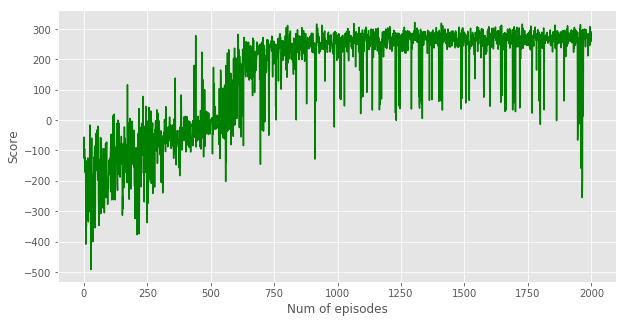

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## Watch The Smart Agent

In [24]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/DQN_{ENV_NAME}.pth'));

In [27]:
num_of_episodes = 20

for i_episode in range(1, num_of_episodes+1):
    
    state = env.reset()
    for time_step in range(200):
        
        # select an action
        action = agent.act(state)
        env.render()
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break

env.close()

---